In [1]:
# Remove cell warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
from datetime import datetime
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_squared_error
import itertools

# Read in the data (Auto_Theft_Open_Data.csv from downloads folder)
df = pd.read_csv('Auto_Theft_Open_Data.csv')

## Police Dataset

In [3]:
df.head()

X          Y  OBJECTID EVENT_UNIQUE_ID             REPORT_DATE  \
0 -79.306757  43.734652         1  GO-20141263217  2014/01/01 05:00:00+00   
1 -79.236189  43.721847         2  GO-20141262914  2014/01/01 05:00:00+00   
2 -79.529478  43.618472         3  GO-20141262837  2014/01/01 05:00:00+00   
3 -79.516814  43.683438         4  GO-20141265795  2014/01/02 05:00:00+00   
4 -79.595364  43.744281         5  GO-20141265947  2014/01/02 05:00:00+00   

                 OCC_DATE  REPORT_YEAR REPORT_MONTH  REPORT_DAY  REPORT_DOY  \
0  2013/12/31 05:00:00+00         2014      January           1           1   
1  2014/01/01 05:00:00+00         2014      January           1           1   
2  2013/12/25 05:00:00+00         2014      January           1           1   
3  2014/01/01 05:00:00+00         2014      January           2           2   
4  2014/01/01 05:00:00+00         2014      January           2           2   

   ... UCR_CODE  UCR_EXT                 OFFENCE MCI_CATEGORY  HOOD_158  \
0  ...     2135      210  Theft Of Motor Vehicle   Auto Theft        43   
1  ...     2135      210  Theft Of Motor Vehicle   Auto Theft       123   
2  ...     2135      210  Theft Of Motor Vehicle   Auto Theft       159   
3  ...     2135      210  Theft Of Motor Vehicle   Auto Theft         9   
4  ...     2135      210  Theft Of Motor Vehicle   Auto Theft         2   

                   NEIGHBOURHOOD_158 HOOD_140  \
0                   Victoria Village       43   
1                         Cliffcrest      123   
2              Etobicoke City Centre       14   
3           Edenbridge-Humber Valley        9   
4  Mount Olive-Silverstone-Jamestown        2   

                       NEIGHBOURHOOD_140 LONG_WGS84  LAT_WGS84  
0                  Victoria Village (43) -79.306757  43.734652  
1                       Cliffcrest (123) -79.236189  43.721847  
2        Islington-City Centre West (14) -79.529478  43.618472  
3           Edenbridge-Humber Valley (9) -79.516814  43.683438  
4  Mount Olive-Silverstone-Jamestown (2) -79.595364  43.744281  

[5 rows x 31 columns]

In [4]:
lst = ['OCC_YEAR', 'OCC_MONTH', 'OCC_DOW', 'OCC_HOUR', 'DIVISION', 'LOCATION_TYPE', 'PREMISES_TYPE','NEIGHBOURHOOD_140']
for i in lst: 
    print(df[i].value_counts())

2022.0    9538
2021.0    6575
2020.0    5777
2019.0    5373
2018.0    4827
2017.0    3651
2014.0    3646
2016.0    3339
2015.0    3267
2013.0      33
2012.0       4
2010.0       4
2008.0       3
2011.0       3
2000.0       2
2001.0       1
2009.0       1
Name: OCC_YEAR, dtype: int64
October      4574
November     4418
September    4171
August       3980
December     3943
July         3932
June         3830
May          3680
March        3656
April        3512
January      3306
February     3042
Name: OCC_MONTH, dtype: int64
Thursday      7024
Wednesday     6961
Friday        6837
Tuesday       6782
Monday        6524
Sunday        5971
Saturday      5945
Name: OCC_DOW, dtype: int64
22    4077
23    3698
21    3645
20    3410
0     2942
18    2893
19    2876
17    2283
16    1890
12    1857
1     1603
15    1470
2     1365
14    1348
13    1219
9     1202
3     1175
10    1136
7     1126
8     1118
4     1005
11     975
6      888
5      847
Name: OCC_HOUR, dtype: int64
D23    6726
D32 

In [5]:
# Count the occurances for each HOOD_140 and sort by descending order
occ = df['HOOD_140'].value_counts().sort_values(ascending=False)

In [6]:
# Select the first 10 indecies from occ
top10 = occ.iloc[:10].index.tolist()

In [7]:
# Create a new dataframe with only the top 10 HOOD_140
df_top10 = df[df['HOOD_140'].isin(top10)]
# For each HOOD_140, OCC_YEAR & OCC_MONTH, count the occurances 
df_top10_counts = df_top10.groupby(['HOOD_140', 'OCC_YEAR', 'OCC_MONTH']).size().reset_index(name='counts')

In [8]:
df_counts = df.groupby(['HOOD_140', 'OCC_YEAR', 'OCC_MONTH']).size().reset_index(name='counts')

In [9]:
df_counts.head()

HOOD_140  OCC_YEAR OCC_MONTH  counts
0        1    2001.0   October       1
1        1    2013.0  December       1
2        1    2013.0   January       2
3        1    2013.0  November       1
4        1    2014.0     April      28

<AxesSubplot:xlabel='DATE', ylabel='counts'>

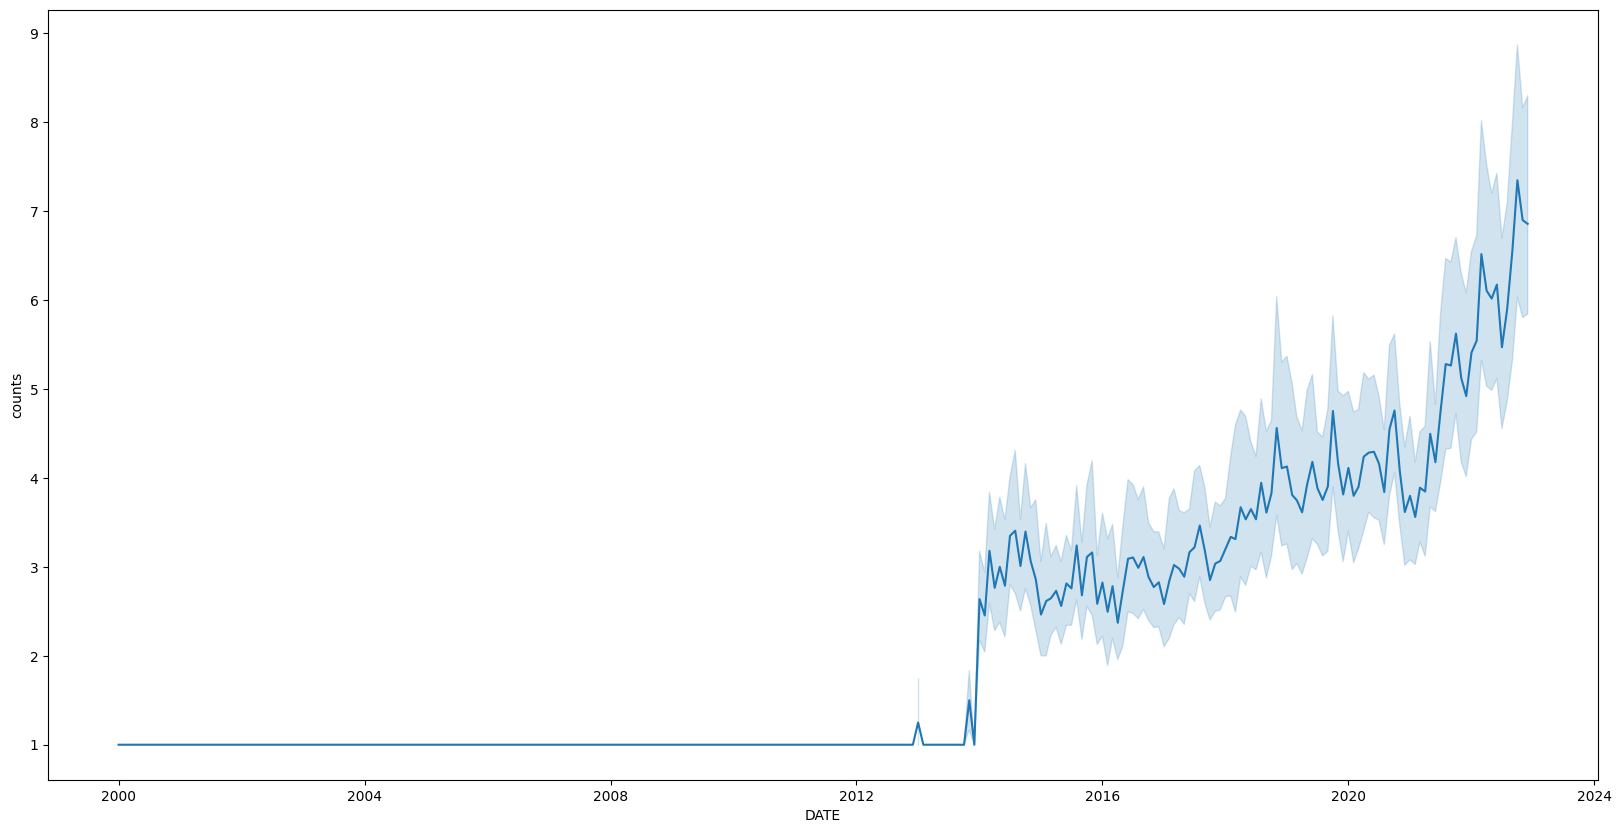

In [10]:
# Line plot of df_counts with counts as y-axis and DATE(OCC_YEAR, OCC_MONTH, 01) as x-axis
plt.figure(figsize=(20,10))
df_counts['OCC_YEAR'] = df_counts['OCC_YEAR'].astype(int)
# Turn the OCC_MONTH from string to int based on month mappings
df_counts['OCC_MONTH'] = df_counts['OCC_MONTH'].map({'January': 1, 'February': 2, 'March': 3, 'April': 4,
                                                        'May': 5, 'June': 6, 'July': 7, 'August': 8,
                                                        'September': 9, 'October': 10, 'November': 11, 'December': 12})
df_counts['DATE'] = df_counts.apply(lambda x: datetime(x['OCC_YEAR'], x['OCC_MONTH'], 1), axis=1)
sns.lineplot(x='DATE', y='counts', data=df_counts)

In [11]:
# What is the mean of counts?
print('mean of counts ' + str(df_counts['counts'].mean()))
# What is the variance of counts?
print('variance of counts ' + str(df_counts['counts'].var()))


mean of counts 3.8927967534663512
variance of counts 22.09352044334111


In [12]:
# What is the average of df_top10_counts['counts']
l = df_counts['counts'].mean()
# Create a new dataframe with x = 1 to np.arange(1, max(df_top10_counts['counts']) + 1, 1) and y = the poisson pdf with lambda = l and x = x
x = np.arange(1, max(df_counts['counts']) + 1, 1)
y = poisson.pmf(x, l)
df_poisson = pd.DataFrame({'x': x, 'y': y})

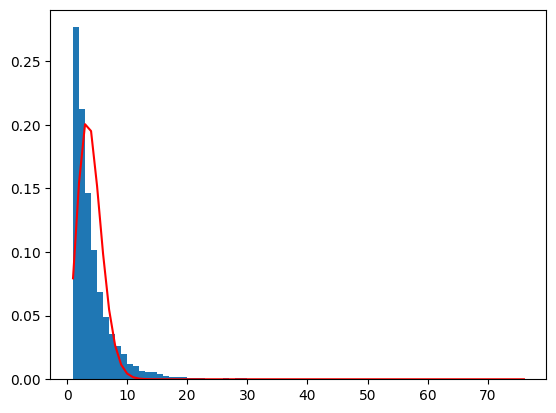

In [13]:
# Create a histogram for counts
plt.hist(df_counts['counts'], bins = np.arange(1, max(df_counts['counts']) + 1, 1),
        density = True)
# Create a line plot for the poisson distribution
plt.plot(df_poisson['x'], df_poisson['y'], color = 'red')
plt.show()


In [14]:
# Floor the count to the nearest 5
df_counts_new = df_counts.copy(deep=True)
df_counts_new['counts'] = np.floor(df_counts['counts'] / 5) * 5
# Repeat for the poissson distribution
df_poisson_new = df_poisson.copy(deep=True)
df_poisson_new['x'] = np.floor(df_poisson['x'] / 5) * 5


In [15]:
# For the poisson distribution, group by x and sum the y values
df_poisson_new = df_poisson_new.groupby('x')['y'].sum().reset_index(name='y')

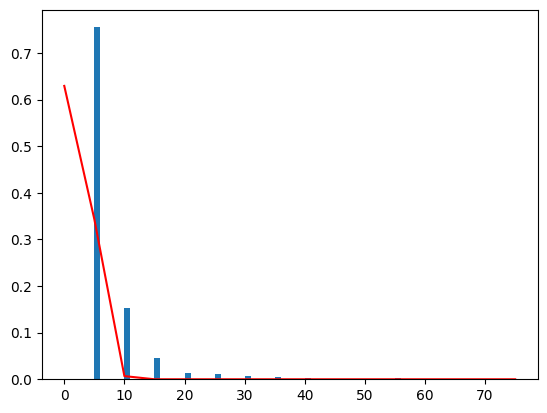

In [16]:
# Recreate the histogram and line plot
plt.hist(df_counts_new['counts'], bins = np.arange(1, max(df_counts_new['counts']) + 1, 1),
        density = True)
plt.plot(df_poisson_new['x'], df_poisson_new['y'], color = 'red')
plt.show()

In [17]:
# Load in the other datasets we're going to use 
pop_change = pd.read_excel('wellbeing-toronto-population-total-2011-2016-and-age-groups-2016.xlsx', 
                           sheet_name='016 Pop_TotalChange')
pop_age = pd.read_excel('wellbeing-toronto-population-total-2011-2016-and-age-groups-2016.xlsx',
                        sheet_name='2016_Age Groups')
econ = pd.read_excel('wellbeing-toronto-economics.xlsx', 
                     sheet_name= 'RawData-Ref Period 2011')
housing = pd.read_excel('wellbeing-toronto-housing.xlsx',
                        sheet_name='RawDataRef_2011')

## Population Change Dataset

In [18]:
# Rename PopChg11t16 to pct_change
pop_change = pop_change.rename(columns={'PopChg11t16': 'pct_change'})
pop_change.head()

HoodID                      Neighbourhood  Pop2016  Pop2011  pct_change
0       1             West Humber-Clairville    33312    34100   -0.023109
1       2  Mount Olive-Silverstone-Jamestown    32954    32788    0.005063
2       3       Thistletown-Beaumond Heights    10360    10138    0.021898
3       4                    Rexdale-Kipling    10529    10488    0.003909
4       5                   Elms-Old Rexdale     9456     9550   -0.009843

In [19]:
pop_change.describe()

HoodID       Pop2016       Pop2011  pct_change
count  140.0000    140.000000    140.000000  140.000000
mean    70.5000  19511.221429  18679.000000    0.040404
std     40.5586  10033.589222   9100.831576    0.089014
min      1.0000   6577.000000   6488.000000   -0.075937
25%     35.7500  12019.500000  11853.750000   -0.003442
50%     70.5000  16749.500000  16364.500000    0.014677
75%    105.2500  23854.500000  22407.500000    0.042488
max    140.0000  65913.000000  53350.000000    0.520099

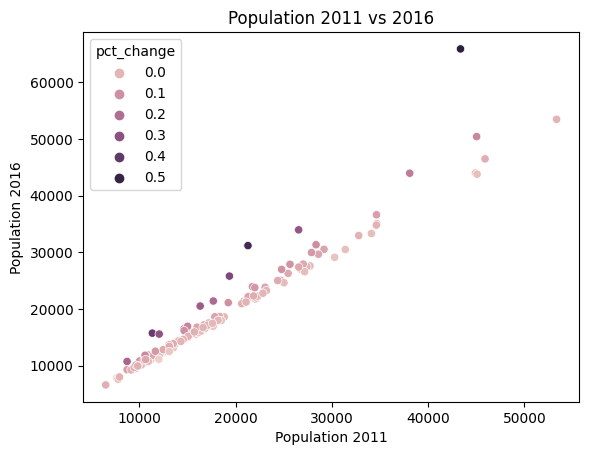

In [20]:
# Create a scatterplot with Pop2011 on the x-axis and Pop2016 on the y-axis & use the pct_change as the hue
sns.scatterplot(x='Pop2011', y='Pop2016', hue='pct_change', data=pop_change)
# Add title and axis labels
plt.title('Population 2011 vs 2016')
plt.xlabel('Population 2011')
plt.ylabel('Population 2016')
plt.show()


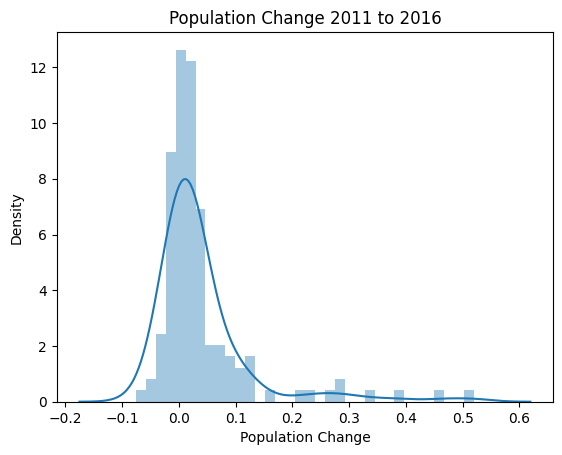

In [21]:
# Create a histogram of pct_change
sns.distplot(pop_change['pct_change'], kde=True)
# Add title and axis labels
plt.title('Population Change 2011 to 2016')
plt.xlabel('Population Change')
plt.ylabel('Density')
plt.show()

## Population Age Dataset

In [22]:
pop_age.head()

NeighbourhoodID                      Neighbourhood  0 to 04 years  \
0              1.0             West Humber-Clairville         1540.0   
1              2.0  Mount Olive-Silverstone-Jamestown         2190.0   
2              3.0       Thistletown-Beaumond Heights          540.0   
3              4.0                    Rexdale-Kipling          560.0   
4              5.0                   Elms-Old Rexdale          540.0   

   0 to 14 years  05 to 09 years  10 to 14 years  100 years and over  \
0         5060.0          1720.0          1790.0                 5.0   
1         7090.0          2500.0          2415.0                 0.0   
2         1730.0           600.0           595.0                 5.0   
3         1640.0           515.0           565.0                 0.0   
4         1805.0           605.0           660.0                 0.0   

   15 to 19 years  20 to 24 years  25 to 29 years  ...  65 to 69 years  \
0          2325.0          3120.0          2785.0  ...          1595.0   
1          2585.0          2655.0          2400.0  ...          1285.0   
2           650.0           760.0           680.0  ...           490.0   
3           635.0           720.0           715.0  ...           520.0   
4           690.0           750.0           600.0  ...           415.0   

   65 years and over  70 to 74 years  75 to 79 years  80 to 84 years  \
0             4980.0          1185.0           885.0           700.0   
1             3560.0           885.0           630.0           465.0   
2             1880.0           375.0           335.0           320.0   
3             1730.0           350.0           295.0           270.0   
4             1275.0           305.0           235.0           180.0   

   85 to 89 years  85 years and over  90 to 94 years  95 to 99 years  \
0           400.0              615.0           160.0            50.0   
1           225.0              300.0            70.0            10.0   
2           225.0              350.0           100.0            20.0   
3           205.0              300.0            85.0            15.0   
4           105.0              145.0            40.0             5.0   

   Total Population - All Age Groups - 100% data  
0                                        33320.0  
1                                        32950.0  
2                                        10360.0  
3                                        10530.0  
4                                         9460.0  

[5 rows x 27 columns]

In [23]:
# There are columns that contain the same information, so select the columns of interest
pop_age = pop_age[['NeighbourhoodID', 'Neighbourhood', '0 to 14 years', '15 to 19 years', '20 to 24 years', '25 to 29 years', '30 to 34 years', '35 to 39 years', 
         '40 to 44 years', '50 to 54 years', '55 to 59 years', '60 to 64 years', '65 to 69 years', '70 to 74 years', '75 to 79 years', 
         '80 to 84 years', '85 to 89 years', '90 to 94 years', '95 to 99 years', '100 years and over', 'Total Population - All Age Groups - 100% data']]

In [24]:
# There isn't 45-49 years so we'll have to create it
# Subtract the sum of all other ages from Total Population - All Age Groups - 100% data
pop_age['45 to 49 years'] = pop_age['Total Population - All Age Groups - 100% data'] - pop_age[['0 to 14 years', '15 to 19 years', '20 to 24 years', '25 to 29 years', '30 to 34 years', '35 to 39 years',
                                                                                                '40 to 44 years', '50 to 54 years', '55 to 59 years', '60 to 64 years', '65 to 69 years', '70 to 74 years',
                                                                                                '75 to 79 years', '80 to 84 years', '85 to 89 years', '90 to 94 years', '95 to 99 years', '100 years and over']].sum(axis=1)
pop_age.head()

NeighbourhoodID                      Neighbourhood  0 to 14 years  \
0              1.0             West Humber-Clairville         5060.0   
1              2.0  Mount Olive-Silverstone-Jamestown         7090.0   
2              3.0       Thistletown-Beaumond Heights         1730.0   
3              4.0                    Rexdale-Kipling         1640.0   
4              5.0                   Elms-Old Rexdale         1805.0   

   15 to 19 years  20 to 24 years  25 to 29 years  30 to 34 years  \
0          2325.0          3120.0          2785.0          2345.0   
1          2585.0          2655.0          2400.0          2250.0   
2           650.0           760.0           680.0           715.0   
3           635.0           720.0           715.0           680.0   
4           690.0           750.0           600.0           575.0   

   35 to 39 years  40 to 44 years  50 to 54 years  ...  65 to 69 years  \
0          2035.0          1980.0          2475.0  ...          1595.0   
1          2185.0          2275.0          2190.0  ...          1285.0   
2           665.0           610.0           770.0  ...           490.0   
3           640.0           680.0           815.0  ...           520.0   
4           550.0           540.0           755.0  ...           415.0   

   70 to 74 years  75 to 79 years  80 to 84 years  85 to 89 years  \
0          1185.0           885.0           700.0           400.0   
1           885.0           630.0           465.0           225.0   
2           375.0           335.0           320.0           225.0   
3           350.0           295.0           270.0           205.0   
4           305.0           235.0           180.0           105.0   

   90 to 94 years  95 to 99 years  100 years and over  \
0           160.0            50.0                 5.0   
1            70.0            10.0                 0.0   
2           100.0            20.0                 5.0   
3            85.0            15.0                 0.0   
4            40.0             5.0                 0.0   

   Total Population - All Age Groups - 100% data  45 to 49 years  
0                                        33320.0          2225.0  
1                                        32950.0          2275.0  
2                                        10360.0           715.0  
3                                        10530.0           745.0  
4                                         9460.0           655.0  

[5 rows x 22 columns]

In [25]:
pop_age.describe()

NeighbourhoodID  0 to 14 years  15 to 19 years  20 to 24 years  \
count         140.0000     140.000000      140.000000      140.000000   
mean           70.5000    2837.750000     1039.535714     1390.500000   
std            40.5586    1554.223108      604.784252      972.859262   
min             1.0000     425.000000      295.000000      375.000000   
25%            35.7500    1695.000000      633.750000      763.750000   
50%            70.5000    2405.000000      890.000000     1142.500000   
75%           105.2500    3567.500000     1271.250000     1562.500000   
max           140.0000    9625.000000     3400.000000     6700.000000   

       25 to 29 years  30 to 34 years  35 to 39 years  40 to 44 years  \
count      140.000000      140.000000      140.000000      140.000000   
mean      1664.178571     1604.535714     1403.357143     1304.428571   
std       1643.790431     1378.752420      864.083380      661.347569   
min        320.000000      285.000000      355.000000      375.000000   
25%        831.250000      838.750000      861.250000      837.500000   
50%       1237.500000     1295.000000     1220.000000     1130.000000   
75%       2012.500000     1800.000000     1665.000000     1626.250000   
max      15755.000000    12400.000000     6815.000000     4135.000000   

       50 to 54 years  55 to 59 years  ...  65 to 69 years  70 to 74 years  \
count      140.000000      140.000000  ...       140.00000      140.000000   
mean      1446.178571     1329.857143  ...       947.50000      668.142857   
std        696.396844      675.931530  ...       490.19505      346.117907   
min        380.000000      320.000000  ...       275.00000      190.000000   
25%        920.000000      865.000000  ...       598.75000      420.000000   
50%       1247.500000     1125.000000  ...       822.50000      580.000000   
75%       1831.250000     1680.000000  ...      1190.00000      830.000000   
max       3750.000000     4195.000000  ...      2635.00000     1855.000000   

       75 to 79 years  80 to 84 years  85 to 89 years  90 to 94 years  \
count      140.000000      140.000000      140.000000      140.000000   
mean       543.107143      431.928571      292.785714      139.500000   
std        296.071683      249.488387      179.821326       95.928443   
min        105.000000       65.000000       35.000000       10.000000   
25%        325.000000      240.000000      163.750000       70.000000   
50%        472.500000      367.500000      237.500000      110.000000   
75%        703.750000      562.500000      401.250000      191.250000   
max       1770.000000     1440.000000      955.000000      520.000000   

       95 to 99 years  100 years and over  \
count      140.000000          140.000000   
mean       103.678571            9.035714   
std        835.185244           45.628688   
min          0.000000            0.000000   
25%         13.750000            0.000000   
50%         25.000000            5.000000   
75%         50.000000           10.000000   
max       9910.000000          540.000000   

       Total Population - All Age Groups - 100% data  45 to 49 years  
count                                     139.000000      139.000000  
mean                                    19578.992806     1368.345324  
std                                     10037.837423      645.373274  
min                                      6585.000000      380.000000  
25%                                     12232.500000      867.500000  
50%                                     16775.000000     1235.000000  
75%                                     23880.000000     1730.000000  
max                                     65920.000000     3585.000000  

[8 rows x 21 columns]

In [26]:
# When is NeighbourhoodID null
pop_age[pop_age['NeighbourhoodID'].isnull()]

NeighbourhoodID Neighbourhood  0 to 14 years  15 to 19 years  \
140              NaN           410            NaN             NaN   

     20 to 24 years  25 to 29 years  30 to 34 years  35 to 39 years  \
140             NaN             NaN             NaN             NaN   

     40 to 44 years  50 to 54 years  ...  65 to 69 years  70 to 74 years  \
140             NaN             NaN  ...             NaN             NaN   

     75 to 79 years  80 to 84 years  85 to 89 years  90 to 94 years  \
140             NaN             NaN             NaN             NaN   

     95 to 99 years  100 years and over  \
140             NaN                 NaN   

     Total Population - All Age Groups - 100% data  45 to 49 years  
140                                            NaN             NaN  

[1 rows x 22 columns]

In [27]:
# Drop rows where NeighbourhoodID is null
pop_age = pop_age.dropna(subset=['NeighbourhoodID'])

In [28]:
# There are a lot of columns, let's group in 10 year increments
# Create a new dataframe with the columns of interest
pop_age_new = pop_age[['NeighbourhoodID', 'Neighbourhood', '0 to 14 years', '15 to 19 years', '20 to 24 years', '25 to 29 years', '30 to 34 years', '35 to 39 years',
                          '40 to 44 years', '45 to 49 years', '50 to 54 years', '55 to 59 years', '60 to 64 years', '65 to 69 years', '70 to 74 years',
                            '75 to 79 years', '80 to 84 years', '85 to 89 years', '90 to 94 years', '95 to 99 years', '100 years and over']].copy(deep=True)
# Group the columns in 10 year increments
pop_age_new['0 to 19 years'] = pop_age_new[['0 to 14 years', '15 to 19 years']].sum(axis=1).astype(int)
pop_age_new['20 to 29 years'] = pop_age_new[['20 to 24 years', '25 to 29 years']].sum(axis=1).astype(int)
pop_age_new['30 to 39 years'] = pop_age_new[['30 to 34 years', '35 to 39 years']].sum(axis=1).astype(int)
pop_age_new['40 to 49 years'] = pop_age_new[['40 to 44 years', '45 to 49 years']].sum(axis=1).astype(int)
pop_age_new['50 to 59 years'] = pop_age_new[['50 to 54 years', '55 to 59 years']].sum(axis=1).astype(int)
pop_age_new['60 to 69 years'] = pop_age_new[['60 to 64 years', '65 to 69 years']].sum(axis=1).astype(int)
# Group 70+ together
pop_age_new['70+ years'] = pop_age_new[['70 to 74 years', '75 to 79 years', '80 to 84 years', '85 to 89 years', '90 to 94 years', '95 to 99 years', '100 years and over']].sum(axis=1).astype(int)
# Drop the columns we grouped
pop_age_new = pop_age_new.drop(columns=['0 to 14 years', '15 to 19 years', '20 to 24 years', '25 to 29 years', '30 to 34 years', '35 to 39 years',
                            '40 to 44 years', '45 to 49 years', '50 to 54 years', '55 to 59 years', '60 to 64 years', '65 to 69 years', '70 to 74 years',
                            '75 to 79 years', '80 to 84 years', '85 to 89 years', '90 to 94 years', '95 to 99 years', '100 years and over'])
pop_age_new.head()


NeighbourhoodID                      Neighbourhood  0 to 19 years  \
0              1.0             West Humber-Clairville           7385   
1              2.0  Mount Olive-Silverstone-Jamestown           9675   
2              3.0       Thistletown-Beaumond Heights           2380   
3              4.0                    Rexdale-Kipling           2275   
4              5.0                   Elms-Old Rexdale           2495   

   20 to 29 years  30 to 39 years  40 to 49 years  50 to 59 years  \
0            5905            4380            4205            4670   
1            5055            4435            4550            4145   
2            1440            1380            1325            1430   
3            1435            1320            1425            1685   
4            1350            1125            1195            1485   

   60 to 69 years  70+ years  
0            3390       3385  
1            2805       2285  
2            1025       1380  
3            1170       1220  
4             940        870

In [29]:
# Turn NeighbourhoodID into integer
pop_age_new['NeighbourhoodID'] = pop_age_new['NeighbourhoodID'].astype(int)

In [30]:
pop_age_new.describe()

NeighbourhoodID  0 to 19 years  20 to 29 years  30 to 39 years  \
count         140.0000     140.000000      140.000000      140.000000   
mean           70.5000    3877.285714     3054.678571     3007.892857   
std            40.5586    2131.700302     2514.819616     2217.259802   
min             1.0000     895.000000      775.000000      640.000000   
25%            35.7500    2352.500000     1642.500000     1637.500000   
50%            70.5000    3270.000000     2290.000000     2537.500000   
75%           105.2500    4811.250000     3611.250000     3407.500000   
max           140.0000   13025.000000    22455.000000    19215.000000   

       40 to 49 years  50 to 59 years  60 to 69 years     70+ years  
count      140.000000      140.000000      140.000000    140.000000  
mean      2663.000000     2776.035714     2045.178571   2188.178571  
std       1299.784957     1335.364916     1001.602387   1431.548592  
min        755.000000      700.000000      635.000000    415.000000  
25%       1715.000000     1785.000000     1330.000000   1270.000000  
50%       2350.000000     2385.000000     1785.000000   1775.000000  
75%       3326.250000     3525.000000     2572.500000   2730.000000  
max       7360.000000     7240.000000     5725.000000  12370.000000

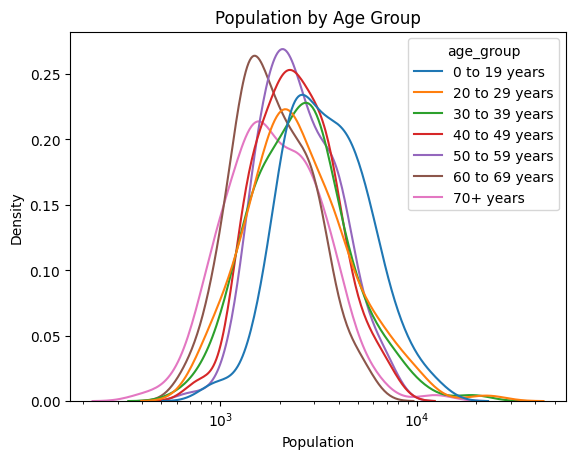

In [31]:
# Create histograms for each age group using color for each age group
# Turn the dataframe into a long dataframe
pop_age_new_long = pd.melt(pop_age_new, id_vars=['NeighbourhoodID', 'Neighbourhood'], var_name='age_group', value_name='population')
# Create the histogram with population on the x-axis and density on the y-axis and use the age_group as the hue
sns.kdeplot(data = pop_age_new_long, x = 'population', hue = 'age_group',
             palette=sns.color_palette("tab10")[:7], log_scale = True)

# # Add title and axis labels
plt.title('Population by Age Group')
plt.xlabel('Population')
plt.ylabel('Density')
plt.show()

In [32]:
pop_age_new.columns

Index(['NeighbourhoodID', 'Neighbourhood', '0 to 19 years', '20 to 29 years',
       '30 to 39 years', '40 to 49 years', '50 to 59 years', '60 to 69 years',
       '70+ years'],
      dtype='object')

Text(0.5, 1.0, 'Correlation of Age Groups')

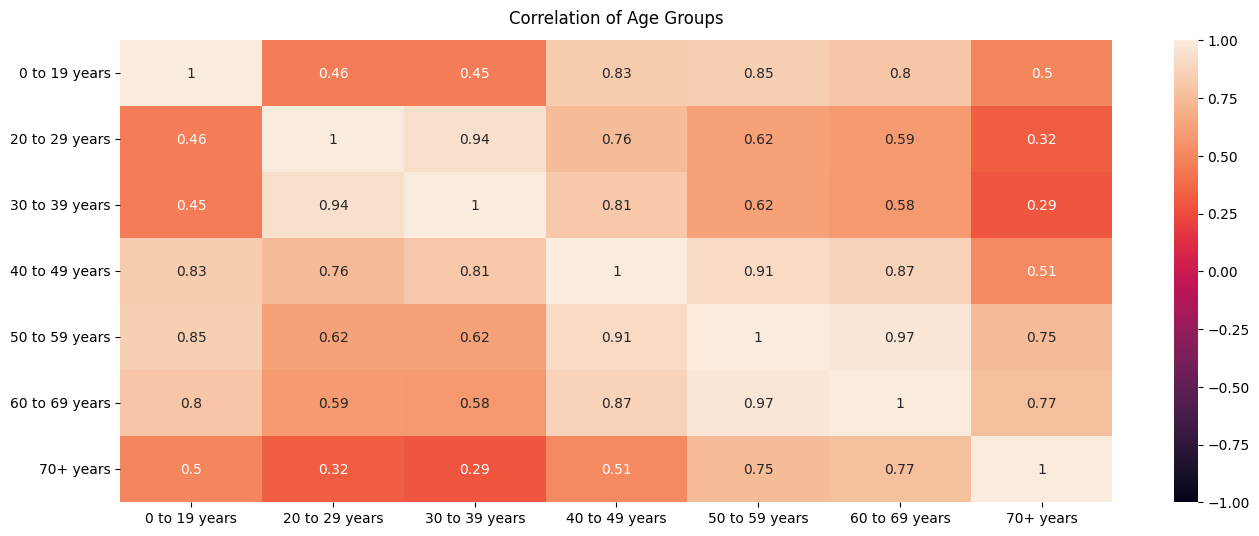

In [33]:
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(pop_age_new[['0 to 19 years', '20 to 29 years',
       '30 to 39 years', '40 to 49 years', '50 to 59 years', '60 to 69 years',
       '70+ years']].corr(), 
       vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation of Age Groups', fontdict={'fontsize':12}, pad=12)

## Economics Dataset

In [34]:
econ.head()

Neighbourhood  Neighbourhood Id  Businesses  \
0             West Humber-Clairville                 1        2463   
1  Mount Olive-Silverstone-Jamestown                 2         271   
2       Thistletown-Beaumond Heights                 3         217   
3                    Rexdale-Kipling                 4         144   
4                   Elms-Old Rexdale                 5          67   

   Child Care Spaces  Debt Risk Score  Home Prices  Local Employment  \
0                195              719       317508             58271   
1                 60              687       251119              3244   
2                 25              718       414216              1311   
3                 75              721       392271              1178   
4                 60              692       233832               903   

   Social Assistance Recipients  
0                          2912  
1                          6561  
2                          1276  
3                          1323  
4                          1683

In [35]:
econ.describe()

Neighbourhood Id   Businesses  Child Care Spaces  Debt Risk Score  \
count          140.0000   140.000000         140.000000       140.000000   
mean            70.5000   536.321429         124.685714       739.157143   
std             40.5586   637.210719          81.603541        28.626162   
min              1.0000    47.000000           0.000000       661.000000   
25%             35.7500   169.750000          60.000000       720.500000   
50%             70.5000   345.500000         109.500000       741.000000   
75%            105.2500   591.000000         176.000000       759.000000   
max            140.0000  4324.000000         441.000000       793.000000   

        Home Prices  Local Employment  Social Assistance Recipients  
count  1.400000e+02          140.0000                    140.000000  
mean   5.481934e+05         9409.3500                   1864.700000  
std    2.676674e+05        19125.3383                   1504.562647  
min    2.041040e+05          438.0000                     37.000000  
25%    3.749645e+05         2069.5000                    697.000000  
50%    4.912100e+05         4052.5000                   1455.000000  
75%    5.902160e+05        10127.0000                   2682.750000  
max    1.849084e+06       185891.0000                   7263.000000

In [36]:
# Are there any null values?
econ.isnull().any()

Neighbourhood                   False
Neighbourhood Id                False
Businesses                      False
Child Care Spaces               False
Debt Risk Score                 False
Home Prices                     False
Local Employment                False
Social Assistance Recipients    False
dtype: bool

In [37]:
# Drop the home price column since that's also in the hosuing dataset
econ = econ.drop(columns=['Home Prices'])

In [38]:
econ.head()

Neighbourhood  Neighbourhood Id  Businesses  \
0             West Humber-Clairville                 1        2463   
1  Mount Olive-Silverstone-Jamestown                 2         271   
2       Thistletown-Beaumond Heights                 3         217   
3                    Rexdale-Kipling                 4         144   
4                   Elms-Old Rexdale                 5          67   

   Child Care Spaces  Debt Risk Score  Local Employment  \
0                195              719             58271   
1                 60              687              3244   
2                 25              718              1311   
3                 75              721              1178   
4                 60              692               903   

   Social Assistance Recipients  
0                          2912  
1                          6561  
2                          1276  
3                          1323  
4                          1683

In [39]:
econ.columns

Index(['Neighbourhood', 'Neighbourhood Id', 'Businesses', 'Child Care Spaces',
       'Debt Risk Score', 'Local Employment', 'Social Assistance Recipients'],
      dtype='object')

Text(0.5, 1.0, 'Correlation of Economic Metrics')

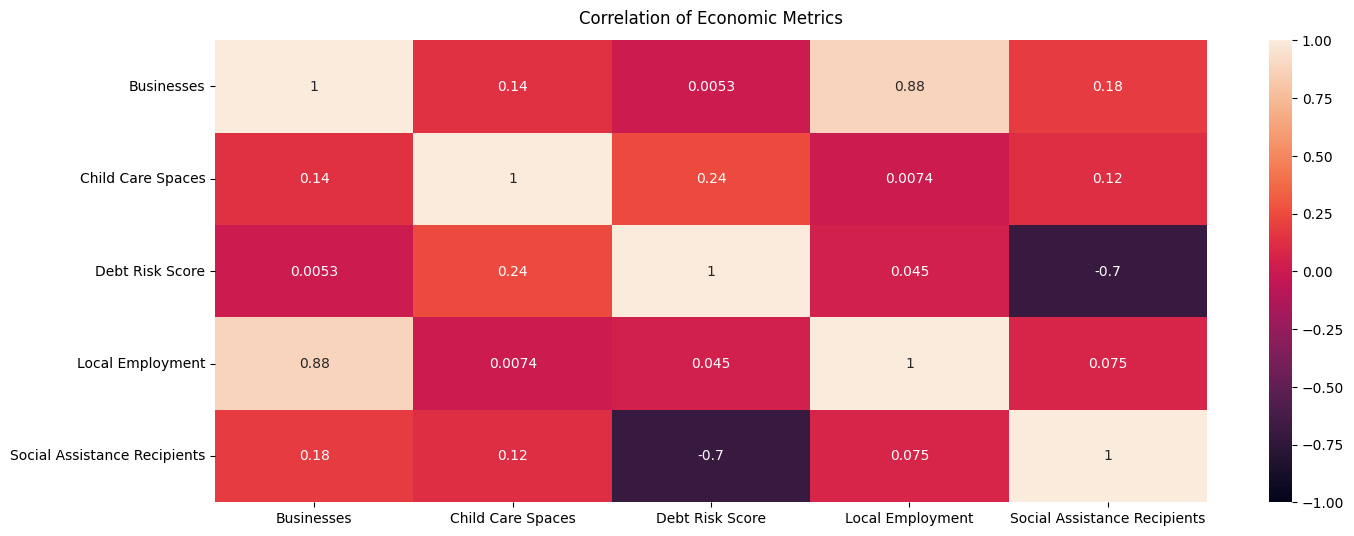

In [40]:
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(econ[['Businesses', 'Child Care Spaces',
       'Debt Risk Score', 'Local Employment', 'Social Assistance Recipients']].corr(), 
       vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation of Economic Metrics', fontdict={'fontsize':12}, pad=12)

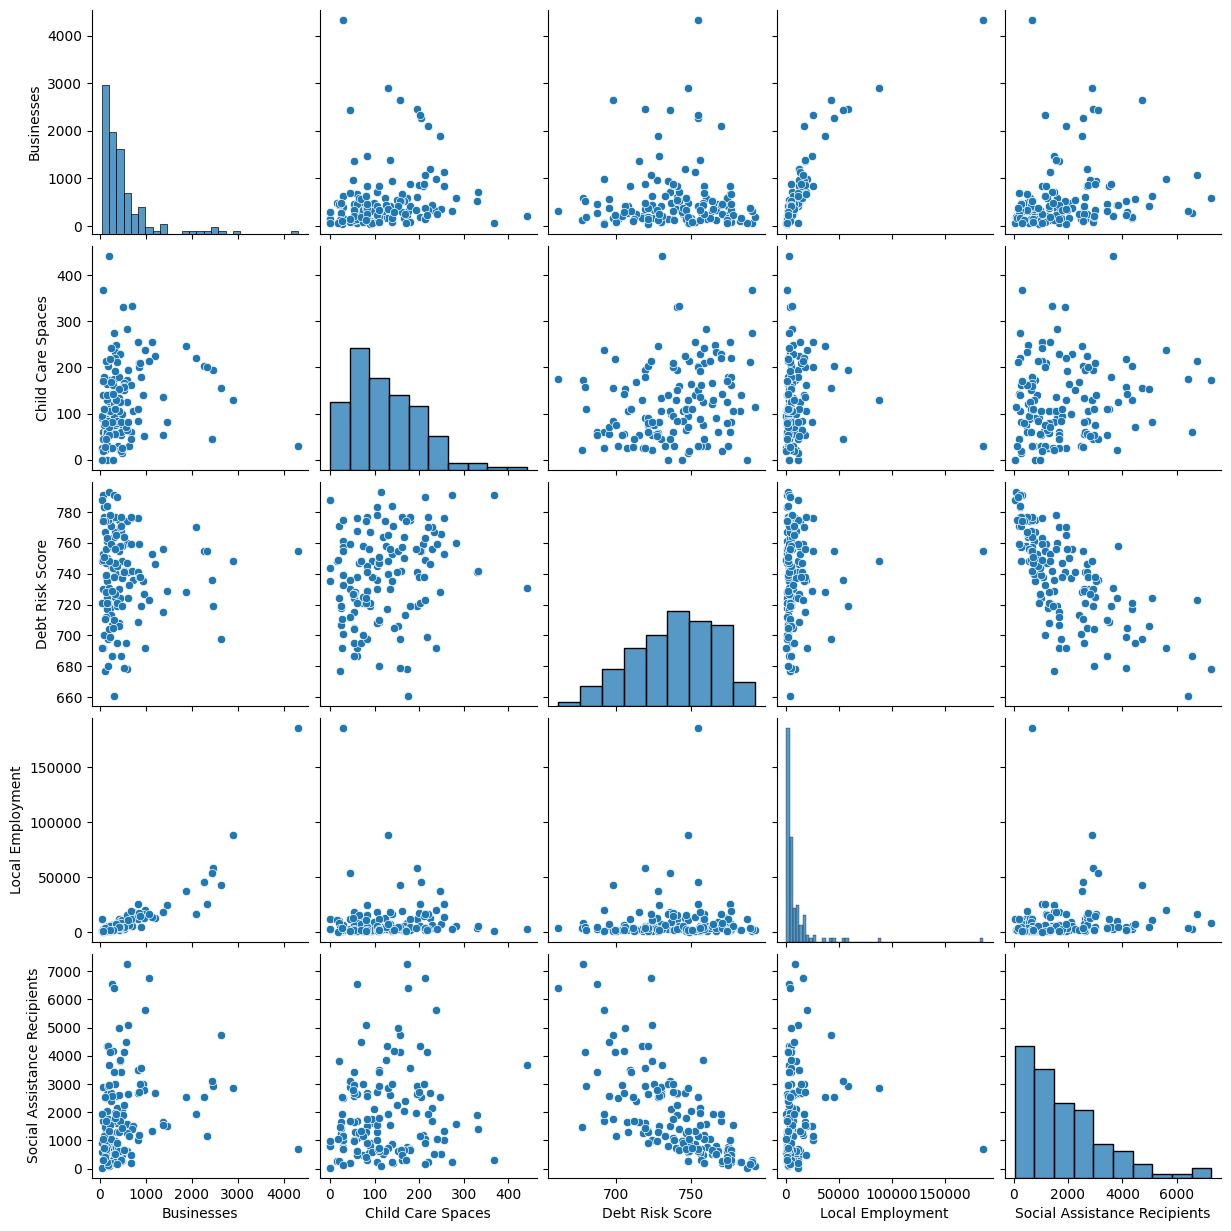

In [41]:
# Create a pairplot of the economic metrics
sns.pairplot(econ[['Businesses', 'Child Care Spaces',
         'Debt Risk Score', 'Local Employment', 'Social Assistance Recipients']])
plt.show()

## Housing Dataset

In [42]:
housing.head()

Neighbourhood  Neighbourhood Id  Home Prices  \
0             West Humber-Clairville                 1       317508   
1  Mount Olive-Silverstone-Jamestown                 2       251119   
2       Thistletown-Beaumond Heights                 3       414216   
3                    Rexdale-Kipling                 4       392271   
4                   Elms-Old Rexdale                 5       233832   

   Mid-Century Highrise Households  Mid-Century Highrise Population  \
0                              690                             1810   
1                             4110                            13395   
2                              430                             1260   
3                              600                             1050   
4                              870                             2305   

   Percent Mid-Century Highrise Households  \
0                                      6.8   
1                                     42.9   
2                                     13.4   
3                                     15.2   
4                                     27.3   

   Percent Mid-Century Highrise Population  Rent Bank Applicants  \
0                                      5.3                    38   
1                                     40.9                    41   
2                                     12.4                     7   
3                                     10.0                    19   
4                                     24.1                    14   

   Social Housing Turnover  Social Housing Units  Social Housing Waiting List  
0                 0.312500                   952                          557  
1                 7.000000                  1146                         1049  
2                 1.333333                   447                          270  
3                 4.200000                   432                          186  
4                 1.000000                   463                          239

Text(0.5, 1.0, 'Correlation of Housing Metrics')

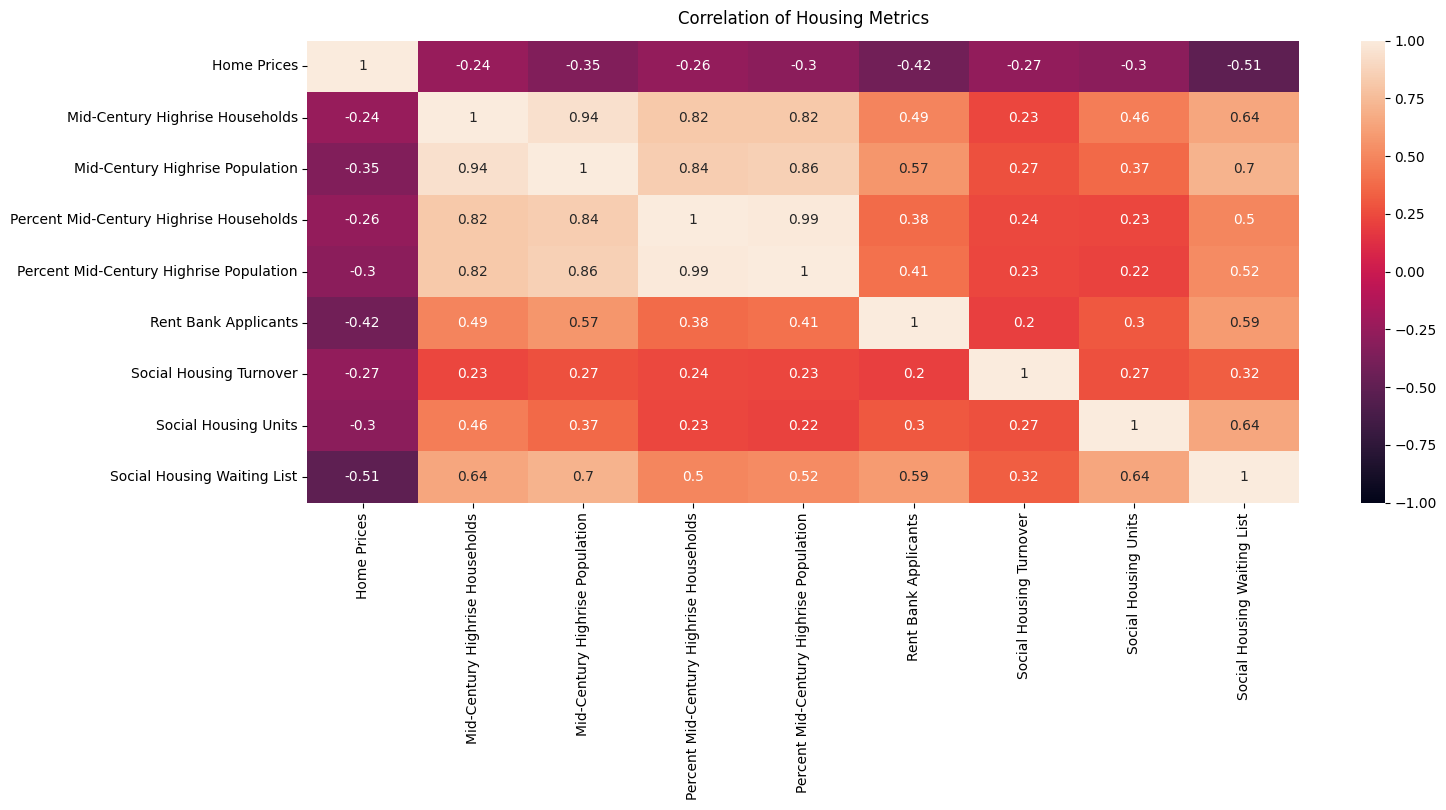

In [43]:
# Let's do a correlation matrix for the housing dataset
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(housing[['Home Prices', 'Mid-Century Highrise Households', 'Mid-Century Highrise Population',
         'Percent Mid-Century Highrise Households', 'Percent Mid-Century Highrise Population',
            'Rent Bank Applicants', 'Social Housing Turnover', 'Social Housing Units', 'Social Housing Waiting List']].corr(),
         vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation of Housing Metrics', fontdict={'fontsize':12}, pad=12)



In [44]:
# When is df_counts['HOOD_140'] NSA
# Drop these rows
df_counts = df_counts.drop(df_counts[df_counts['HOOD_140'] == 'NSA'].index)

In [45]:
# Turn HOOD_140 to int
df_counts['HOOD_140'] = df_counts['HOOD_140'].astype(int)
pop_change['HoodID'] = pop_change['HoodID'].astype(int)
pop_age_new['NeighbourhoodID'] = pop_age_new['NeighbourhoodID'].astype(int)
econ['Neighbourhood Id'] = econ['Neighbourhood Id'].astype(int)
housing['Neighbourhood Id'] = housing['Neighbourhood Id'].astype(int)

In [46]:
# Let's join the datasets together to df_counts based on HOOD_140
master_agg_df = df_counts\
    .merge(pop_change, left_on='HOOD_140', right_on='HoodID', how='left')\
    .merge(pop_age_new, left_on='HOOD_140', right_on='NeighbourhoodID', how='left')\
    .merge(econ, left_on='HOOD_140', right_on='Neighbourhood Id', how='left')\
    .merge(housing, left_on='HOOD_140', right_on='Neighbourhood Id', how='left')
master_agg_df.head()

HOOD_140  OCC_YEAR  OCC_MONTH  counts       DATE  HoodID  \
0         1      2001         10       1 2001-10-01       1   
1         1      2013         12       1 2013-12-01       1   
2         1      2013          1       2 2013-01-01       1   
3         1      2013         11       1 2013-11-01       1   
4         1      2014          4      28 2014-04-01       1   

          Neighbourhood_x  Pop2016  Pop2011  pct_change  ...  \
0  West Humber-Clairville    33312    34100   -0.023109  ...   
1  West Humber-Clairville    33312    34100   -0.023109  ...   
2  West Humber-Clairville    33312    34100   -0.023109  ...   
3  West Humber-Clairville    33312    34100   -0.023109  ...   
4  West Humber-Clairville    33312    34100   -0.023109  ...   

   Neighbourhood Id_y Home Prices  Mid-Century Highrise Households  \
0                   1      317508                              690   
1                   1      317508                              690   
2                   1      317508                              690   
3                   1      317508                              690   
4                   1      317508                              690   

   Mid-Century Highrise Population  Percent Mid-Century Highrise Households  \
0                             1810                                      6.8   
1                             1810                                      6.8   
2                             1810                                      6.8   
3                             1810                                      6.8   
4                             1810                                      6.8   

   Percent Mid-Century Highrise Population  Rent Bank Applicants  \
0                                      5.3                    38   
1                                      5.3                    38   
2                                      5.3                    38   
3                                      5.3                    38   
4                                      5.3                    38   

   Social Housing Turnover  Social Housing Units Social Housing Waiting List  
0                   0.3125                   952                         557  
1                   0.3125                   952                         557  
2                   0.3125                   952                         557  
3                   0.3125                   952                         557  
4                   0.3125                   952                         557  

[5 rows x 37 columns]

In [47]:
master_agg_df.columns

Index(['HOOD_140', 'OCC_YEAR', 'OCC_MONTH', 'counts', 'DATE', 'HoodID',
       'Neighbourhood_x', 'Pop2016', 'Pop2011', 'pct_change',
       'NeighbourhoodID', 'Neighbourhood_y', '0 to 19 years', '20 to 29 years',
       '30 to 39 years', '40 to 49 years', '50 to 59 years', '60 to 69 years',
       '70+ years', 'Neighbourhood_x', 'Neighbourhood Id_x', 'Businesses',
       'Child Care Spaces', 'Debt Risk Score', 'Local Employment',
       'Social Assistance Recipients', 'Neighbourhood_y', 'Neighbourhood Id_y',
       'Home Prices', 'Mid-Century Highrise Households',
       'Mid-Century Highrise Population',
       'Percent Mid-Century Highrise Households',
       'Percent Mid-Century Highrise Population', 'Rent Bank Applicants',
       'Social Housing Turnover', 'Social Housing Units',
       'Social Housing Waiting List'],
      dtype='object')

In [48]:
# Drop HoodID, Neighbourhood_x, Neighbourhood Id_y, NeighbourhoodID, Neighbourhood_x, Neighbourhood Id_x, Neighbourhood_y, Neighbourhood Id_y
master_agg_df = master_agg_df.drop(columns=['HoodID', 'Neighbourhood_x', 'Neighbourhood Id_y', 
                                            'NeighbourhoodID', 'Neighbourhood_x', 'Neighbourhood Id_x', 'Neighbourhood_y', 'Neighbourhood Id_y'])

In [49]:
master_agg_df.head()

HOOD_140  OCC_YEAR  OCC_MONTH  counts       DATE  Pop2016  Pop2011  \
0         1      2001         10       1 2001-10-01    33312    34100   
1         1      2013         12       1 2013-12-01    33312    34100   
2         1      2013          1       2 2013-01-01    33312    34100   
3         1      2013         11       1 2013-11-01    33312    34100   
4         1      2014          4      28 2014-04-01    33312    34100   

   pct_change  0 to 19 years  20 to 29 years  ...  \
0   -0.023109           7385            5905  ...   
1   -0.023109           7385            5905  ...   
2   -0.023109           7385            5905  ...   
3   -0.023109           7385            5905  ...   
4   -0.023109           7385            5905  ...   

   Social Assistance Recipients  Home Prices  Mid-Century Highrise Households  \
0                          2912       317508                              690   
1                          2912       317508                              690   
2                          2912       317508                              690   
3                          2912       317508                              690   
4                          2912       317508                              690   

   Mid-Century Highrise Population  Percent Mid-Century Highrise Households  \
0                             1810                                      6.8   
1                             1810                                      6.8   
2                             1810                                      6.8   
3                             1810                                      6.8   
4                             1810                                      6.8   

   Percent Mid-Century Highrise Population  Rent Bank Applicants  \
0                                      5.3                    38   
1                                      5.3                    38   
2                                      5.3                    38   
3                                      5.3                    38   
4                                      5.3                    38   

   Social Housing Turnover  Social Housing Units  Social Housing Waiting List  
0                   0.3125                   952                          557  
1                   0.3125                   952                          557  
2                   0.3125                   952                          557  
3                   0.3125                   952                          557  
4                   0.3125                   952                          557  

[5 rows x 29 columns]

In [50]:
master_agg_df.columns

Index(['HOOD_140', 'OCC_YEAR', 'OCC_MONTH', 'counts', 'DATE', 'Pop2016',
       'Pop2011', 'pct_change', '0 to 19 years', '20 to 29 years',
       '30 to 39 years', '40 to 49 years', '50 to 59 years', '60 to 69 years',
       '70+ years', 'Businesses', 'Child Care Spaces', 'Debt Risk Score',
       'Local Employment', 'Social Assistance Recipients', 'Home Prices',
       'Mid-Century Highrise Households', 'Mid-Century Highrise Population',
       'Percent Mid-Century Highrise Households',
       'Percent Mid-Century Highrise Population', 'Rent Bank Applicants',
       'Social Housing Turnover', 'Social Housing Units',
       'Social Housing Waiting List'],
      dtype='object')

In [51]:
master_agg_df.shape

(11719, 29)

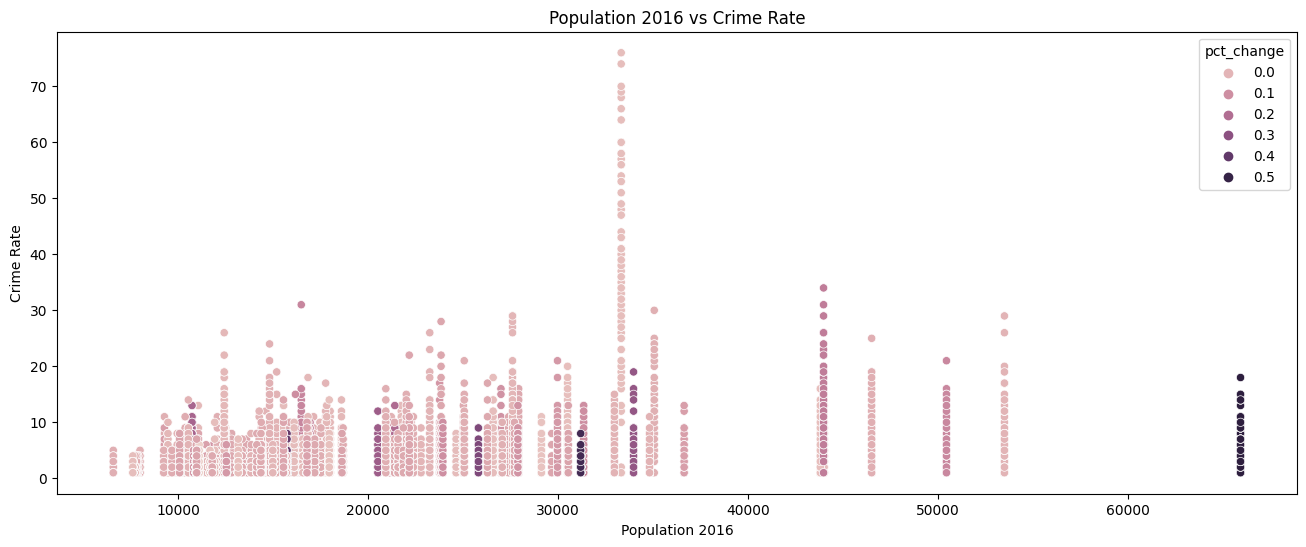

In [52]:
# Are crime rates happening and more populated areas?
plt.figure(figsize=(16, 6))
# Create a scatterplot with Pop2011 on the x-axis and Pop2016 on the y-axis & use the pct_change as the hue
sns.scatterplot(x='Pop2016', y='counts', data=master_agg_df, hue='pct_change')
# Add title and axis labels
plt.title('Population 2016 vs Crime Rate')
plt.xlabel('Population 2016')
plt.ylabel('Crime Rate')
plt.show()


<AxesSubplot:xlabel='Home Prices', ylabel='counts'>

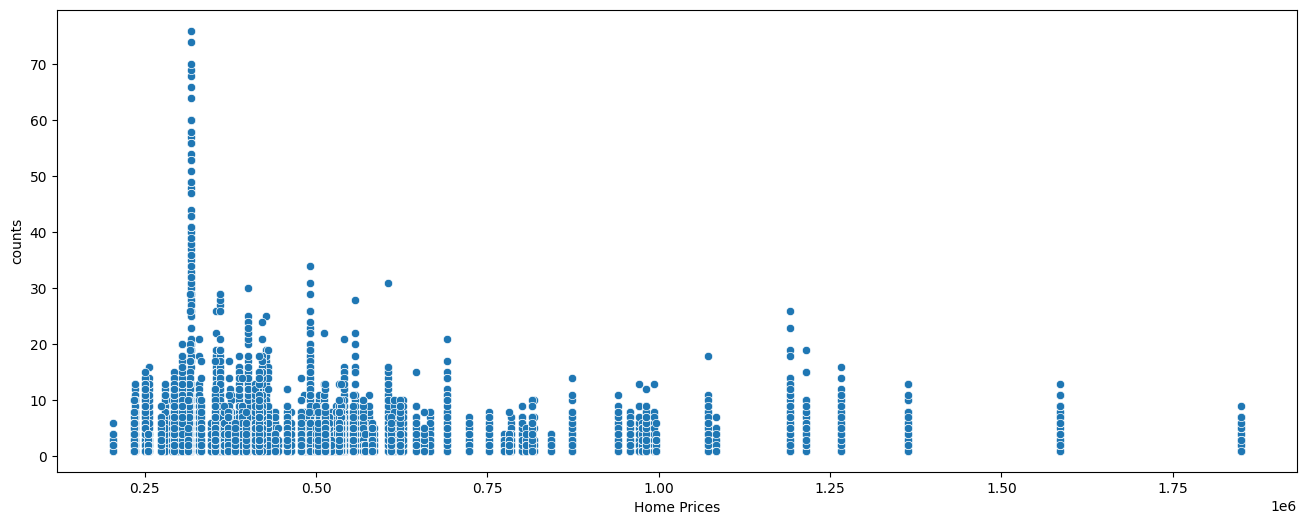

In [53]:
# Are the happening in areas with higher income?
plt.figure(figsize=(16, 6))
# Create a scatterplot with Home Prices on the x-axis and counts on the y-axis
sns.scatterplot(x='Home Prices', y='counts', data=master_agg_df)

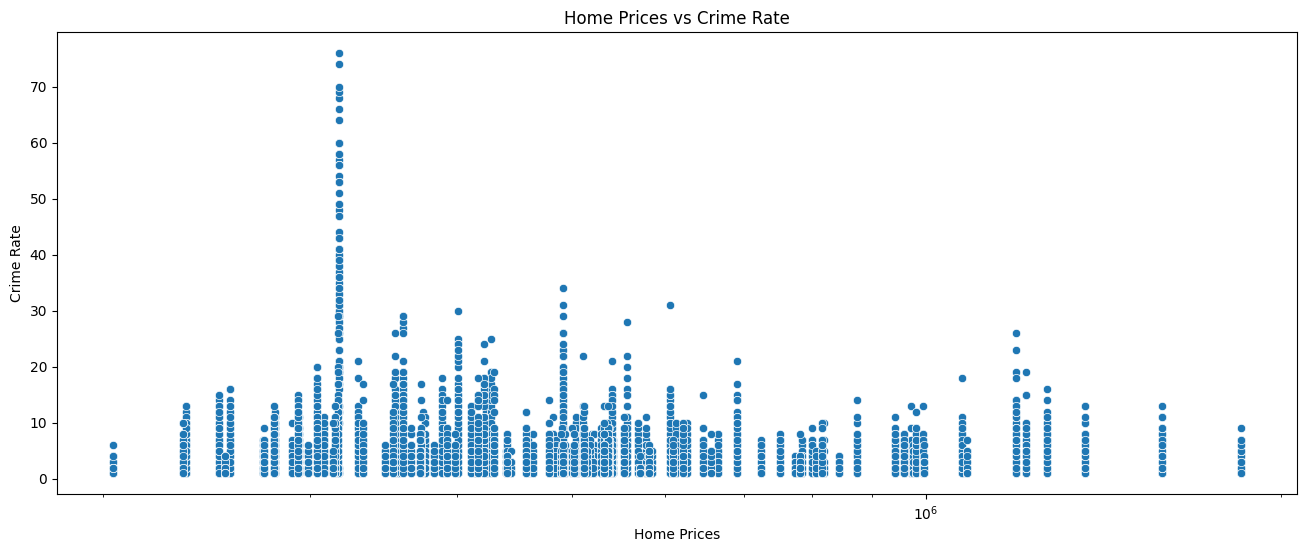

In [54]:
# Try with log home price
plt.figure(figsize=(16, 6))
# Create a scatterplot with Home Prices on the x-axis and counts on the y-axis
sns.scatterplot(x='Home Prices', y='counts', data=master_agg_df)
# Add title and axis labels
plt.title('Home Prices vs Crime Rate')
plt.xlabel('Home Prices')
plt.ylabel('Crime Rate')
plt.xscale('log')
plt.show()

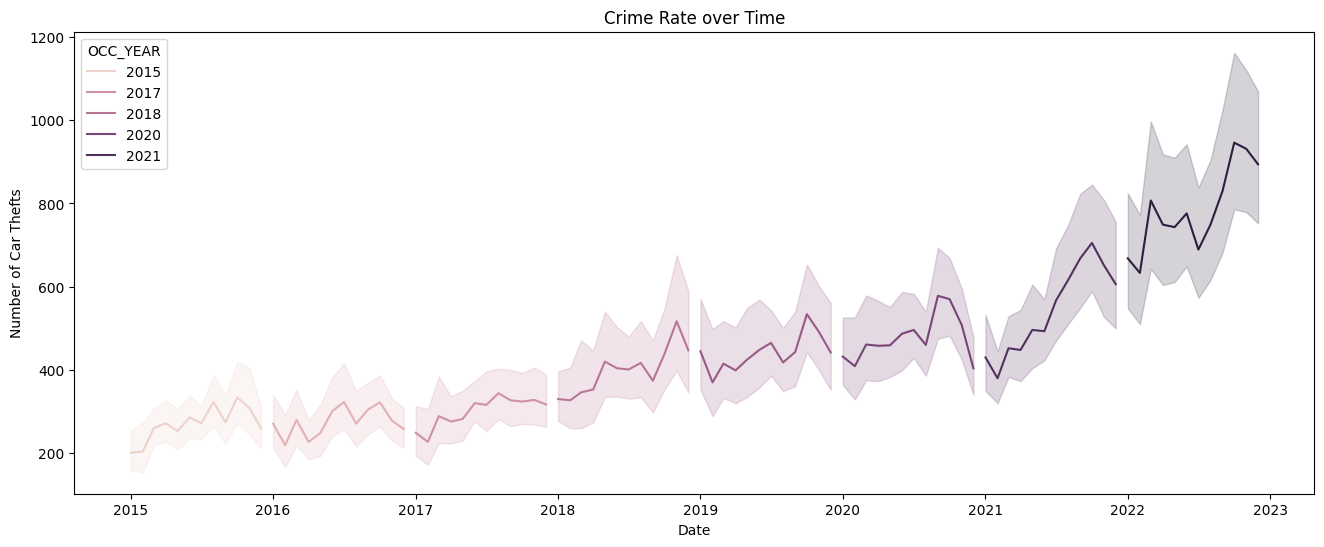

In [55]:
# Is there a pattern between date and crime rate?
# Only use data after 2015
plt_data = master_agg_df[master_agg_df['OCC_YEAR'] >= 2015]
plt.figure(figsize=(16, 6))

# Line plot of master_agg_df with counts as y-axis and DATE as x-axis
sns.lineplot(x='DATE', y='counts', data=plt_data, estimator='sum', 
             hue = 'OCC_YEAR')
# Add title and axis labels
plt.title('Crime Rate over Time')
plt.xlabel('Date')
plt.ylabel('Number of Car Thefts')
plt.show()

In [56]:
decomp_data = plt_data.set_index('DATE')
decomp_data = decomp_data['counts'].resample('M').sum()
decomp_data

DATE
2015-01-31    201
2015-02-28    204
2015-03-31    260
2015-04-30    272
2015-05-31    253
             ... 
2022-08-31    749
2022-09-30    830
2022-10-31    946
2022-11-30    931
2022-12-31    894
Freq: M, Name: counts, Length: 96, dtype: int64

In [57]:
decomposition = sm.tsa.seasonal_decompose(decomp_data, model = "additive", period = 12)


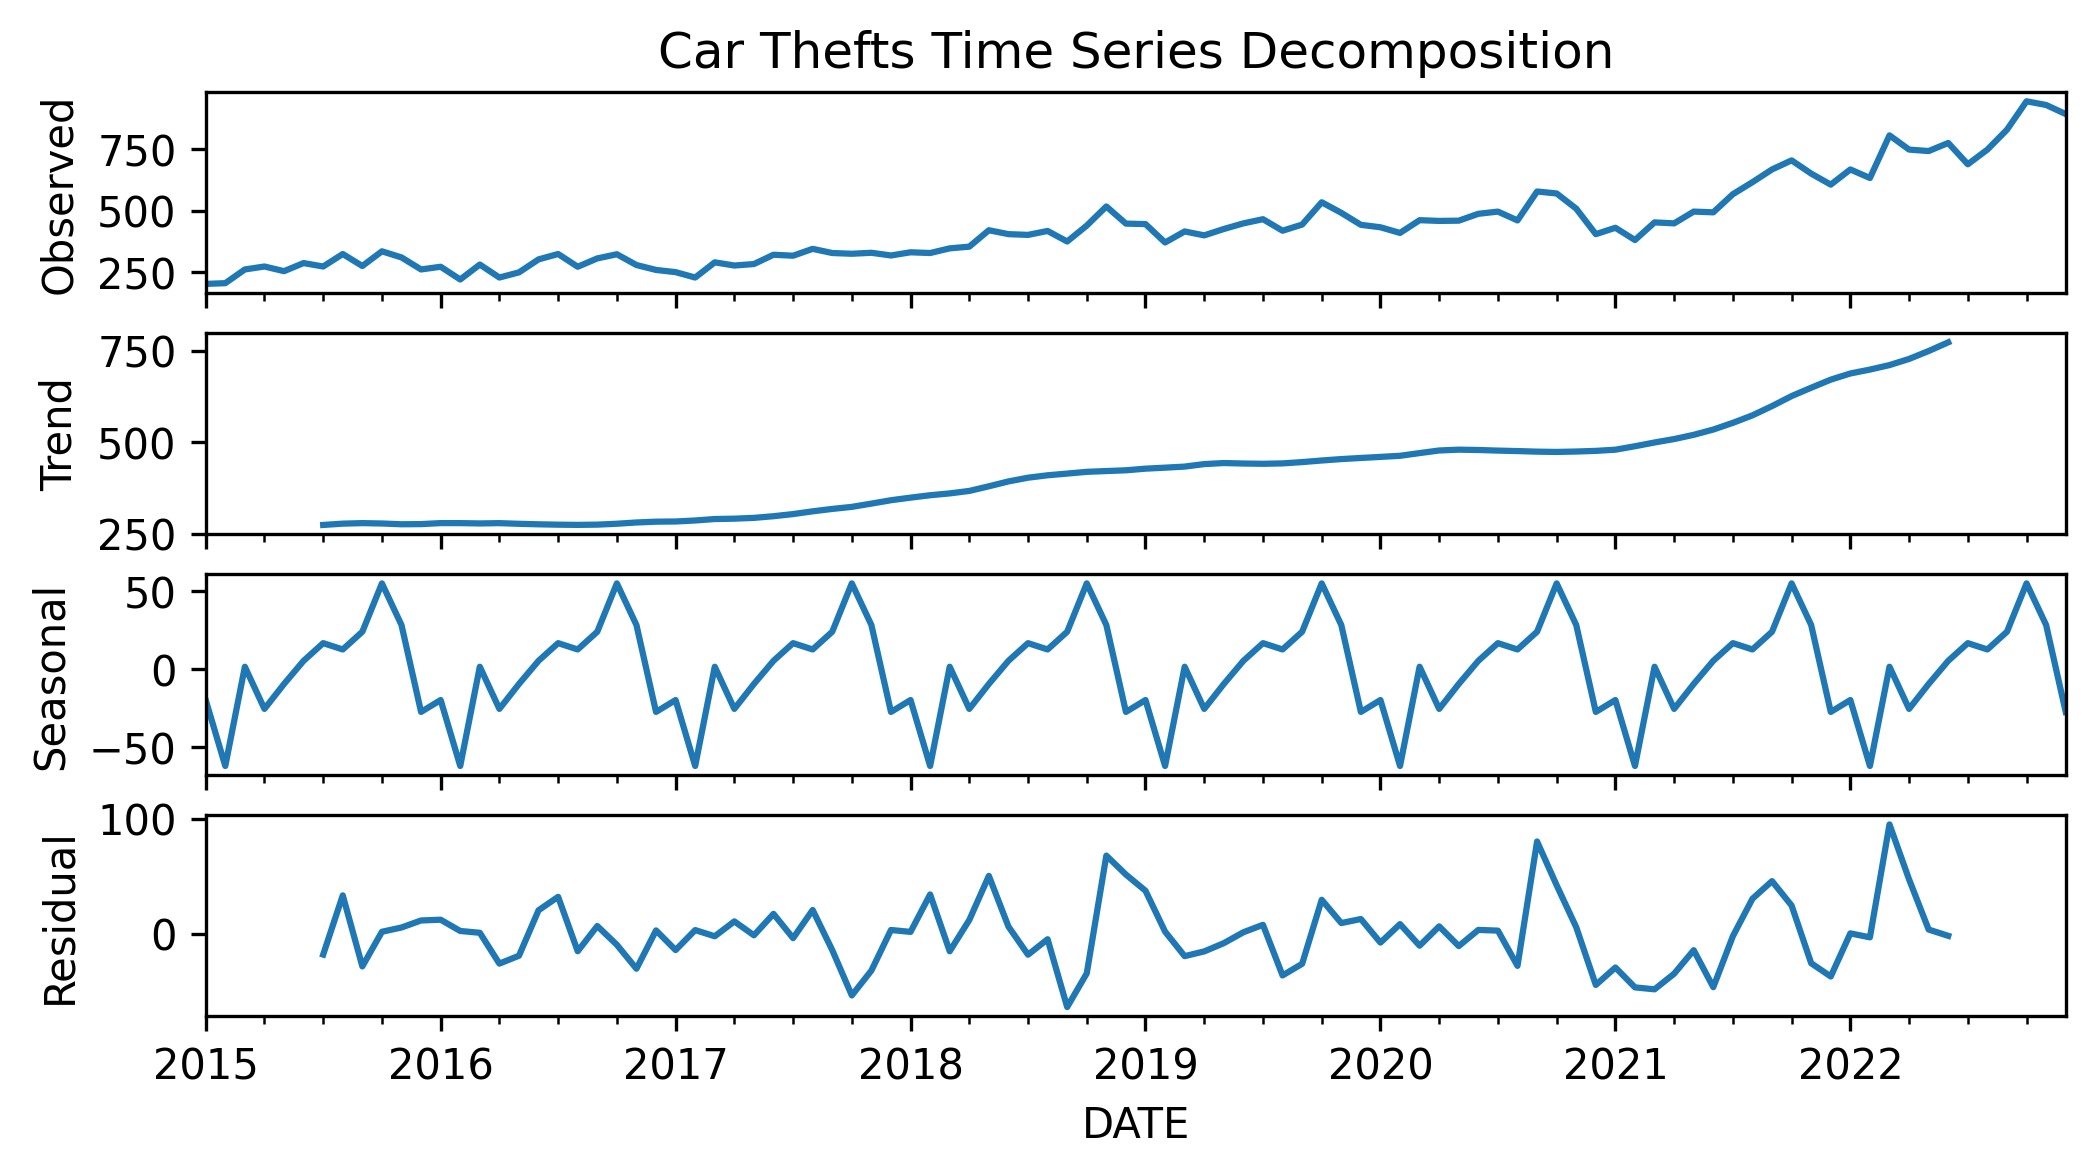

In [58]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize = (8, 4), dpi = 300)
decomposition.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel("Observed")
axes[0].set_title("Car Thefts Time Series Decomposition")
decomposition.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel("Trend")
decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel("Seasonal")
decomposition.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel("Residual")
plt.show()

In [59]:
# So there is a seasonal pattern based on the months, we will use sin() and cos() to capture this
# Create a new column called month_sin which is the sin of the month
master_agg_df['month_sin'] = np.sin((master_agg_df['OCC_MONTH']-1)*(2.*np.pi/12))
# Create a new column called month_cos which is the cos of the month
master_agg_df['month_cos'] = np.cos((master_agg_df['OCC_MONTH']-1)*(2.*np.pi/12))


In [60]:
master_agg_df.columns

Index(['HOOD_140', 'OCC_YEAR', 'OCC_MONTH', 'counts', 'DATE', 'Pop2016',
       'Pop2011', 'pct_change', '0 to 19 years', '20 to 29 years',
       '30 to 39 years', '40 to 49 years', '50 to 59 years', '60 to 69 years',
       '70+ years', 'Businesses', 'Child Care Spaces', 'Debt Risk Score',
       'Local Employment', 'Social Assistance Recipients', 'Home Prices',
       'Mid-Century Highrise Households', 'Mid-Century Highrise Population',
       'Percent Mid-Century Highrise Households',
       'Percent Mid-Century Highrise Population', 'Rent Bank Applicants',
       'Social Housing Turnover', 'Social Housing Units',
       'Social Housing Waiting List', 'month_sin', 'month_cos'],
      dtype='object')

In [61]:
# Let's try to fit a negative binomial regression model
# Create a new dataframe with the columns of interest
df_model = master_agg_df.drop(columns=['OCC_MONTH', 'DATE', 'Pop2011'])
print(df_model.shape[0])
# Drop rows where any of the columns are null
df_model = df_model.dropna()
print(df_model.shape[0])


11719
11719


In [62]:
df_model.head()

HOOD_140  OCC_YEAR  counts  Pop2016  pct_change  0 to 19 years  \
0         1      2001       1    33312   -0.023109           7385   
1         1      2013       1    33312   -0.023109           7385   
2         1      2013       2    33312   -0.023109           7385   
3         1      2013       1    33312   -0.023109           7385   
4         1      2014      28    33312   -0.023109           7385   

   20 to 29 years  30 to 39 years  40 to 49 years  50 to 59 years  ...  \
0            5905            4380            4205            4670  ...   
1            5905            4380            4205            4670  ...   
2            5905            4380            4205            4670  ...   
3            5905            4380            4205            4670  ...   
4            5905            4380            4205            4670  ...   

   Mid-Century Highrise Households  Mid-Century Highrise Population  \
0                              690                             1810   
1                              690                             1810   
2                              690                             1810   
3                              690                             1810   
4                              690                             1810   

   Percent Mid-Century Highrise Households  \
0                                      6.8   
1                                      6.8   
2                                      6.8   
3                                      6.8   
4                                      6.8   

   Percent Mid-Century Highrise Population  Rent Bank Applicants  \
0                                      5.3                    38   
1                                      5.3                    38   
2                                      5.3                    38   
3                                      5.3                    38   
4                                      5.3                    38   

   Social Housing Turnover  Social Housing Units  Social Housing Waiting List  \
0                   0.3125                   952                          557   
1                   0.3125                   952                          557   
2                   0.3125                   952                          557   
3                   0.3125                   952                          557   
4                   0.3125                   952                          557   

   month_sin     month_cos  
0  -1.000000 -1.836970e-16  
1  -0.500000  8.660254e-01  
2   0.000000  1.000000e+00  
3  -0.866025  5.000000e-01  
4   1.000000  6.123234e-17  

[5 rows x 28 columns]

In [63]:
# Apply one hot encoding to HOOD_140
df_model = pd.get_dummies(df_model, columns=['HOOD_140'])
df_model.columns

Index(['OCC_YEAR', 'counts', 'Pop2016', 'pct_change', '0 to 19 years',
       '20 to 29 years', '30 to 39 years', '40 to 49 years', '50 to 59 years',
       '60 to 69 years',
       ...
       'HOOD_140_131', 'HOOD_140_132', 'HOOD_140_133', 'HOOD_140_134',
       'HOOD_140_135', 'HOOD_140_136', 'HOOD_140_137', 'HOOD_140_138',
       'HOOD_140_139', 'HOOD_140_140'],
      dtype='object', length=167)

In [64]:
# Drop the rows where OCC_YEAR is before 2015
df_model = df_model[df_model['OCC_YEAR'] >= 2015]

In [65]:
# Create the X and y variables
X = df_model.drop(columns=['counts'])
y = df_model['counts']
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [112]:
master_agg_df.head()

HOOD_140  OCC_YEAR  OCC_MONTH  counts       DATE  Pop2016  Pop2011  \
0         1      2001         10       1 2001-10-01    33312    34100   
1         1      2013         12       1 2013-12-01    33312    34100   
2         1      2013          1       2 2013-01-01    33312    34100   
3         1      2013         11       1 2013-11-01    33312    34100   
4         1      2014          4      28 2014-04-01    33312    34100   

   pct_change  0 to 19 years  20 to 29 years  ...  \
0   -0.023109           7385            5905  ...   
1   -0.023109           7385            5905  ...   
2   -0.023109           7385            5905  ...   
3   -0.023109           7385            5905  ...   
4   -0.023109           7385            5905  ...   

   Mid-Century Highrise Households  Mid-Century Highrise Population  \
0                              690                             1810   
1                              690                             1810   
2                              690                             1810   
3                              690                             1810   
4                              690                             1810   

   Percent Mid-Century Highrise Households  \
0                                      6.8   
1                                      6.8   
2                                      6.8   
3                                      6.8   
4                                      6.8   

   Percent Mid-Century Highrise Population  Rent Bank Applicants  \
0                                      5.3                    38   
1                                      5.3                    38   
2                                      5.3                    38   
3                                      5.3                    38   
4                                      5.3                    38   

   Social Housing Turnover  Social Housing Units  Social Housing Waiting List  \
0                   0.3125                   952                          557   
1                   0.3125                   952                          557   
2                   0.3125                   952                          557   
3                   0.3125                   952                          557   
4                   0.3125                   952                          557   

   month_sin     month_cos  
0  -1.000000 -1.836970e-16  
1  -0.500000  8.660254e-01  
2   0.000000  1.000000e+00  
3  -0.866025  5.000000e-01  
4   1.000000  6.123234e-17  

[5 rows x 31 columns]

In [66]:
# Fit the model using a log link function
nb2_results = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial()).fit()
nb2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 counts   No. Observations:                 8378
Model:                            GLM   Df Residuals:                     8235
Model Family:        NegativeBinomial   Df Model:                          142
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19542.
Date:                Wed, 19 Jul 2023   Deviance:                       1998.4
Time:                        19:57:24   Pearson chi2:                 2.11e+03
No. Iterations:                   100   Pseudo R-squ. (CS):             0.2879
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
OCC_YEAR                                    0.1155      0.006     20.666      0.000       0.105       0.126
Pop2016                                    -0.0009   6.06e-05    -14.477      0.000      -0.001      -0.001
pct_change                                  2.8396      0.148     19.146      0.000       2.549       3.130
0 to 19 years                               0.0003   4.22e-05      6.358      0.000       0.000       0.000
20 to 29 years                              0.0006   5.88e-05     10.100      0.000       0.000       0.001
30 to 39 years                           4.988e-05   4.46e-05      1.118      0.263   -3.75e-05       0.000
40 to 49 years                              0.0034      0.000     16.181      0.000       0.003       0.004
50 to 59 years                             -0.0008   8.45e-05     -9.069      0.000      -0.001      -0.001
60 to 69 years                              0.0072      0.000     18.445      0.000       0.006       0.008
70+ years                                  -0.0002   3.13e-05     -7.331      0.000      -0.000      -0.000
Businesses                                  0.0003   4.83e-05      5.658      0.000       0.000       0.000
Child Care Spaces                           0.0179      0.001     19.360      0.000       0.016       0.020
Debt Risk Score                            -0.3204      0.016    -20.638      0.000      -0.351      -0.290
Local Employment                         4.785e-05   3.17e-06     15.090      0.000    4.16e-05    5.41e-05
Social Assistance Recipients               -0.0049      0.000    -20.339      0.000      -0.005      -0.004
Home Prices                              7.418e-06   3.56e-07     20.825      0.000    6.72e-06    8.12e-06
Mid-Century Highrise Households            -0.0032      0.000    -20.306      0.000      -0.004      -0.003
Mid-Century Highrise Population             0.0023      0.000     20.118      0.000       0.002       0.003
Percent Mid-Century Highrise Households     0.0219      0.007      3.176      0.001       0.008       0.035
Percent Mid-Century Highrise Population    -0.1048      0.009    -11.451      0.000      -0.123      -0.087
Rent Bank Applicants                       -0.1315      0.007    -18.208      0.000      -0.146      -0.117
Social Housing Turnover                     0.0829      0.007     12.161      0.000       0.070       0.096
Social Housing Units                        0.0015   8.17e-05     18.358      0.000       0.001       0.002
Social Housing Waiting List                -0.0038      0.000    -18.106      0.000      -0.004      -0.003
month_sin                                  -0.0765      0.018     -4.302      0.000      -0.111      -0.042
month_cos                                  -0.0532      0.0

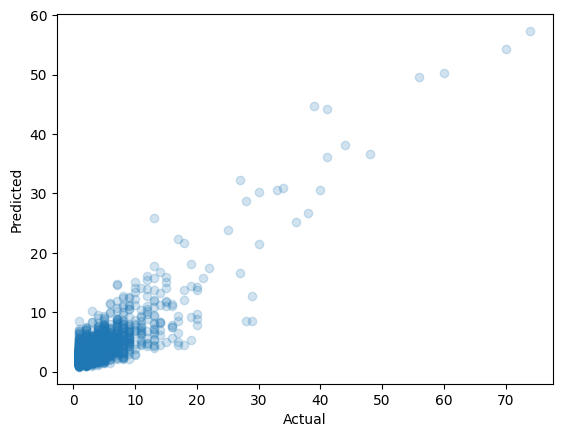

In [67]:
# How does the model perform on the test set?
y_pred = nb2_results.predict(X_test)
# Plot the predicted values vs the actual values
plt.scatter(y_test, y_pred, alpha=0.2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

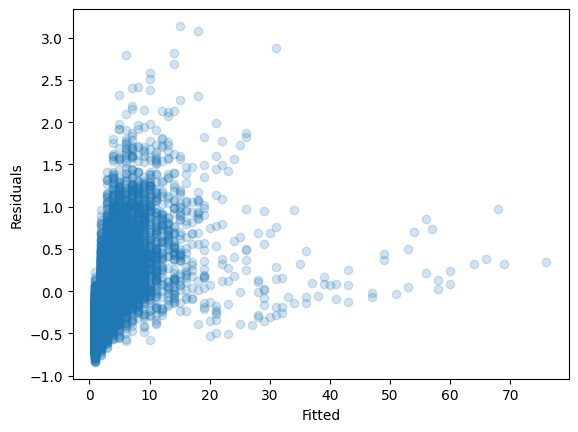

In [68]:
# Check residuals vs fitted values
plt.scatter(y_train, nb2_results.resid_pearson, alpha=0.2)
plt.xlabel('Fitted')
plt.ylabel('Residuals')
plt.show()

In [69]:
nb2_results.resid_pearson

9510    -0.318447
10315    0.266592
3943    -0.055945
11409   -0.520749
7474    -0.181366
           ...   
6445     0.521617
5832     0.670207
6064     0.217776
958     -0.103333
8161    -0.431778
Length: 8378, dtype: float64

In [70]:
# To the index of X_train, join the DATE from master_agg_df
resid_analysis = X_train.join(master_agg_df['DATE'].iloc[X_train.index])
# Now join the residuals to the index
resid_analysis = resid_analysis.join(nb2_results.resid_pearson.to_frame().rename(columns={0: 'resid_pearson'}))
resid_analysis.head()

OCC_YEAR  Pop2016  pct_change  0 to 19 years  20 to 29 years  \
9510       2017    18615    0.043910           3030            3805   
10315      2019    31180    0.465639           2440            8895   
3943       2017    43965    0.154422           7740            6760   
11409      2017    30526    0.046235           3375            7085   
7474       2019    13154   -0.027790           2265            1695   

       30 to 39 years  40 to 49 years  50 to 59 years  60 to 69 years  \
9510             4040            2655            2520            1520   
10315           10905            4155            2480            1455   
3943             7590            5975            6050            4530   
11409            5385            3460            3645            3425   
7474             1110            1615            1930            1770   

       70+ years  ...  HOOD_140_133  HOOD_140_134  HOOD_140_135  HOOD_140_136  \
9510        1040  ...             0             0             0             0   
10315        850  ...             0             0             0             0   
3943        5330  ...             0             0             0             0   
11409       4155  ...             0             0             0             0   
7474        2765  ...             0             0             0             0   

       HOOD_140_137  HOOD_140_138  HOOD_140_139  HOOD_140_140       DATE  \
9510              0             0             0             0 2017-07-01   
10315             0             0             0             0 2019-01-01   
3943              0             0             0             0 2017-06-01   
11409             0             0             0             0 2017-07-01   
7474              0             0             0             0 2019-11-01   

       resid_pearson  
9510       -0.318447  
10315       0.266592  
3943       -0.055945  
11409      -0.520749  
7474       -0.181366  

[5 rows x 168 columns]

<AxesSubplot:xlabel='DATE', ylabel='resid_pearson'>

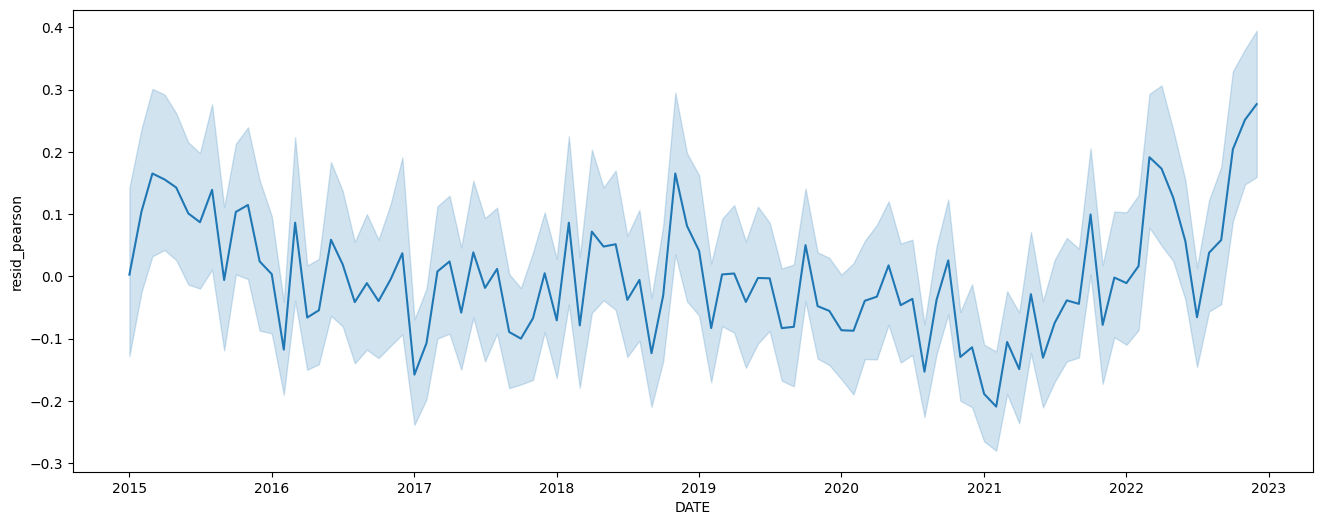

In [71]:
# Plot the residuals vs the DATE
plt.figure(figsize=(16, 6))
sns.lineplot(x='DATE', y='resid_pearson', data=resid_analysis)

In [72]:
# Is there a trend in the residuals?
# Look at a time series decomposition of the residuals
decomp_data = resid_analysis.set_index('DATE')
decomp_data = decomp_data['resid_pearson'].resample('M').sum()
decomp_data

decomposition = sm.tsa.seasonal_decompose(decomp_data, model = "additive", period = 12)


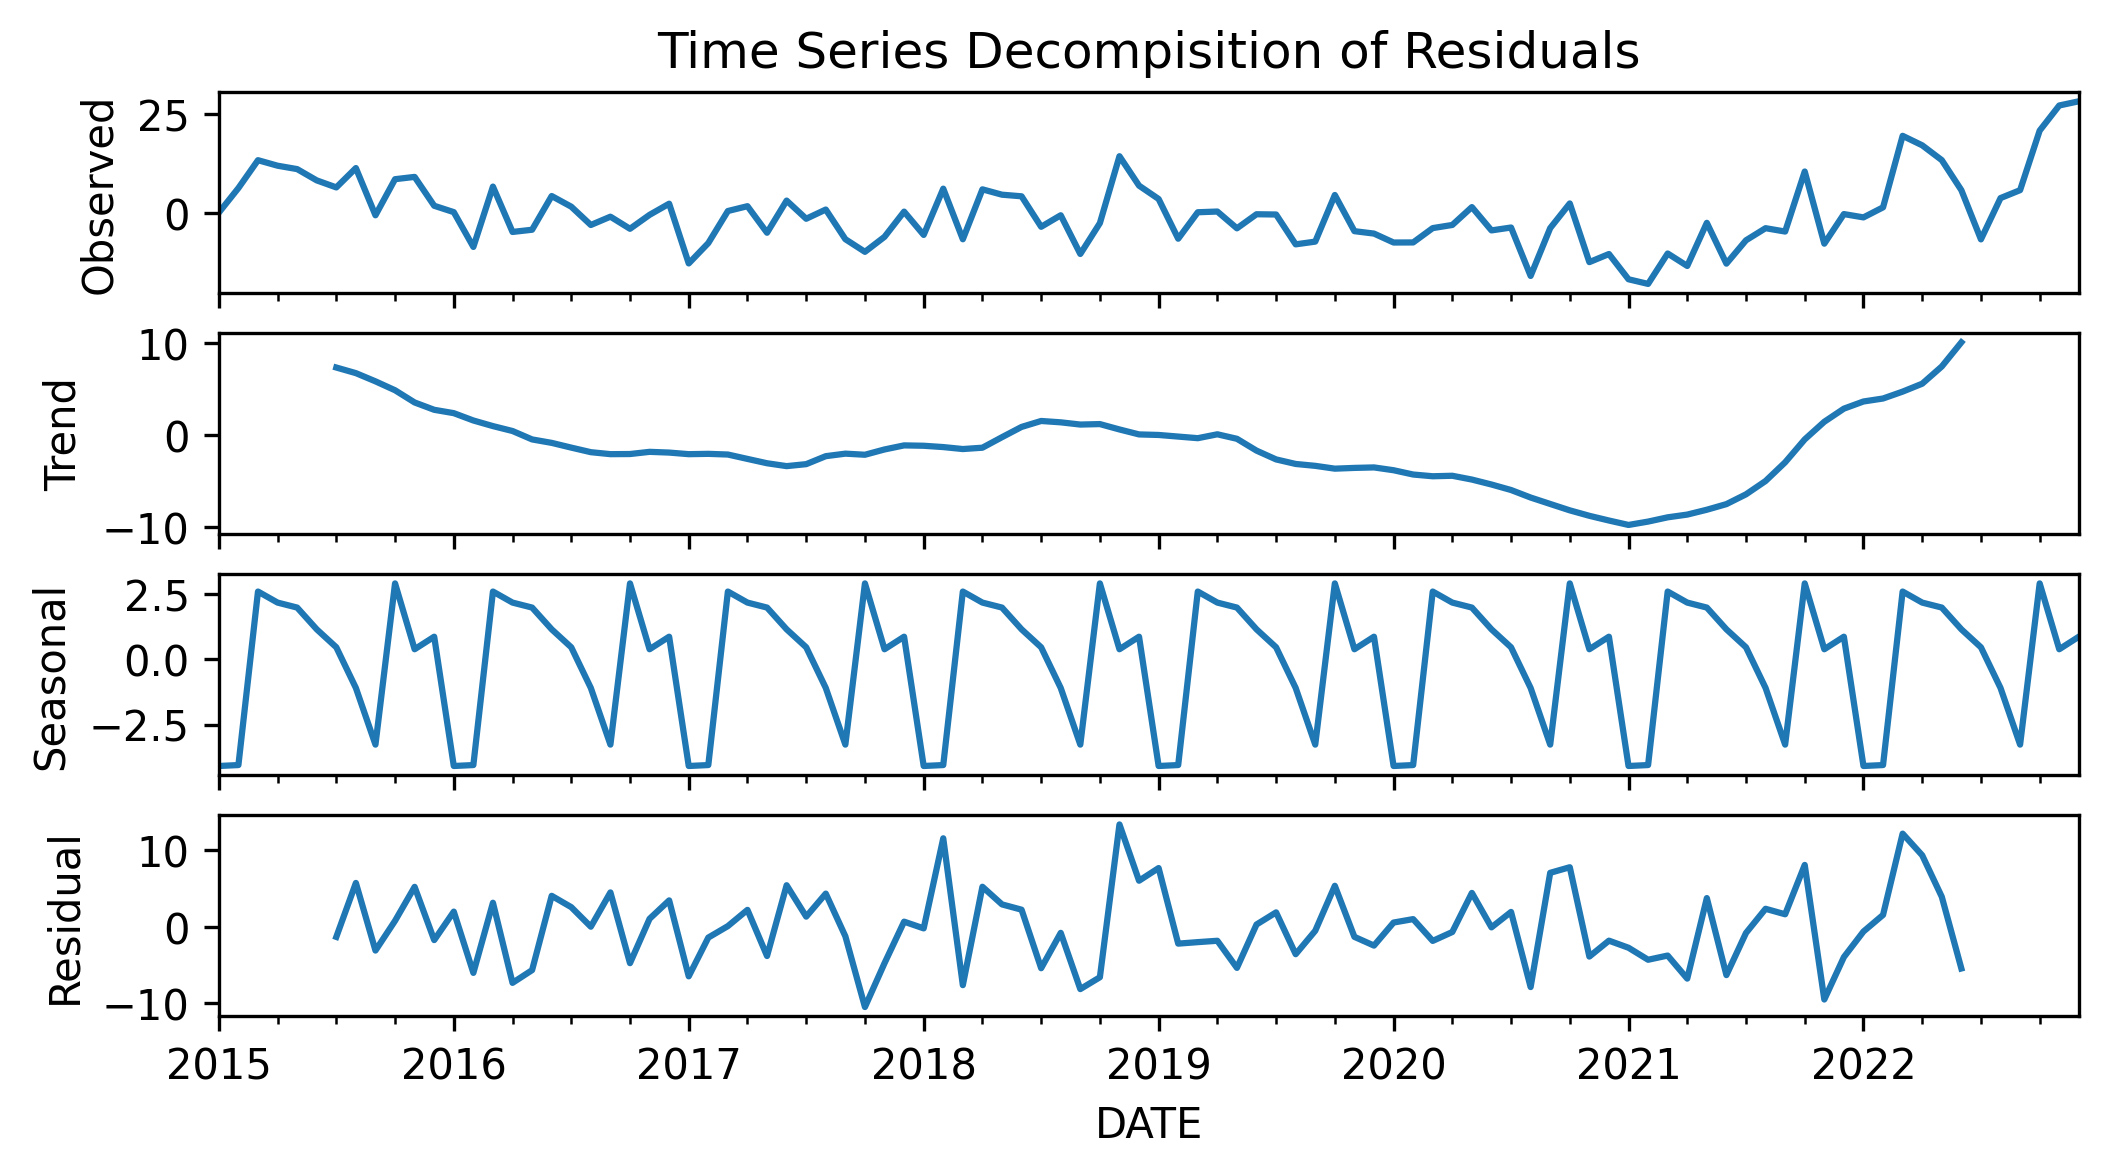

In [73]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize = (8, 4), dpi = 300)
decomposition.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel("Observed")
axes[0].set_title("Time Series Decompisition of Residuals")
decomposition.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel("Trend")
decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel("Seasonal")
decomposition.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel("Residual")
plt.show()

In [92]:
# Let's try to fit an ARIMA model to the counts data
# Create a new dataframe with the columns of interest
arima_df = master_agg_df[['DATE', 'counts']].copy(deep=True)
# Take the sum within each month
arima_df = arima_df.groupby('DATE')['counts'].sum().reset_index(name='counts')
# Drop rows where the DATE is before 2015
arima_df = arima_df[arima_df['DATE'] >= datetime(2015, 1, 1)]
arima_df.head()

DATE  counts
35 2015-01-01     201
36 2015-02-01     204
37 2015-03-01     260
38 2015-04-01     272
39 2015-05-01     253

In [93]:
# Set the DATE as the index
arima_df = arima_df.set_index('DATE')
# Resample the data to be monthly
arima_df = arima_df.resample('M').sum()
arima_df.head()

counts
DATE              
2015-01-31     201
2015-02-28     204
2015-03-31     260
2015-04-30     272
2015-05-31     253

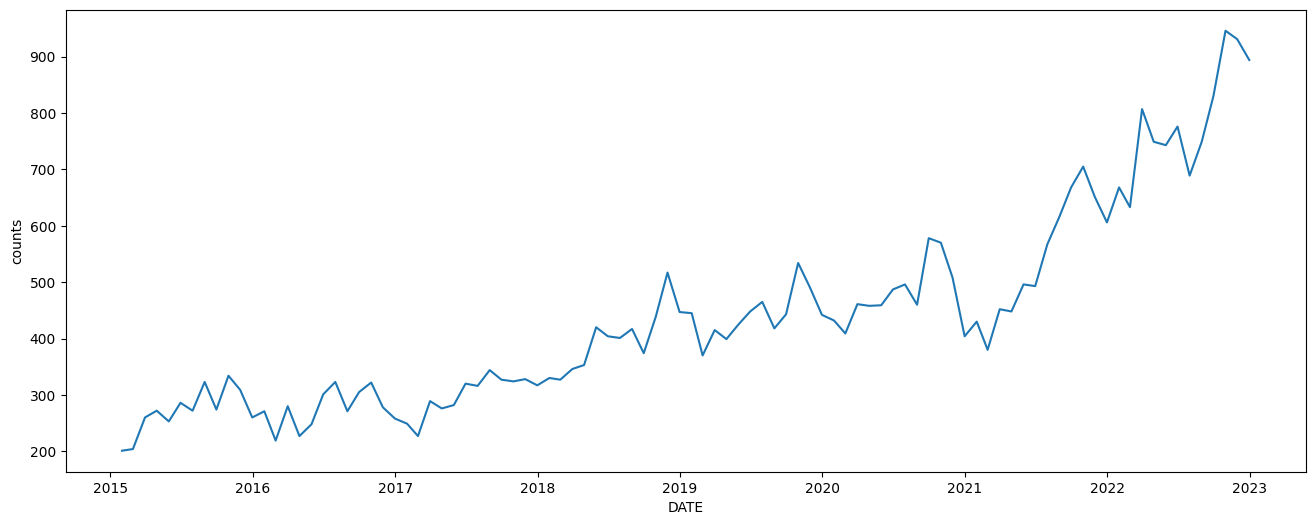

In [94]:
# Plot the data
plt.figure(figsize=(16, 6))
sns.lineplot(x=arima_df.index, y='counts', data=arima_df)
plt.show()

<AxesSubplot:xlabel='DATE', ylabel='counts'>

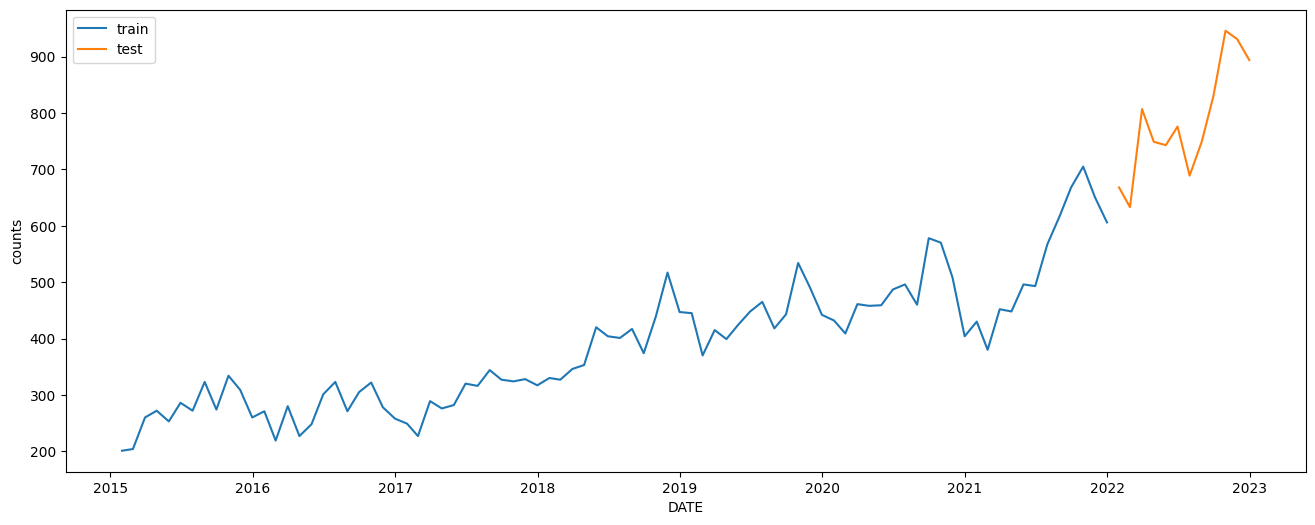

In [95]:
# Let's use 2022 onwards as the test set
arima_train = arima_df[arima_df.index < datetime(2022, 1, 1)]
arima_test = arima_df[arima_df.index >= datetime(2022, 1, 1)]
# Plot the train and test sets
plt.figure(figsize=(16, 6))
sns.lineplot(x=arima_train.index, y='counts', data=arima_train, label='train')
sns.lineplot(x=arima_test.index, y='counts', data=arima_test, label='test')

In [96]:
# Fit an ARIMA model
# We want to test out different values for p, d, q and set s = 12 (for monthly seasonality)
# We will use AIC to determine the best model
# Create a list of all the combinations of p, d, q
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
# Create a list of all the combinations of seasonal p, d, q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]
# We will save the results in a dataframe
results_df = pd.DataFrame(columns=['param', 'param_seasonal', 'AIC'])
# Loop through all the combinations of p, d, q and seasonal p, d, q
for param in pdq:
    # Loop through all the combinations of seasonal p, d, q
    for param_seasonal in seasonal_pdq:
        try:
            # Fit the model
            mod = sm.tsa.statespace.SARIMAX(arima_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            # Save the results in the dataframe
            results_df = results_df.append({'param': param, 'param_seasonal': param_seasonal, 'AIC': results.aic}, ignore_index=True)
            print('ARIMA{} x {} - AIC: {}'.format(param, param_seasonal, results.aic))
        except:
            continue

 This problem is unconstrained.
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.33336D+00    |proj g|=  2.21970D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      2      1     0     0   9.923D-06   7.333D+00
  F =   7.3333436238790508     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0) x (0, 0, 0, 12) - AIC: 1234.0017288116806
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variab

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5     68      5     4     0   6.965D+04   1.547D+01
  F =   15.467711247431309     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 0, 0) x (0, 0, 2, 12) - AIC: 2604.57548956846
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.80411D+00    |proj g|=  2.15649D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explore

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 0, 0) x (0, 2, 1, 12) - AIC: 536.1875522085498
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43374D+00    |proj g|=  2.49131D-01

At iterate    5    f=  2.31880D+00    |proj g|=  6.17833D-02

At iterate   10    f=  2.31606D+00    |proj g|=  2.34758D-03

At iterate   15    f=  2.31123D+00    |proj g|=  6.18312D-02

At iterate   20    f=  2.28832D+00    |proj g|=  4.69872D-03


 This problem is unconstrained.



At iterate   25    f=  2.28777D+00    |proj g|=  6.45503D-03

At iterate   30    f=  2.28756D+00    |proj g|=  2.14845D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32     37      1     0     0   5.166D-06   2.288D+00
  F =   2.2875599499807060     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0) x (0, 2, 2, 12) - AIC: 390.31007159675863
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.64590D+00    |proj g|=  1.98476D-04

           *

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03526D+00    |proj g|=  2.91535D-01

At iterate    5    f=  3.97979D+00    |proj g|=  1.36249D-01

At iterate   10    f=  3.97059D+00    |proj g|=  9.97530D-04

At iterate   15    f=  3.97050D+00    |proj g|=  1.42240D-02

At iterate   20    f=  3.96783D+00    |proj g|=  4.83190D-02

At iterate   25    f=  3.96667D+00    |proj g|=  1.50793D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     34      1     0     0   

 This problem is unconstrained.



At iterate   20    f=  3.16962D+00    |proj g|=  3.52828D-02

At iterate   25    f=  3.16804D+00    |proj g|=  3.85337D-03

At iterate   30    f=  3.16791D+00    |proj g|=  7.79468D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     38      1     0     0   8.631D-06   3.168D+00
  F =   3.1679099778558761     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0) x (1, 1, 2, 12) - AIC: 540.2088762797872
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 0, 0) x (1, 2, 1, 12) - AIC: 537.8576996477462
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43374D+00    |proj g|=  2.49131D-01

At iterate    5    f=  2.33805D+00    |proj g|=  5.51420D-03

At iterate   10    f=  2.31562D+00    |proj g|=  2.99723D-02


 This problem is unconstrained.



At iterate   15    f=  2.31530D+00    |proj g|=  1.20242D-02

At iterate   20    f=  2.30378D+00    |proj g|=  1.86647D-01

At iterate   25    f=  2.28657D+00    |proj g|=  1.97277D-02

At iterate   30    f=  2.28629D+00    |proj g|=  2.48793D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     42      1     0     0   4.945D-06   2.286D+00
  F =   2.2862928188850407     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0) x (1, 2, 2, 12) - AIC: 392.0971935726868
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X

 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.78574D+00    |proj g|=  5.72033D-02

At iterate   25    f=  3.78566D+00    |proj g|=  1.47293D-02

At iterate   30    f=  3.78082D+00    |proj g|=  9.33218D-02

At iterate   35    f=  3.71678D+00    |proj g|=  3.04178D-01

At iterate   40    f=  3.71533D+00    |proj g|=  1.97758D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     47      1     0     0   8.801D-05   3.715D+00
  F =   3.7153296731521537     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0) x (2, 0, 2, 12) - AIC: 634.1753850895618
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.22321D+00    |proj g|=  4.18004D-03

At iterate   15    f=  3.22110D+00    |proj g|=  5.35119D-02

At iterate   20    f=  3.21829D+00    |proj g|=  1.87836D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     25      1     0     0   9.074D-06   3.218D+00
  F =   3.2182923623041431     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0) x (2, 1, 1, 12) - AIC: 548.673116867096


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.40981D+00    |proj g|=  4.84188D-01

At iterate    5    f=  3.25753D+00    |proj g|=  8.82361D-02

At iterate   10    f=  3.17449D+00    |proj g|=  1.76299D-02

At iterate   15    f=  3.17390D+00    |proj g|=  5.74068D-04

At iterate   20    f=  3.17278D+00    |proj g|=  1.39657D-02

At iterate   25    f=  3.16259D+00    |proj g|=  1.74333D-02

At iterate   30    f=  3.16085D+00    |proj g|=  1.62918D-02

At iterate   35    f=  3.15641D+00    |proj g|=  1.15760D-02

At iterate   40    f=  3.15527D+00    |proj g|=  5.61571D-03

At iterate   45    f=  3.15442D+00    |proj g|=  7.05818D-03

At iterate   50    f=  3.15376D+00    |proj g|=  1.27310D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 0) x (2, 1, 2, 12) - AIC: 539.8316737664188
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29905D+00    |proj g|=  5.07057D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      0      1      0     0     0   5.071D-06   2.299D+00
  F =   2.2990509055994215     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0) x (2, 2, 0, 12) - AIC: 392.2405521407028
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.29705D+00    |proj g|=  1.91104D-02

At iterate   10    f=  2.29636D+00    |proj g|=  3.79246D-03

At iterate   15    f=  2.29500D+00    |proj g|=  2.32127D-02

At iterate   20    f=  2.29442D+00    |proj g|=  1.16738D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     26      1     0     0   1.167D-06   2.294D+00
  F =   2.2944153535842333     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0) x (2, 2, 1, 12) - AIC: 393.4617794021512
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X

 This problem is unconstrained.



At iterate   20    f=  2.24285D+00    |proj g|=  3.98756D-02

At iterate   25    f=  2.23396D+00    |proj g|=  1.86870D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     35      1     0     0   2.031D-06   2.234D+00
  F =   2.2339450342479177     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0) x (2, 2, 2, 12) - AIC: 385.3027657536502
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.99174D+00    |proj g|=  6.06926D-01

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  4.57543D+00    |proj g|=  2.45646D-02

At iterate   10    f=  4.55277D+00    |proj g|=  1.13924D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     14     17      1     0     0   1.014D-06   4.550D+00
  F =   4.5495753915383563     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1) x (0, 1, 0, 12) - AIC: 768.3286657784439
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.81771D+00    |proj g|=  1.31426D-01

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 0, 1) x (0, 1, 2, 12) - AIC: 517.7622799034114
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.94256D+00    |proj g|=  3.21384D-02

At iterate    5    f=  3.94207D+00    |proj g|=  3.52773D-03

At iterate   10    f=  3.94137D+00    |proj g|=  2.14440D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     14     17      1     0     0   5.674D-06   3.941D+00
  F =   3.9411242580900172     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 0, 1) x (0, 2, 1, 12) - AIC: 509.8449685186792
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.33490D+00    |proj g|=  1.70328D-01

At iterate    5    f=  2.23923D+00    |proj g|=  8.94338D-02

At iterate   10    f=  2.22088D+00    |proj g|=  3.01303D-03

At iterate   15    f=  2.21248D+00    |proj g|=  5.71788D-02


 This problem is unconstrained.



At iterate   20    f=  2.15881D+00    |proj g|=  1.54875D-02

At iterate   25    f=  2.15776D+00    |proj g|=  3.04794D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     33      1     0     0   3.545D-06   2.158D+00
  F =   2.1576890660371499     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1) x (0, 2, 2, 12) - AIC: 370.4917630942412
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.04190D+00    |proj g|=  7.00557D-01

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   30    f=  4.54484D+00    |proj g|=  2.77113D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32     53      1     0     0   3.666D-06   4.545D+00
  F =   4.5448387732271014     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1) x (1, 0, 0, 12) - AIC: 769.532913902153
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.89156D+00    |proj g|=  6.58717D-01

At iterate    5    f=  5.77995D+00    |proj g|=  3.89040D-03

At iterate   1

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.80311D+00    |proj g|=  2.84870D-03

At iterate   15    f=  3.80039D+00    |proj g|=  4.93667D-02

At iterate   20    f=  3.78589D+00    |proj g|=  6.27216D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     31      1     0     0   2.510D-06   3.786D+00
  F =   3.7858571421116460     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1) x (1, 1, 1, 12) - AIC: 644.0239998747566
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.04394D+00    |proj g|=  4.74254D-03

At iterate   15    f=  3.02145D+00    |proj g|=  1.03180D-01

At iterate   20    f=  2.98972D+00    |proj g|=  2.17979D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     27      1     0     0   2.187D-06   2.990D+00
  F =   2.9897091985277591     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1) x (1, 2, 1, 12) - AIC: 510.2711453526635
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate    5    f=  2.23784D+00    |proj g|=  3.60233D-02

At iterate   10    f=  2.23252D+00    |proj g|=  3.08652D-03

At iterate   15    f=  2.21055D+00    |proj g|=  2.91058D-02

At iterate   20    f=  2.15841D+00    |proj g|=  3.59057D-02

At iterate   25    f=  2.15766D+00    |proj g|=  3.28407D-03

At iterate   30    f=  2.15755D+00    |proj g|=  5.78233D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     42      1     0     0   4.589D-05   2.158D+00
  F =   2.1575499718039262     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1) x (1, 2, 2, 12) - AIC: 372.468395263

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  4.82890D+00    |proj g|=  2.47940D-01

At iterate   30    f=  4.26744D+00    |proj g|=  6.45069D-01

At iterate   35    f=  3.79909D+00    |proj g|=  4.07942D-01

At iterate   40    f=  3.66696D+00    |proj g|=  2.93377D-01

At iterate   45    f=  3.66464D+00    |proj g|=  4.42443D-03

At iterate   50    f=  3.66463D+00    |proj g|=  3.89702D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     71      1     0     0   3.897D-03   3.665D+00
  F =   3.6646259574311051     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(0, 0, 1) x (2, 0, 1, 12) - AIC: 625.657160848

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   20    f=  4.59621D+00    |proj g|=  2.51232D-01

At iterate   25    f=  3.78769D+00    |proj g|=  4.91426D+00

At iterate   30    f=  3.63970D+00    |proj g|=  2.32205D-01

At iterate   35    f=  3.63248D+00    |proj g|=  1.65493D-02

At iterate   40    f=  3.62128D+00    |proj g|=  2.88491D-01

At iterate   45    f=  3.58582D+00    |proj g|=  9.45870D-02

At iterate   50    f=  3.57783D+00    |proj g|=  2.46811D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     76      1     0     0   2.468D-02   3.578D+00
  F =   3.5778342149686844     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 0, 1) x (2, 0, 2, 12) - AIC: 613.076148114739
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.18807D+00    |proj g|=  8.98745D-02

At iterate    5    f=  3.17352D+00    |proj g|=  1.56319D-03

At iterate   10    f=  3.16883D+00    |proj g|=  3.86185D-02

At iterate   15    f=  3.16775D+00    |proj g|=  2.96031D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     20      1     0     0   1.610D-06   3.168D+00
  F =   3.1677497954849412     

CONVERGENCE: N

 This problem is unconstrained.



At iterate   25    f=  2.98495D+00    |proj g|=  6.80056D-02

At iterate   30    f=  2.97968D+00    |proj g|=  1.18166D-02

At iterate   35    f=  2.97959D+00    |proj g|=  3.94982D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     46      1     0     0   4.195D-05   2.980D+00
  F =   2.9795871772906017     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1) x (2, 1, 2, 12) - AIC: 512.5706457848211
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.


ARIMA(0, 0, 1) x (2, 2, 0, 12) - AIC: 390.37462955437724
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.44216D+00    |proj g|=  1.22498D-01

At iterate    5    f=  2.33514D+00    |proj g|=  3.42216D-03

At iterate   10    f=  2.33138D+00    |proj g|=  3.01806D-02

At iterate   15    f=  2.26588D+00    |proj g|=  1.87036D-02


 This problem is unconstrained.



At iterate   20    f=  2.26279D+00    |proj g|=  3.67691D-02

At iterate   25    f=  2.26048D+00    |proj g|=  1.56449D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     34      1     0     0   4.972D-06   2.260D+00
  F =   2.2604751159361545     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1) x (2, 2, 1, 12) - AIC: 389.75981947727394
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.33490D+00    |proj g|=  1.71361D-01


 This problem is unconstrained.



At iterate    5    f=  2.20781D+00    |proj g|=  4.79234D-03

At iterate   10    f=  2.20642D+00    |proj g|=  9.48614D-03

At iterate   15    f=  2.15240D+00    |proj g|=  3.39454D-02

At iterate   20    f=  2.14312D+00    |proj g|=  8.45510D-03

At iterate   25    f=  2.14295D+00    |proj g|=  1.11722D-02

At iterate   30    f=  2.14121D+00    |proj g|=  1.40244D-02

At iterate   35    f=  2.14044D+00    |proj g|=  1.38829D-02

At iterate   40    f=  2.13997D+00    |proj g|=  1.57222D-03

At iterate   45    f=  2.13984D+00    |proj g|=  6.72699D-04


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  2.13980D+00    |proj g|=  7.05306D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     61      1     0     0   7.053D-04   2.140D+00
  F =   2.1397993006108313     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(0, 0, 1) x (2, 2, 2, 12) - AIC: 371.4862825026197
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.99999D+00    |proj g|=  6.70085D-01

At iterate    5    f=  6.75688D+00    |proj g|=  6.08070D-03

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.


  ys=-2.678E-03  -gs= 6.155E-02 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      4     71      2     2     0   9.984D+04   2.621D+01
  F =   26.208215656849976     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 0, 2) x (0, 0, 2, 12) - AIC: 4412.980230350796
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.46483D+00    |proj g|=  6.30808D-02

At iterate    5    f=  4.45868D+00    |proj g|=  2.36517D-02

At iterate   10    f=  4.41367D+00    |proj g|=  9.04742D-02

At iterate   

 This problem is unconstrained.



At iterate   15    f=  2.91051D+00    |proj g|=  7.75641D-03

At iterate   20    f=  2.91031D+00    |proj g|=  9.26915D-03

At iterate   25    f=  2.90979D+00    |proj g|=  7.62021D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     32      1     0     0   1.187D-05   2.910D+00
  F =   2.9097866190198287     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 2) x (0, 1, 2, 12) - AIC: 498.84415199533123
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate  

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 0, 2) x (0, 2, 1, 12) - AIC: 497.5372130993286
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.25839D+00    |proj g|=  2.15808D-01

At iterate    5    f=  2.14374D+00    |proj g|=  2.24755D-02

At iterate   10    f=  2.14190D+00    |proj g|=  3.03740D-03


 This problem is unconstrained.



At iterate   15    f=  2.13685D+00    |proj g|=  3.96809D-02

At iterate   20    f=  2.07916D+00    |proj g|=  1.67230D-02

At iterate   25    f=  2.07886D+00    |proj g|=  2.03367D-03

At iterate   30    f=  2.07884D+00    |proj g|=  9.84799D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     37      1     0     0   9.848D-06   2.079D+00
  F =   2.0788397572739474     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 2) x (0, 2, 2, 12) - AIC: 359.24507922202315
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.71030D+00    |proj g|=  6.18021D-03

At iterate   10    f=  4.70863D+00    |proj g|=  3.04954D-03

At iterate   15    f=  4.69995D+00    |proj g|=  3.95991D-02

At iterate   20    f=  4.56028D+00    |proj g|=  2.27015D-01

At iterate   25    f=  4.03634D+00    |proj g|=  4.83452D-01

At iterate   30    f=  3.79100D+00    |proj g|=  4.50084D-01

At iterate   35    f=  3.51209D+00    |proj g|=  2.52924D-01

At iterate   40    f=  3.48286D+00    |proj g|=  2.75427D-02

At iterate   45    f=  3.48103D+00    |proj g|=  2.76345D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     74   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.69095D+00    |proj g|=  6.66887D-02

At iterate   20    f=  3.66101D+00    |proj g|=  6.16963D-03

At iterate   25    f=  3.66087D+00    |proj g|=  7.34532D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     28      1     0     0   7.345D-06   3.661D+00
  F =   3.6608701701629203     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 2) x (1, 1, 1, 12) - AIC: 625.0261885873706
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.96581D+00    |proj g|=  2.04091D-02

At iterate   10    f=  2.96081D+00    |proj g|=  1.67567D-02

At iterate   15    f=  2.95974D+00    |proj g|=  1.20733D-02

At iterate   20    f=  2.93227D+00    |proj g|=  9.07672D-02

At iterate   25    f=  2.91331D+00    |proj g|=  3.43429D-03

At iterate   30    f=  2.91319D+00    |proj g|=  5.35274D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     35      1     0     0   5.353D-06   2.913D+00
  F =   2.9131923884800037     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 2) x (1, 2, 1, 12) - AIC: 499.416321264

 This problem is unconstrained.



At iterate   15    f=  2.15642D+00    |proj g|=  2.73183D-03

At iterate   20    f=  2.10836D+00    |proj g|=  1.31471D-01

At iterate   25    f=  2.08256D+00    |proj g|=  3.48862D-02

At iterate   30    f=  2.07917D+00    |proj g|=  4.23123D-02

At iterate   35    f=  2.07878D+00    |proj g|=  2.26227D-04

At iterate   40    f=  2.07878D+00    |proj g|=  1.52024D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     57      1     0     0   4.472D-05   2.079D+00
  F =   2.0787801349624337     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 2) x (1, 2, 2, 12) - AIC: 361.235062673

 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 2) x (2, 0, 0, 12) - AIC: 633.8513110338866
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.17038D+00    |proj g|=  4.92608D-01

At iterate    5    f=  4.95823D+00    |proj g|=  6.38253D-03

At iterate   10    f=  4.95626D+00    |proj g|=  4.69188D-03

At iterate   15    f=  4.94794D+00    |proj g|=  1.55092D-02

At iterate   20    f=  4.93052D+00    |proj g|=  2.58445D-02

At iterate   25    f=  4.58784D+00    |proj g|=  7.59728D-01

At iterate   30    f=  4.06543D+00    |proj g|=  6.62658D+00

At iterate   35    f=  3.77028D+00    |proj g|=  5.43618D-01


 This problem is unconstrained.



At iterate   40    f=  3.65211D+00    |proj g|=  9.36569D-02

At iterate   45    f=  3.65175D+00    |proj g|=  2.81385D-03

At iterate   50    f=  3.65147D+00    |proj g|=  7.58694D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     78      1     0     0   7.587D-03   3.651D+00
  F =   3.6514675006224890     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(0, 0, 2) x (2, 0, 1, 12) - AIC: 625.4465401045782
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   30    f=  3.88479D+00    |proj g|=  6.09518D+00

At iterate   35    f=  3.57220D+00    |proj g|=  1.47465D+00

At iterate   40    f=  3.53944D+00    |proj g|=  4.44024D-02

At iterate   45    f=  3.52185D+00    |proj g|=  3.68444D-01

At iterate   50    f=  3.49655D+00    |proj g|=  5.63098D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     81      1     0     0   5.631D-02   3.497D+00
  F =   3.4965529675621334     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(0, 0, 2) x (2, 0, 2, 12) - AIC: 601.4208985504384
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   20    f=  3.08751D+00    |proj g|=  2.23504D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     24      1     0     0   2.474D-06   3.088D+00
  F =   3.0875072142188782     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 2) x (2, 1, 0, 12) - AIC: 528.7012119887715
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13862D+00    |proj g|=  6.02725D-02


 This problem is unconstrained.



At iterate    5    f=  3.13110D+00    |proj g|=  2.75381D-03

At iterate   10    f=  3.12952D+00    |proj g|=  2.44603D-02

At iterate   15    f=  3.12820D+00    |proj g|=  9.92568D-03

At iterate   20    f=  3.11729D+00    |proj g|=  8.09293D-02

At iterate   25    f=  3.09613D+00    |proj g|=  2.04493D-02

At iterate   30    f=  3.09493D+00    |proj g|=  7.28032D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     39      1     0     0   4.375D-06   3.095D+00
  F =   3.0949267625614953     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 2) x (2, 1, 1, 12) - AIC: 531.947696110

 This problem is unconstrained.



At iterate   20    f=  2.82302D+00    |proj g|=  8.11175D-02

At iterate   25    f=  2.81711D+00    |proj g|=  1.25358D-02

At iterate   30    f=  2.81651D+00    |proj g|=  2.47592D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     39      1     0     0   2.551D-06   2.817D+00
  F =   2.8165099188150839     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 2) x (2, 1, 2, 12) - AIC: 487.17366636093413
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate  

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     22      1     0     0   8.222D-07   2.242D+00
  F =   2.2416201753882468     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 2) x (2, 2, 0, 12) - AIC: 386.5921894652255
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.41411D+00    |proj g|=  1.35013D-01


 This problem is unconstrained.



At iterate    5    f=  2.31338D+00    |proj g|=  1.17407D-02

At iterate   10    f=  2.31112D+00    |proj g|=  1.71556D-02

At iterate   15    f=  2.24714D+00    |proj g|=  1.49693D-01

At iterate   20    f=  2.22633D+00    |proj g|=  1.49469D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     25      1     0     0   5.883D-06   2.226D+00
  F =   2.2263263846557777     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 2) x (2, 2, 1, 12) - AIC: 386.02283262217065
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At 

 This problem is unconstrained.



At iterate   10    f=  2.11982D+00    |proj g|=  1.25422D-02

At iterate   15    f=  2.04548D+00    |proj g|=  1.15890D-01

At iterate   20    f=  2.03316D+00    |proj g|=  4.03174D-02

At iterate   25    f=  2.03068D+00    |proj g|=  3.85664D-03

At iterate   30    f=  2.03051D+00    |proj g|=  1.16421D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     41      1     0     0   3.691D-06   2.031D+00
  F =   2.0305115594576941     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 2) x (2, 2, 2, 12) - AIC: 355.1259419888926
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.82927D+00    |proj g|=  2.64944D-02

At iterate   15    f=  2.81576D+00    |proj g|=  3.67487D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     19      1     0     0   3.497D-07   2.816D+00
  F =   2.8157046869418592     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0) x (0, 1, 2, 12) - AIC: 479.03838740623235
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.00539D+00    |proj g|=  4.45542D-03

At iterate  

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 1, 0) x (0, 2, 1, 12) - AIC: 505.11094186525725
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.35823D+00    |proj g|=  1.94857D-01

At iterate    5    f=  2.23027D+00    |proj g|=  5.51239D-02

At iterate   10    f=  2.22564D+00    |proj g|=  9.43666D-03

At iterate   15    f=  2.16023D+00    |proj g|=  1.61529D-02

At iterate   20    f=  2.15970D+00    |proj g|=  3.94882D-03


 This problem is unconstrained.



At iterate   25    f=  2.15966D+00    |proj g|=  1.12155D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     30      1     0     0   1.122D-06   2.160D+00
  F =   2.1596553542136014     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0) x (0, 2, 2, 12) - AIC: 368.82209950788507
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.32188D+00    |proj g|=  4.60076D-06

           * * *

Tit   = total number of iterations
Tnf   = total number 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  4.25503D+00    |proj g|=  4.89913D-03

At iterate   15    f=  4.25493D+00    |proj g|=  8.24354D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     19      1     0     0   8.244D-06   4.255D+00
  F =   4.2549292701683488     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0) x (1, 0, 1, 12) - AIC: 720.8281173882825
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50705D+01    |proj g|=  1.69612D-02
  ys=-5.883E+0

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.52973D+00    |proj g|=  4.28495D-03

At iterate   10    f=  3.51129D+00    |proj g|=  2.18638D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     20      1     0     0   1.254D-05   3.511D+00
  F =   3.5112009794337546     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0) x (1, 1, 1, 12) - AIC: 595.8817645448707
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.90990D+00    |proj g|=  1.92337D-01

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 1, 0) x (1, 2, 1, 12) - AIC: 505.5817847639889
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.35823D+00    |proj g|=  1.94858D-01

At iterate    5    f=  2.25266D+00    |proj g|=  6.59080D-03

At iterate   10    f=  2.22535D+00    |proj g|=  6.09976D-03


 This problem is unconstrained.



At iterate   15    f=  2.22438D+00    |proj g|=  3.95531D-02

At iterate   20    f=  2.18261D+00    |proj g|=  1.61538D-01

At iterate   25    f=  2.15994D+00    |proj g|=  7.68347D-03

At iterate   30    f=  2.15965D+00    |proj g|=  1.81741D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     41      1     0     0   2.688D-06   2.160D+00
  F =   2.1596532341535490     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0) x (1, 2, 2, 12) - AIC: 370.82174333779625
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      5     85      3     2     0   8.175D+04   1.343D+01
  F =   13.433571362112863     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 1, 0) x (2, 0, 2, 12) - AIC: 2266.839988834961
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.85449D+00    |proj g|=  3.97886D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explor

 This problem is unconstrained.


ARIMA(0, 1, 0) x (2, 1, 2, 12) - AIC: 478.71883342346825
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.24353D+00    |proj g|=  4.51226D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      0      1      0     0     0   4.512D-06   2.244D+00
  F =   2.2435250361265999     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0) x (2, 2, 0, 12) - AIC: 382.9122060692688
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.23279D+00    |proj g|=  8.24463D-03

At iterate   15    f=  2.23267D+00    |proj g|=  1.74760D-03

At iterate   20    f=  2.23236D+00    |proj g|=  6.10417D-03

At iterate   25    f=  2.23228D+00    |proj g|=  3.77609D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     31      1     0     0   3.776D-07   2.232D+00
  F =   2.2322758067080821     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0) x (2, 2, 1, 12) - AIC: 383.02233552695776
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At 

 This problem is unconstrained.



At iterate   25    f=  2.16016D+00    |proj g|=  6.71337D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     30      1     0     0   4.555D-06   2.160D+00
  F =   2.1601587050036017     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0) x (2, 2, 2, 12) - AIC: 372.9066624406051
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.97901D+00    |proj g|=  1.78280D-03
ARIMA(0, 1, 1) x (0, 0, 0, 12) - AIC: 840.4547289432313

At iterate    5    

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.35282D+01    |proj g|=  3.96554D+03
  ys=-5.167E+04  -gs= 2.529E+03 BFGS update SKIPPED


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4     60      3     1     0   8.292D+04   1.939D+01
  F =   19.393891947821828     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 1, 1) x (0, 0, 2, 12) - AIC: 3266.173847234067
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.26835D+00    |proj g|=  1.61541D-02

At iterate    5    f=  4.26820D+00    |proj g|=  7.62550D-04

At iterate   10    f=  4.26819D+00    |proj g|=  2.61810D-04

           * 

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 1, 1) x (0, 2, 1, 12) - AIC: 491.73406831919306
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.25291D+00    |proj g|=  1.68739D-01

At iterate    5    f=  2.14613D+00    |proj g|=  7.81537D-02

At iterate   10    f=  2.13881D+00    |proj g|=  2.74076D-03

At iterate   15    f=  2.13309D+00    |proj g|=  3.45240D-02


 This problem is unconstrained.



At iterate   20    f=  2.09458D+00    |proj g|=  9.47737D-03

At iterate   25    f=  2.09443D+00    |proj g|=  4.87808D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     31      1     0     0   4.768D-06   2.094D+00
  F =   2.0944305153482254     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1) x (0, 2, 2, 12) - AIC: 359.8643265785019
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.30524D+00    |proj g|=  4.67200D-02

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


  ys=-2.120E+00  -gs= 6.743E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      5     69      5     4     0   2.298D+04   1.372D+01
  F =   13.715818122777327     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 1, 1) x (1, 0, 2, 12) - AIC: 2314.2574446265908
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.62154D+00    |proj g|=  6.16758D-02

At iterate    5    f=  3.61733D+00    |proj g|=  5.10269D-03

At iterate   10    f= 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.44438D+00    |proj g|=  3.18514D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     31      1     0     0   1.241D-06   3.444D+00
  F =   3.4443766630496775     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1) x (1, 1, 1, 12) - AIC: 586.6552793923458
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.82308D+00    |proj g|=  1.86184D-01

At iterate    5    f=  2.74938D+00    |proj g|=  2.70246D-03

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.88813D+00    |proj g|=  1.31253D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     23      1     0     0   8.838D-06   2.888D+00
  F =   2.8877316776918880     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1) x (1, 2, 1, 12) - AIC: 493.1389218522372
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.25291D+00    |proj g|=  1.68743D-01


 This problem is unconstrained.



At iterate    5    f=  2.16270D+00    |proj g|=  1.14965D-02

At iterate   10    f=  2.13821D+00    |proj g|=  4.90729D-03

At iterate   15    f=  2.13273D+00    |proj g|=  8.71860D-02

At iterate   20    f=  2.10219D+00    |proj g|=  3.56761D-02

At iterate   25    f=  2.09451D+00    |proj g|=  1.64776D-03

At iterate   30    f=  2.09449D+00    |proj g|=  4.21776D-03

At iterate   35    f=  2.09443D+00    |proj g|=  3.47046D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     49      1     0     0   3.509D-05   2.094D+00
  F =   2.0944304805547143     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


  ys=-2.600E+01  -gs= 6.617E-01 BFGS update SKIPPED
  ys=-7.152E+01  -gs= 6.722E-01 BFGS update SKIPPED
  ys=-2.079E+00  -gs= 6.744E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      5     69      5     4     0   2.264D+04   1.359D+01
  F =   13.593582257629421     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 1, 1) x (2, 0, 2, 12) - AIC: 2295.7218192817427
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.85431D+00    |proj g|=  6.61981D-02

At iterate    5    f=  2.84697D+00    |proj g|=  2.67299D-03

At iterate   10    f=  2.84120D+00    |proj g|=  2.08554D-02

At iterate   15    f=  2.83991D+00    |proj g|=  2.70783D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     19      1     0     0   2.708D-06   2.840D+00
  F =   2.8399110292452812     

CONVERGENCE:

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.82308D+00    |proj g|=  2.38826D-01

At iterate    5    f=  2.72960D+00    |proj g|=  3.31185D-02

At iterate   10    f=  2.72670D+00    |proj g|=  3.12719D-03

At iterate   15    f=  2.72017D+00    |proj g|=  9.22409D-03

At iterate   20    f=  2.71944D+00    |proj g|=  3.12936D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     24      1     0     0   1.522D-05   2.719D+00
  F =   2.7194398595330584     

CONVERG

 This problem is unconstrained.


ARIMA(0, 1, 1) x (2, 2, 0, 12) - AIC: 380.05835355532764
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32726D+00    |proj g|=  1.10697D-01

At iterate    5    f=  2.25391D+00    |proj g|=  3.05102D-03

At iterate   10    f=  2.24827D+00    |proj g|=  3.25107D-02

At iterate   15    f=  2.21352D+00    |proj g|=  1.78316D-02


 This problem is unconstrained.



At iterate   20    f=  2.21121D+00    |proj g|=  2.08609D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     24      1     0     0   1.552D-06   2.211D+00
  F =   2.2112109756627483     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1) x (2, 2, 1, 12) - AIC: 381.4834439113417
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.25291D+00    |proj g|=  1.68743D-01


 This problem is unconstrained.



At iterate    5    f=  2.12760D+00    |proj g|=  2.80418D-03

At iterate   10    f=  2.12640D+00    |proj g|=  1.53992D-02

At iterate   15    f=  2.09912D+00    |proj g|=  4.44431D-02

At iterate   20    f=  2.08730D+00    |proj g|=  2.26255D-03

At iterate   25    f=  2.08728D+00    |proj g|=  1.31068D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     28      1     0     0   2.157D-06   2.087D+00
  F =   2.0872792909853941     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1) x (2, 2, 2, 12) - AIC: 362.6629208855462
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  4.92177D+00    |proj g|=  1.04148D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     15      1     0     0   5.830D-06   4.922D+00
  F =   4.9217734372413009     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.12878D+00    |proj g|=  2.47799D-02

At iterate    5    f=  4.12758D+00    |proj g|=  1.00597D-02

At iterate   10    f=  4.11927D+00    |proj g|=  3.66076D-02

       


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7     84      2     2     0   3.328D+03   2.310D+01
  F =   23.096258138074571     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 1, 2) x (0, 0, 2, 12) - AIC: 3890.171367196528
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.19504D+00    |proj g|=  5.56005D-03

At iterate    5    f=  4.19502D+00    |proj g|=  1.27254D-03

At iterate   10    f=  4.19494D+00    |proj g|=  1.16340D-03

           * 

 This problem is unconstrained.



At iterate   15    f=  2.68664D+00    |proj g|=  1.90327D-02

At iterate   20    f=  2.68584D+00    |proj g|=  1.78797D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     23      1     0     0   4.633D-06   2.686D+00
  F =   2.6858373059556682     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2) x (0, 1, 2, 12) - AIC: 461.22066740055226
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.76382D+00    |proj g|=  8.92213D-03

At iterate  

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.89170D+00    |proj g|=  1.39888D-01

At iterate    5    f=  2.86712D+00    |proj g|=  3.11937D-03

At iterate   10    f=  2.84536D+00    |proj g|=  7.52733D-02

At iterate   15    f=  2.82807D+00    |proj g|=  2.42830D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     21      1     0     0   8.005D-06   2.828D+00
  F =   2.8280490440443145     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0,

 This problem is unconstrained.



At iterate   20    f=  2.02734D+00    |proj g|=  1.34088D-03

At iterate   25    f=  2.02730D+00    |proj g|=  1.29608D-03

At iterate   30    f=  2.02727D+00    |proj g|=  7.78670D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     33      1     0     0   7.787D-06   2.027D+00
  F =   2.0272650429083843     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2) x (0, 2, 2, 12) - AIC: 350.58052720860854
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate  

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      5     81      4     2     0   9.711D+04   1.295D+01
  F =   12.948959589242387     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 1, 2) x (1, 0, 2, 12) - AIC: 2187.425210992721
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.61827D+00    |proj g|=  9.63987D-02

At iterate    5    f=  3.60402D+00    |proj g|=  1.37381D-03

At iterate   10    f=  3.60338D+00    |proj g|=  1.20644D-02

At iterate   

 This problem is unconstrained.


ARIMA(0, 1, 2) x (1, 1, 2, 12) - AIC: 462.09858329162626
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12093D+00    |proj g|=  6.48087D-02

At iterate    5    f=  3.11550D+00    |proj g|=  1.04689D-03

At iterate   10    f=  3.11493D+00    |proj g|=  1.54162D-02

At iterate   15    f=  3.11307D+00    |proj g|=  2.88580D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     20      1     0     0   4.956D-06   3.113D+00
  F =   3.1130668595023034     

CONVERGENCE:

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.86459D+00    |proj g|=  3.19478D-03

At iterate   10    f=  2.86181D+00    |proj g|=  3.40546D-02

At iterate   15    f=  2.82420D+00    |proj g|=  3.03186D-02

At iterate   20    f=  2.82302D+00    |proj g|=  4.95828D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     24      1     0     0   5.579D-07   2.823D+00
  F =   2.8230190052390869     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2) x (1, 2, 1, 12) - AIC: 484.2671928801666
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X

 This problem is unconstrained.



At iterate   10    f=  2.06765D+00    |proj g|=  4.75635D-02

At iterate   15    f=  2.06641D+00    |proj g|=  3.65127D-03

At iterate   20    f=  2.03542D+00    |proj g|=  3.85007D-02

At iterate   25    f=  2.02765D+00    |proj g|=  6.39581D-03

At iterate   30    f=  2.02727D+00    |proj g|=  1.28531D-03

At iterate   35    f=  2.02723D+00    |proj g|=  1.13760D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     54      1     0     0   1.617D-05   2.027D+00
  F =   2.0272268784555942     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2) x (1, 2, 2, 12) - AIC: 352.574115580

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


  ys=-8.875E+01  -gs= 6.617E-01 BFGS update SKIPPED

At iterate    5    f=  6.44236D+00    |proj g|=  7.49529D+05
  ys=-4.099E-01  -gs= 1.296E-01 BFGS update SKIPPED
  ys=-2.999E-05  -gs= 1.013E-04 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      7    113      4     4     0   9.714D+05   4.223D+00
  F =   4.2233614324744586     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 1, 2) x (2, 0, 2, 12) - AIC: 723.5247206557091
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exac


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   10    f=  2.83929D+00    |proj g|=  1.92749D-02

At iterate   15    f=  2.83796D+00    |proj g|=  6.45751D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   1.975D-05   2.838D+00
  F =   2.8379585357947983     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2) x (2, 1, 0, 12) - AIC: 486.77703401352613
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.87470D+00    |proj g|=  9.47886D-02

At iterate  

 This problem is unconstrained.



At iterate   10    f=  2.84034D+00    |proj g|=  1.83780D-02

At iterate   15    f=  2.83548D+00    |proj g|=  4.69380D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     22      1     0     0   3.446D-06   2.835D+00
  F =   2.8354760359371451     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2) x (2, 1, 1, 12) - AIC: 488.3599740374404
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.76897D+00    |proj g|=  2.37933D-01


 This problem is unconstrained.



At iterate    5    f=  2.66840D+00    |proj g|=  2.68437D-02

At iterate   10    f=  2.66606D+00    |proj g|=  2.21587D-03

At iterate   15    f=  2.66197D+00    |proj g|=  2.41779D-02

At iterate   20    f=  2.66094D+00    |proj g|=  5.68125D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     22     27      1     0     0   1.015D-06   2.661D+00
  F =   2.6609374444301901     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2) x (2, 1, 2, 12) - AIC: 461.03749066427196
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At 

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     22      1     0     0   1.175D-06   2.215D+00
  F =   2.2145760812185920     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2) x (2, 2, 0, 12) - AIC: 382.0487816447234
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32191D+00    |proj g|=  1.05120D-01


 This problem is unconstrained.



At iterate    5    f=  2.24753D+00    |proj g|=  4.97489D-03

At iterate   10    f=  2.24555D+00    |proj g|=  1.96582D-02

At iterate   15    f=  2.21245D+00    |proj g|=  4.13942D-02

At iterate   20    f=  2.21033D+00    |proj g|=  2.73574D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     25      1     0     0   4.581D-06   2.210D+00
  F =   2.2103301854063711     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2) x (2, 2, 1, 12) - AIC: 383.3354711482703
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X

 This problem is unconstrained.



At iterate   15    f=  2.03885D+00    |proj g|=  3.67196D-02

At iterate   20    f=  2.02599D+00    |proj g|=  4.01341D-03

At iterate   25    f=  2.02586D+00    |proj g|=  1.61507D-03

At iterate   30    f=  2.02584D+00    |proj g|=  9.72498D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     30     35      1     0     0   9.725D-06   2.026D+00
  F =   2.0258376962023346     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2) x (2, 2, 2, 12) - AIC: 354.3407329619922
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.73680D+00    |proj g|=  1.35888D-02

At iterate   15    f=  3.73650D+00    |proj g|=  2.81775D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     15     20      1     0     0   2.818D-07   3.736D+00
  F =   3.7364990611727662     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 0) x (0, 1, 1, 12) - AIC: 631.7318422770247
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09401D+00    |proj g|=  1.92071D-01

At iterate   

 This problem is unconstrained.


ARIMA(0, 2, 0) x (0, 1, 2, 12) - AIC: 506.6278877458518
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.28761D+00    |proj g|=  2.93788D-03

At iterate    5    f=  4.25979D+00    |proj g|=  5.90550D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      5      7      1     0     0   5.905D-07   4.260D+00
  F =   4.2597856262130795     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 0) x (0, 2, 0, 12) - AIC: 717.6439852037973
RUNNING THE L-BFGS-B

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.34673D+00    |proj g|=  9.11701D-03

At iterate   10    f=  2.34581D+00    |proj g|=  9.84787D-03

At iterate   15    f=  2.30557D+00    |proj g|=  1.23797D-01

At iterate   20    f=  2.25245D+00    |proj g|=  3.68989D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     28      1     0     0   1.194D-05   2.252D+00
  F =   2.2522591699982266     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 0) x (0, 2, 2, 12) - AIC: 384.37954055970204
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ARIMA(0, 2, 0) x (1, 0, 2, 12) - AIC: 2747.1862847338925
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.87790D+00    |proj g|=  4.63083D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.631D-06   3.878D+00
  F =   3.8778959510504309     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 0) x (1, 1, 0, 12) - AIC: 655.4865197764724
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =  

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.97974D+00    |proj g|=  2.92998D-02

At iterate   20    f=  2.97732D+00    |proj g|=  2.04582D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     27      1     0     0   3.949D-07   2.977D+00
  F =   2.9773069379620045     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 0) x (1, 1, 2, 12) - AIC: 508.18756557761674
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.34818D+00    |proj g|=  3.56613D-06

           *

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.19230D+00    |proj g|=  6.15374D-03

At iterate   10    f=  3.16904D+00    |proj g|=  8.10715D-02

At iterate   15    f=  3.15007D+00    |proj g|=  4.54124D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     20      1     0     0   8.555D-06   3.150D+00
  F =   3.1500719486557966     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 0) x (1, 2, 1, 12) - AIC: 535.2120873741738
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate   10    f=  2.34608D+00    |proj g|=  1.95682D-03

At iterate   15    f=  2.34476D+00    |proj g|=  3.50863D-02

At iterate   20    f=  2.30408D+00    |proj g|=  1.36544D-01

At iterate   25    f=  2.25424D+00    |proj g|=  5.58551D-02

At iterate   30    f=  2.25225D+00    |proj g|=  5.68414D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     48      1     0     0   6.785D-06   2.252D+00
  F =   2.2521354698605145     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 0) x (1, 2, 2, 12) - AIC: 386.35875893656646
RUNNING THE L-BFGS-B CODE

           * * *

Machine pre

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.82099D+00    |proj g|=  1.58592D-03

At iterate   15    f=  3.81917D+00    |proj g|=  2.72657D-02

At iterate   20    f=  3.81654D+00    |proj g|=  3.21412D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     26      1     0     0   2.257D-06   3.817D+00
  F =   3.8165406088295217     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 0) x (2, 0, 1, 12) - AIC: 649.1788222833596
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      4     58      4     3     0   1.088D+05   1.345D+01
  F =   13.450609210909658     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 2, 0) x (2, 0, 2, 12) - AIC: 2269.7023474328225
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.03104D+00    |proj g|=  4.48814D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explo

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     35      1     0     0   6.619D-06   2.942D+00
  F =   2.9418340083765595     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 0) x (2, 1, 2, 12) - AIC: 504.228113407262
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.36510D+00    |proj g|=  4.72902D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explore

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 2, 0) x (2, 2, 0, 12) - AIC: 403.33722524950315
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.44368D+00    |proj g|=  1.84968D-01

At iterate    5    f=  2.35000D+00    |proj g|=  1.03119D-02

At iterate   10    f=  2.34985D+00    |proj g|=  2.23709D-03

At iterate   15    f=  2.34622D+00    |proj g|=  1.43051D-02

At iterate   20    f=  2.34503D+00    |proj g|=  2.91183D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     26      1     0     0   1.988

 This problem is unconstrained.



At iterate    5    f=  2.34212D+00    |proj g|=  1.90697D-03

At iterate   10    f=  2.34151D+00    |proj g|=  7.43921D-03

At iterate   15    f=  2.31384D+00    |proj g|=  1.07655D-01

At iterate   20    f=  2.27326D+00    |proj g|=  7.50823D-02

At iterate   25    f=  2.25990D+00    |proj g|=  6.72703D-03

At iterate   30    f=  2.25980D+00    |proj g|=  1.50662D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     37      1     0     0   6.829D-06   2.260D+00
  F =   2.2598026658396626     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 0) x (2, 2, 2, 12) - AIC: 389.646847861

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4     73      2     1     0   3.597D+05   1.095D+01
  F =   10.951683764492589     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 2, 1) x (0, 0, 2, 12) - AIC: 1847.882872434755
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.31004D+00    |proj g|=  2.57105D-01

At iterate    5    f=  4.30326D+00    |proj g|=  1.79655D-02

At iterate   10    f=  4.30026D+00    |proj g|=  1.35642D-01

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 2, 1) x (0, 2, 0, 12) - AIC: 654.5576205341893
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.03301D+00    |proj g|=  3.41166D-01

At iterate    5    f=  2.95594D+00    |proj g|=  3.82371D-03

At iterate   10    f=  2.95459D+00    |proj g|=  3.15608D-02

At iterate   15    f=  2.89669D+00    |proj g|=  1.60934D-01

At iterate   20    f=  2.87529D+00    |proj g|=  2.24720D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     27      1     0     0   4.173D

 This problem is unconstrained.



At iterate   20    f=  2.05578D+00    |proj g|=  2.49186D-02

At iterate   25    f=  2.05469D+00    |proj g|=  1.27430D-03

At iterate   30    f=  2.05465D+00    |proj g|=  5.75316D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     39      1     0     0   5.480D-06   2.055D+00
  F =   2.0546534023264802     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 1) x (0, 2, 2, 12) - AIC: 353.18177159084865
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate  

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      4     51      1     1     0   2.291D+05   1.212D+01
  F =   12.115622153385965     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 1) x (1, 0, 2, 12) - AIC: 2045.4245217688422
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.63512D+00    |proj g|=  2.63158D-01

At iterate    5    f=  3.62503D+00    |proj g|=  3.92707D-03

At iterate   10    f=  3.62422D+00    |proj g|=  5.89480D-02

At iterate  

 This problem is unconstrained.


ARIMA(0, 2, 1) x (1, 2, 0, 12) - AIC: 529.2328780767632
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.99744D+00    |proj g|=  2.76899D-01

At iterate    5    f=  2.95671D+00    |proj g|=  3.24805D-02

At iterate   10    f=  2.95396D+00    |proj g|=  3.93481D-03

At iterate   15    f=  2.95012D+00    |proj g|=  7.99048D-02

At iterate   20    f=  2.88594D+00    |proj g|=  1.53895D-01

At iterate   25    f=  2.86997D+00    |proj g|=  6.77893D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     

 This problem is unconstrained.


ARIMA(0, 2, 1) x (1, 2, 1, 12) - AIC: 490.1545844569199
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.23868D+00    |proj g|=  1.60340D-01

At iterate    5    f=  2.15521D+00    |proj g|=  1.54768D-02


 This problem is unconstrained.



At iterate   10    f=  2.13429D+00    |proj g|=  3.42542D-02

At iterate   15    f=  2.13246D+00    |proj g|=  3.12590D-03

At iterate   20    f=  2.13072D+00    |proj g|=  2.44146D-02

At iterate   25    f=  2.07945D+00    |proj g|=  2.37218D-01

At iterate   30    f=  2.05495D+00    |proj g|=  2.41911D-02

At iterate   35    f=  2.05466D+00    |proj g|=  1.76039D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     51      1     0     0   4.845D-05   2.055D+00
  F =   2.0546512027104598     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 1) x (1, 2, 2, 12) - AIC: 355.181402055

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.44238D+01    |proj g|=  1.31890D-02
  ys=-2.568E+03  -gs= 6.662E-01 BFGS update SKIPPED


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      3     63      2     1     0   3.918D+05   1.413D+01
  F =   14.131402159669349     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 2, 1) x (2, 0, 2, 12) - AIC: 2386.0755628244506
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.86334D+00    |proj g|=  2.21875D-01

At iterate    5    f=  2.85230D+00    |proj g|=  4.25406D-03

At iterate   10    f=  2.84994D+00    |proj g|=  3.63542D-02

At iterate  

 This problem is unconstrained.


ARIMA(0, 2, 1) x (2, 1, 1, 12) - AIC: 483.6257979973818
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80097D+00    |proj g|=  1.78308D-01

At iterate    5    f=  2.72641D+00    |proj g|=  4.54559D-02

At iterate   10    f=  2.72497D+00    |proj g|=  6.65122D-03

At iterate   15    f=  2.71207D+00    |proj g|=  1.16858D-01


 This problem is unconstrained.



At iterate   20    f=  2.69461D+00    |proj g|=  4.20425D-03

At iterate   25    f=  2.69458D+00    |proj g|=  5.26077D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     29      1     0     0   5.261D-06   2.695D+00
  F =   2.6945804978304633     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 1) x (2, 1, 2, 12) - AIC: 464.68952363551784
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29166D+00    |proj g|=  2.29237D-01


 This problem is unconstrained.



At iterate    5    f=  2.26793D+00    |proj g|=  2.74185D-03

At iterate   10    f=  2.26389D+00    |proj g|=  2.46645D-02

At iterate   15    f=  2.20760D+00    |proj g|=  4.91262D-02

At iterate   20    f=  2.20589D+00    |proj g|=  3.68616D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     24      1     0     0   3.686D-06   2.206D+00
  F =   2.2058942264629047     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 1) x (2, 2, 0, 12) - AIC: 378.59023004576795
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At 

 This problem is unconstrained.



At iterate   20    f=  2.19844D+00    |proj g|=  2.16423D-02

At iterate   25    f=  2.19709D+00    |proj g|=  9.57487D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     28      1     0     0   9.575D-06   2.197D+00
  F =   2.1970878204448221     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 1) x (2, 2, 1, 12) - AIC: 379.11075383473013
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.23868D+00    |proj g|=  1.60340D-01

At iterate  

 This problem is unconstrained.



At iterate   15    f=  2.10161D+00    |proj g|=  5.72704D-02

At iterate   20    f=  2.06238D+00    |proj g|=  3.62109D-02

At iterate   25    f=  2.05725D+00    |proj g|=  5.51908D-03

At iterate   30    f=  2.05704D+00    |proj g|=  6.50746D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     36      1     0     0   4.186D-06   2.057D+00
  F =   2.0570424875523008     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 1) x (2, 2, 2, 12) - AIC: 357.5831379087865
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.28053D+01    |proj g|=  1.40893D+05
  ys=-1.466E+00  -gs= 5.252E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6     87      3     3     0   1.409D+05   1.281D+01
  F =   12.805326418257033     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 2, 2) x (0, 0, 2, 12) - AIC: 2161.2948382671816
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.18942D+00    |proj g|=  9.13498D-02

At iterate    5    f= 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 2, 2) x (0, 1, 0, 12) - AIC: 706.2641378968993
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.37690D+00    |proj g|=  6.14595D-02

At iterate    5    f=  3.37220D+00    |proj g|=  9.56559D-03

At iterate   10    f=  3.37139D+00    |proj g|=  1.99941D-02

At iterate   15    f=  3.35784D+00    |proj g|=  1.88634D-01

At iterate   20    f=  3.35069D+00    |proj g|=  8.68607D-02

At iterate   25    f=  3.34851D+00    |proj g|=  1.95219D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     

 This problem is unconstrained.



At iterate   10    f=  2.65343D+00    |proj g|=  8.82626D-03

At iterate   15    f=  2.64999D+00    |proj g|=  6.61385D-02

At iterate   20    f=  2.63440D+00    |proj g|=  2.23458D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     28      1     0     0   3.610D-05   2.634D+00
  F =   2.6342249516470995     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 2) x (0, 1, 2, 12) - AIC: 452.54979187671273
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.73621D+00    |proj g|=  1.11027D-02

At iterate   10    f=  3.73617D+00    |proj g|=  2.65658D-03

At iterate   15    f=  3.73570D+00    |proj g|=  4.62196D-02

At iterate   20    f=  3.73334D+00    |proj g|=  1.08460D-03

At iterate   25    f=  3.73331D+00    |proj g|=  1.44222D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     30      1     0     0   2.837D-05   3.733D+00
  F =   3.7333104591649340     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 2) x (0, 2, 0, 12) - AIC: 633.1961571397089
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.



At iterate    5    f=  2.05677D+00    |proj g|=  7.09870D-02

At iterate   10    f=  2.03731D+00    |proj g|=  1.68790D-02

At iterate   15    f=  2.03560D+00    |proj g|=  6.47435D-03

At iterate   20    f=  2.01741D+00    |proj g|=  6.89224D-02

At iterate   25    f=  1.98468D+00    |proj g|=  9.82878D-03

At iterate   30    f=  1.98448D+00    |proj g|=  3.42958D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     41      1     0     0   6.923D-07   1.984D+00
  F =   1.9844776295445221     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 2) x (0, 2, 2, 12) - AIC: 343.392241763

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


  ys=-2.314E+01  -gs= 6.372E-01 BFGS update SKIPPED

At iterate    5    f=  1.24357D+01    |proj g|=  1.68603D+05
  ys=-1.702E+00  -gs= 5.075E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      6     87      3     3     0   1.686D+05   1.244D+01
  F =   12.435680878156358     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 2, 2) x (1, 0, 2, 12) - AIC: 2101.194387530268
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.59955D+00    |proj g|=  6.90116D-02

At iterate    5    f=  3.59191D+00    |proj g|=  3.55165D-03

At iterate   10    f=  3.59039D+00    |proj g|=  2.88134D-02

At iterate   

 This problem is unconstrained.



At iterate   10    f=  2.64780D+00    |proj g|=  1.52436D-02

At iterate   15    f=  2.64656D+00    |proj g|=  6.86318D-02

At iterate   20    f=  2.63299D+00    |proj g|=  9.48389D-02

At iterate   25    f=  2.62556D+00    |proj g|=  8.10422D-03

At iterate   30    f=  2.62552D+00    |proj g|=  1.40701D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     36      1     0     0   1.859D-04   2.626D+00
  F =   2.6255184261036355     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 2) x (1, 1, 2, 12) - AIC: 453.0870955854108
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.


ARIMA(0, 2, 2) x (1, 2, 0, 12) - AIC: 525.1433542950183
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.86628D+00    |proj g|=  7.99759D-02

At iterate    5    f=  2.84347D+00    |proj g|=  4.75746D-02

At iterate   10    f=  2.84243D+00    |proj g|=  4.71150D-03

At iterate   15    f=  2.80690D+00    |proj g|=  1.53267D-01


 This problem is unconstrained.



At iterate   20    f=  2.78411D+00    |proj g|=  3.19996D-03

At iterate   25    f=  2.78410D+00    |proj g|=  7.60243D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     37      1     0     0   6.789D-07   2.784D+00
  F =   2.7841021235416257     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 2) x (1, 2, 1, 12) - AIC: 477.72915675499314
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.12877D+00    |proj g|=  1.62508D-01

At iterate  

 This problem is unconstrained.



At iterate   15    f=  2.05134D+00    |proj g|=  8.17383D-03

At iterate   20    f=  2.03452D+00    |proj g|=  2.80631D-02

At iterate   25    f=  2.03253D+00    |proj g|=  5.17749D-03

At iterate   30    f=  2.03172D+00    |proj g|=  5.73668D-02

At iterate   35    f=  1.99885D+00    |proj g|=  6.32457D-01

At iterate   40    f=  1.98468D+00    |proj g|=  1.45650D-02

At iterate   45    f=  1.98447D+00    |proj g|=  7.29492D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     62      1     0     0   2.741D-04   1.984D+00
  F =   1.9844677107659199     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.54887D+00    |proj g|=  5.11451D-02

At iterate   25    f=  3.52564D+00    |proj g|=  1.99469D-02

At iterate   30    f=  3.52552D+00    |proj g|=  2.83313D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     36      1     0     0   8.640D-06   3.526D+00
  F =   3.5255228278079320     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 2) x (2, 0, 1, 12) - AIC: 604.2878350717326
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate    5    f=  1.21436D+01    |proj g|=  1.68951D+05
  ys=-1.705E+00  -gs= 5.073E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      6     64      2     3     0   1.690D+05   1.214D+01
  F =   12.143572161402410     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 2) x (2, 0, 2, 12) - AIC: 2054.1201231156047
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83442D+00    |proj g|=  8.51013D-02

At iterate    5    f= 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  2.81356D+00    |proj g|=  6.33407D-02

At iterate   20    f=  2.81082D+00    |proj g|=  3.35802D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     27      1     0     0   1.303D-05   2.811D+00
  F =   2.8108208040014384     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 2) x (2, 1, 0, 12) - AIC: 482.2178950722416
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83535D+00    |proj g|=  8.01043D-02

At iterate   

 This problem is unconstrained.



At iterate   20    f=  2.80962D+00    |proj g|=  3.06581D-03

At iterate   25    f=  2.80960D+00    |proj g|=  6.09841D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     31      1     0     0   6.098D-06   2.810D+00
  F =   2.8095989406621538     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 2) x (2, 1, 1, 12) - AIC: 484.01262203124185
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.71160D+00    |proj g|=  2.50984D-01

At iterate  

 This problem is unconstrained.



At iterate   25    f=  2.60451D+00    |proj g|=  8.47641D-02

At iterate   30    f=  2.60172D+00    |proj g|=  1.81128D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     37      1     0     0   4.499D-06   2.602D+00
  F =   2.6017188891004630     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 2) x (2, 1, 2, 12) - AIC: 451.08877336887775
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.23728D+00    |proj g|=  4.98424D-02

At iterate  

 This problem is unconstrained.



At iterate   15    f=  2.18497D+00    |proj g|=  3.22117D-02

At iterate   20    f=  2.18349D+00    |proj g|=  2.95275D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     27      1     0     0   2.265D-06   2.183D+00
  F =   2.1834783857788058     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 2) x (2, 2, 0, 12) - AIC: 376.82436881083936
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.26041D+00    |proj g|=  9.50388D-02

At iterate  

 This problem is unconstrained.



At iterate   15    f=  2.20134D+00    |proj g|=  6.61126D-02

At iterate   20    f=  2.18162D+00    |proj g|=  1.17110D-02

At iterate   25    f=  2.18074D+00    |proj g|=  2.19361D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     31      1     0     0   2.454D-06   2.181D+00
  F =   2.1807374878942234     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 2) x (2, 2, 1, 12) - AIC: 378.36389796622956
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate  

 This problem is unconstrained.



At iterate   10    f=  2.02618D+00    |proj g|=  4.56956D-03

At iterate   15    f=  2.02453D+00    |proj g|=  1.03505D-02

At iterate   20    f=  1.98550D+00    |proj g|=  3.20205D-02

At iterate   25    f=  1.97087D+00    |proj g|=  1.68347D-02

At iterate   30    f=  1.96914D+00    |proj g|=  5.00088D-03

At iterate   35    f=  1.96912D+00    |proj g|=  1.53664D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     42      1     0     0   3.716D-06   1.969D+00
  F =   1.9691158308746444     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 2, 2) x (2, 2, 2, 12) - AIC: 344.811459586

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluatio


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6     85      4     2     0   1.228D+05   1.450D+01
  F =   14.497480685476896     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 0, 0) x (0, 0, 2, 12) - AIC: 2443.5767551601184
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.42490D+00    |proj g|=  9.20091D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explo

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.25394D+00    |proj g|=  4.13463D-02

At iterate   10    f=  2.25196D+00    |proj g|=  3.32839D-03

At iterate   15    f=  2.21901D+00    |proj g|=  1.19190D-01

At iterate   20    f=  2.18812D+00    |proj g|=  3.44992D-03

At iterate   25    f=  2.18809D+00    |proj g|=  1.96476D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     31      1     0     0   4.731D-06   2.188D+00
  F =   2.1880847360038320     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0) x (0, 2, 2, 12) - AIC: 375.59823564864377
RUNNING THE L-BFGS-B CODE

           * * *

Machine pre

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.58556D+00    |proj g|=  1.39677D-02

At iterate   25    f=  3.57857D+00    |proj g|=  3.14394D-02

At iterate   30    f=  3.57694D+00    |proj g|=  8.82629D-03

At iterate   35    f=  3.57654D+00    |proj g|=  4.99029D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     61      1     0     0   1.559D-05   3.577D+00
  F =   3.5765346730976133     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0) x (1, 0, 2, 12) - AIC: 610.857825080399
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 0, 0) x (1, 1, 1, 12) - AIC: 606.7441845725691
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95722D+00    |proj g|=  1.50408D-01

At iterate    5    f=  2.88325D+00    |proj g|=  7.89451D-03

At iterate   10    f=  2.88172D+00    |proj g|=  6.32015D-03

At iterate   15    f=  2.87174D+00    |proj g|=  3.83724D-02

At iterate   20    f=  2.86733D+00    |proj g|=  2.75399D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     27      1     0     0   4.744D

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.99810D+00    |proj g|=  1.43897D-02

At iterate   20    f=  2.99795D+00    |proj g|=  4.73079D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     24      1     0     0   4.731D-06   2.998D+00
  F =   2.9979549380565409     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0) x (1, 2, 1, 12) - AIC: 511.6564295934989
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.38640D+00    |proj g|=  1.94660D-01

At iterate   

 This problem is unconstrained.



At iterate   10    f=  2.25531D+00    |proj g|=  6.59571D-02

At iterate   15    f=  2.25110D+00    |proj g|=  5.73785D-03

At iterate   20    f=  2.21319D+00    |proj g|=  1.41801D-01

At iterate   25    f=  2.18827D+00    |proj g|=  1.58276D-02

At iterate   30    f=  2.18806D+00    |proj g|=  1.01959D-02

At iterate   35    f=  2.18802D+00    |proj g|=  1.28041D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     50      1     0     0   3.691D-06   2.188D+00
  F =   2.1880242977555975     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0) x (1, 2, 2, 12) - AIC: 377.588082022

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.57506D+00    |proj g|=  2.82708D-02

At iterate   10    f=  3.57313D+00    |proj g|=  3.85632D-03

At iterate   15    f=  3.57105D+00    |proj g|=  2.11180D-02

At iterate   20    f=  3.55667D+00    |proj g|=  6.98759D-02

At iterate   25    f=  3.55603D+00    |proj g|=  3.09121D-03

At iterate   30    f=  3.55600D+00    |proj g|=  2.24211D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     38      1     0     0   3.744D-05   3.556D+00
  F =   3.5559963555298642     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0) x (2, 0, 2, 12) - AIC: 609.407387729

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 0, 0) x (2, 1, 0, 12) - AIC: 486.8140837104322
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.98302D+00    |proj g|=  2.04453D-01

At iterate    5    f=  2.87144D+00    |proj g|=  5.83305D-02

At iterate   10    f=  2.85760D+00    |proj g|=  3.21279D-03

At iterate   15    f=  2.85485D+00    |proj g|=  4.01775D-02

At iterate   20    f=  2.84588D+00    |proj g|=  1.85070D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     29      1     0     0   3.229D

 This problem is unconstrained.


ARIMA(1, 0, 0) x (2, 1, 2, 12) - AIC: 489.00273606091395
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.24778D+00    |proj g|=  5.99104D-02

At iterate    5    f=  2.24215D+00    |proj g|=  4.53196D-03

At iterate   10    f=  2.20635D+00    |proj g|=  8.60785D-02

At iterate   15    f=  2.19368D+00    |proj g|=  6.18586D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     19      1     0     0   8.267D-06   2.194D+00
  F =   2.1936767920330911     

CONVERGENCE:

 This problem is unconstrained.


ARIMA(1, 0, 0) x (2, 2, 0, 12) - AIC: 376.5377010615593
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.34639D+00    |proj g|=  1.05543D-01

At iterate    5    f=  2.23884D+00    |proj g|=  3.42347D-03

At iterate   10    f=  2.23602D+00    |proj g|=  2.79202D-02


 This problem is unconstrained.



At iterate   15    f=  2.18528D+00    |proj g|=  1.16747D-02

At iterate   20    f=  2.18474D+00    |proj g|=  3.48815D-02

At iterate   25    f=  2.17986D+00    |proj g|=  6.96220D-03

At iterate   30    f=  2.17938D+00    |proj g|=  2.59027D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     48      1     0     0   9.628D-06   2.179D+00
  F =   2.1793650877057340     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0) x (2, 2, 1, 12) - AIC: 376.13333473456333
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At 

 This problem is unconstrained.



At iterate   15    f=  2.18006D+00    |proj g|=  4.97683D-02

At iterate   20    f=  2.17640D+00    |proj g|=  6.83789D-04

At iterate   25    f=  2.17539D+00    |proj g|=  2.12264D-03

At iterate   30    f=  2.17538D+00    |proj g|=  1.30238D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     39      1     0     0   1.302D-05   2.175D+00
  F =   2.1753770475303376     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0) x (2, 2, 2, 12) - AIC: 377.46334398509674
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At 

 This problem is unconstrained.
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.02034D+00    |proj g|=  1.48636D+00

At iterate    5    f=  4.92208D+00    |proj g|=  6.41421D+00

At iterate   10    f=  4.66370D+00    |proj g|=  7.14639D-01

At iterate   15    f=  4.65323D+00    |proj g|=  3.68101D-01

At iterate   20    f=  4.64992D+00    |proj g|=  6.87017D-03

At iterate   25    f=  4.64666D+00    |proj g|=  6.73004D-01

At iterate   30    f=  4.58004D+00    |proj g|=  2.50560D+00

At iterate   35    f=  4.49183D+00    |proj g|=  1.95713D-01

At iterate   40    f=  4.45251D+00    |proj g|=  1.36079D+00

At iterate   45    f=  4.37959D+00    |proj g|=  8.64547D-01

At iterate   50    f=  4.35680D+00    |proj g|=  1.96891D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 0, 1) x (0, 0, 2, 12) - AIC: 2815.377286383105
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.32338D+00    |proj g|=  1.36516D-02

At iterate    5    f=  4.32327D+00    |proj g|=  1.44155D-04

At iterate   10    f=  4.32327D+00    |proj g|=  2.12977D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   1.239D-05   4.323D+00
  F =   4.3232691548248150     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     21      1     0     0   8.666D-06   3.891D+00
  F =   3.8906118869093240     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1) x (0, 2, 0, 12) - AIC: 659.6227970007665
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.08153D+00    |proj g|=  1.96956D-01

At iterate    5    f=  2.98719D+00    |proj g|=  5.58567D-03

At iterate   10    f=  2.98412D+00    |proj g|=  3.69175D-02

At iterate   

 This problem is unconstrained.



At iterate   15    f=  2.17885D+00    |proj g|=  9.25159D-02

At iterate   20    f=  2.13225D+00    |proj g|=  8.04123D-03

At iterate   25    f=  2.13102D+00    |proj g|=  9.86258D-04

At iterate   30    f=  2.13101D+00    |proj g|=  4.21334D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     35      1     0     0   4.213D-06   2.131D+00
  F =   2.1310070680163355     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1) x (0, 2, 2, 12) - AIC: 368.0091874267444
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  3.50268D+00    |proj g|=  3.25402D-03

At iterate   30    f=  3.50261D+00    |proj g|=  3.69668D-03

At iterate   35    f=  3.50260D+00    |proj g|=  5.82716D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     40      1     0     0   5.827D-05   3.503D+00
  F =   3.5026041205466614     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1) x (1, 0, 2, 12) - AIC: 600.4374922518391
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 0, 1) x (1, 1, 1, 12) - AIC: 597.9515371422079
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.87976D+00    |proj g|=  1.82734D-01

At iterate    5    f=  2.80874D+00    |proj g|=  2.88383D-03

At iterate   10    f=  2.80858D+00    |proj g|=  1.11942D-02

At iterate   15    f=  2.80311D+00    |proj g|=  3.72768D-02

At iterate   20    f=  2.79836D+00    |proj g|=  2.91554D-02

At iterate   25    f=  2.79757D+00    |proj g|=  1.55941D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.11057D+00    |proj g|=  1.20706D-03

At iterate   10    f=  3.10967D+00    |proj g|=  1.48704D-02

At iterate   15    f=  3.10728D+00    |proj g|=  1.83230D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     21      1     0     0   1.662D-06   3.107D+00
  F =   3.1072793397098026     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1) x (1, 2, 0, 12) - AIC: 530.0229290712468
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate    5    f=  2.21312D+00    |proj g|=  1.82740D-02

At iterate   10    f=  2.18594D+00    |proj g|=  1.18620D-02

At iterate   15    f=  2.18441D+00    |proj g|=  3.98233D-03

At iterate   20    f=  2.17349D+00    |proj g|=  5.18212D-02

At iterate   25    f=  2.13128D+00    |proj g|=  9.68882D-02

At iterate   30    f=  2.13093D+00    |proj g|=  6.67958D-04

At iterate   35    f=  2.13093D+00    |proj g|=  3.09644D-04

At iterate   40    f=  2.13093D+00    |proj g|=  2.88724D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     47      1     0     0   2.887D-05   2.131D+00
  F =   2.13092860326

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f=  3.56639D+00    |proj g|=  1.00334D-01

At iterate   40    f=  3.56523D+00    |proj g|=  9.31703D-04

At iterate   45    f=  3.56523D+00    |proj g|=  5.39087D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     53      1     0     0   4.096D-06   3.565D+00
  F =   3.5652305089778920     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1) x (2, 0, 1, 12) - AIC: 610.9587255082859
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f=  3.48535D+00    |proj g|=  3.19445D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     44      1     0     0   1.851D-05   3.485D+00
  F =   3.4853507127760848     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1) x (2, 0, 2, 12) - AIC: 599.5389197463822
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.07296D+00    |proj g|=  3.82750D-01

At iterate    5    f=  2.84673D+00    |proj g|=  2.59800D-02

At iterate   

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     33      1     0     0   2.880D-06   2.836D+00
  F =   2.8361564229027514     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1) x (2, 1, 1, 12) - AIC: 488.4742790476622
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.87976D+00    |proj g|=  2.28493D-01


 This problem is unconstrained.



At iterate    5    f=  2.79400D+00    |proj g|=  4.65291D-02

At iterate   10    f=  2.78584D+00    |proj g|=  2.66194D-03

At iterate   15    f=  2.78556D+00    |proj g|=  4.70797D-03

At iterate   20    f=  2.77864D+00    |proj g|=  1.94808D-02

At iterate   25    f=  2.77825D+00    |proj g|=  4.78293D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     25     30      1     0     0   4.783D-05   2.778D+00
  F =   2.7782504631170295     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1) x (2, 1, 2, 12) - AIC: 480.74607780366097
RUNNING THE L-BFGS-B CODE

           * * *

Machine pre

 This problem is unconstrained.



At iterate   15    f=  2.18989D+00    |proj g|=  1.81616D-02

At iterate   20    f=  2.18951D+00    |proj g|=  8.38636D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     26      1     0     0   8.386D-06   2.190D+00
  F =   2.1895102512050011     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1) x (2, 2, 0, 12) - AIC: 377.8377222024402
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.33422D+00    |proj g|=  1.10152D-01


 This problem is unconstrained.



At iterate    5    f=  2.23395D+00    |proj g|=  1.04213D-02

At iterate   10    f=  2.23265D+00    |proj g|=  4.44276D-03

At iterate   15    f=  2.21671D+00    |proj g|=  3.24786D-02

At iterate   20    f=  2.17955D+00    |proj g|=  2.06817D-02

At iterate   25    f=  2.17892D+00    |proj g|=  3.53695D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     30      1     0     0   1.672D-06   2.179D+00
  F =   2.1789215540478657     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1) x (2, 2, 1, 12) - AIC: 378.05882108004147
RUNNING THE L-BFGS-B CODE

           * * *

Machine pre

 This problem is unconstrained.



At iterate    5    f=  2.17224D+00    |proj g|=  6.44741D-03

At iterate   10    f=  2.17059D+00    |proj g|=  4.80294D-03

At iterate   15    f=  2.14742D+00    |proj g|=  6.16737D-02

At iterate   20    f=  2.11688D+00    |proj g|=  5.56497D-03

At iterate   25    f=  2.11665D+00    |proj g|=  2.74157D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     36      1     0     0   1.046D-06   2.117D+00
  F =   2.1166447710191001     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1) x (2, 2, 2, 12) - AIC: 369.59632153120884
RUNNING THE L-BFGS-B CODE

           * * *

Machine pre

 This problem is unconstrained.
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


  ys=-2.715E+01  -gs= 6.624E-01 BFGS update SKIPPED

At iterate    5    f=  1.48262D+01    |proj g|=  1.02311D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      6     60      3     2     0   1.023D+03   1.483D+01
  F =   14.826200640603103     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 2) x (0, 0, 2, 12) - AIC: 2502.8017076213214
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.26713D+00    |proj g|=  2.88439D-02

At iterate    5    f= 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.44659D+00    |proj g|=  2.70343D-02

At iterate   10    f=  3.44541D+00    |proj g|=  2.10968D-02

At iterate   15    f=  3.43704D+00    |proj g|=  4.10758D-02

At iterate   20    f=  3.43324D+00    |proj g|=  2.14851D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     28      1     0     0   2.726D-05   3.433D+00
  F =   3.4332348195287854     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 2) x (0, 1, 1, 12) - AIC: 586.7834496808359
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  2.87910D+00    |proj g|=  3.56615D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     24      1     0     0   6.214D-06   2.879D+00
  F =   2.8791038458799001     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 2) x (0, 2, 1, 12) - AIC: 493.68944610782324
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.24975D+00    |proj g|=  1.84703D-01


 This problem is unconstrained.



At iterate    5    f=  2.12631D+00    |proj g|=  2.84623D-02

At iterate   10    f=  2.11795D+00    |proj g|=  2.97658D-03

At iterate   15    f=  2.11378D+00    |proj g|=  1.98163D-02

At iterate   20    f=  2.08262D+00    |proj g|=  5.49581D-02

At iterate   25    f=  2.07815D+00    |proj g|=  2.21869D-02

At iterate   30    f=  2.06970D+00    |proj g|=  6.29174D-04

At iterate   35    f=  2.06970D+00    |proj g|=  2.89492D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     58      1     0     0   2.948D-05   2.070D+00
  F =   2.0696984924996413     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.45359D+00    |proj g|=  2.89861D-03

At iterate   20    f=  3.45346D+00    |proj g|=  1.10033D-02

At iterate   25    f=  3.45191D+00    |proj g|=  3.20988D-02

At iterate   30    f=  3.44739D+00    |proj g|=  1.73760D-02

At iterate   35    f=  3.44495D+00    |proj g|=  8.50896D-03

At iterate   40    f=  3.44458D+00    |proj g|=  1.05133D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     52      1     0     0   8.351D-06   3.445D+00
  F =   3.4445805087827042     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 2) x (1, 0, 2, 12) - AIC: 592.689525475

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.60361D+00    |proj g|=  1.90757D-03

At iterate   15    f=  3.60265D+00    |proj g|=  1.94617D-02

At iterate   20    f=  3.60215D+00    |proj g|=  1.34449D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     23      1     0     0   1.344D-05   3.602D+00
  F =   3.6021503947089406     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 2) x (1, 1, 0, 12) - AIC: 615.161266311102
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate    5    f=  2.74640D+00    |proj g|=  9.94833D-03

At iterate   10    f=  2.74605D+00    |proj g|=  3.60697D-03

At iterate   15    f=  2.74478D+00    |proj g|=  8.14116D-03

At iterate   20    f=  2.73712D+00    |proj g|=  2.02977D-02

At iterate   25    f=  2.73695D+00    |proj g|=  1.52014D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     32      1     0     0   1.962D-05   2.737D+00
  F =   2.7369508481247316     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 2) x (1, 1, 2, 12) - AIC: 473.80774248495493


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11586D+00    |proj g|=  5.78929D-02

At iterate    5    f=  3.10783D+00    |proj g|=  2.35244D-03

At iterate   10    f=  3.10775D+00    |proj g|=  7.20244D-03

At iterate   15    f=  3.10643D+00    |proj g|=  2.74567D-02

At iterate   20    f=  3.10576D+00    |proj g|=  1.45254D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     24      1     0     0   5.945D-06   3.106D+00
  F =   3.1057608067749478     

CONVERG

 This problem is unconstrained.



At iterate   20    f=  2.87658D+00    |proj g|=  3.34148D-02

At iterate   25    f=  2.87336D+00    |proj g|=  9.63469D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     36      1     0     0   2.283D-05   2.873D+00
  F =   2.8733600649506577     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 2) x (1, 2, 1, 12) - AIC: 494.7244909117105
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.24975D+00    |proj g|=  1.84703D-01

At iterate   

 This problem is unconstrained.



At iterate   10    f=  2.13732D+00    |proj g|=  3.10666D-03

At iterate   15    f=  2.13668D+00    |proj g|=  2.35140D-03

At iterate   20    f=  2.12639D+00    |proj g|=  2.00278D-02

At iterate   25    f=  2.10834D+00    |proj g|=  3.25691D-03

At iterate   30    f=  2.10827D+00    |proj g|=  3.25951D-04

At iterate   35    f=  2.08233D+00    |proj g|=  6.52192D-02

At iterate   40    f=  2.07100D+00    |proj g|=  8.09765D-03

At iterate   45    f=  2.07031D+00    |proj g|=  9.92353D-04


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.07029D+00    |proj g|=  3.26763D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     66      1     0     0   3.268D-03   2.070D+00
  F =   2.0702858504479731     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 0, 2) x (1, 2, 2, 12) - AIC: 361.8080228752595
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.66357D+00    |proj g|=  3.32152D-01

At iterate    5    f=  3.57358D+00    |proj g|=  3.81851D-02

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.57041D+00    |proj g|=  3.09121D-02

At iterate   20    f=  3.57025D+00    |proj g|=  5.05585D-03

At iterate   25    f=  3.56973D+00    |proj g|=  3.55813D-02

At iterate   30    f=  3.56590D+00    |proj g|=  3.45353D-02

At iterate   35    f=  3.56357D+00    |proj g|=  5.20993D-03

At iterate   40    f=  3.56355D+00    |proj g|=  1.86314D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     55      1     0     0   2.242D-05   3.564D+00
  F =   3.5635455827273357     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 2) x (2, 0, 1, 12) - AIC: 612.675657898

 This problem is unconstrained.



At iterate   10    f=  3.44635D+00    |proj g|=  1.87799D-02

At iterate   15    f=  3.44503D+00    |proj g|=  3.93932D-03

At iterate   20    f=  3.43964D+00    |proj g|=  1.08446D-01

At iterate   25    f=  3.42722D+00    |proj g|=  5.57639D-03

At iterate   30    f=  3.42709D+00    |proj g|=  1.74046D-03

At iterate   35    f=  3.42709D+00    |proj g|=  8.71709D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     39     47      1     0     0   2.729D-06   3.427D+00
  F =   3.4270930550933696     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 2) x (2, 0, 2, 12) - AIC: 591.751633255

 This problem is unconstrained.



At iterate    5    f=  2.84463D+00    |proj g|=  2.86263D-02

At iterate   10    f=  2.84322D+00    |proj g|=  6.64773D-03

At iterate   15    f=  2.84296D+00    |proj g|=  1.79021D-02

At iterate   20    f=  2.83794D+00    |proj g|=  2.08833D-02

At iterate   25    f=  2.83758D+00    |proj g|=  3.83527D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     31      1     0     0   2.878D-06   2.838D+00
  F =   2.8375793969894492     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 2) x (2, 1, 0, 12) - AIC: 488.71333869422745
RUNNING THE L-BFGS-B CODE

           * * *

Machine pre

 This problem is unconstrained.



At iterate   25    f=  2.83508D+00    |proj g|=  3.09277D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     31      1     0     0   6.188D-06   2.835D+00
  F =   2.8350794021511612     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 2) x (2, 1, 1, 12) - AIC: 490.2933395613951
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.82327D+00    |proj g|=  2.41824D-01

At iterate    5    f=  2.73090D+00    |proj g|=  5.23020D-02

At iterate   

 This problem is unconstrained.



At iterate   20    f=  2.71806D+00    |proj g|=  6.38529D-02

At iterate   25    f=  2.71668D+00    |proj g|=  7.58657D-04

At iterate   30    f=  2.71667D+00    |proj g|=  5.50520D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     32     37      1     0     0   1.679D-06   2.717D+00
  F =   2.7166742537042445     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 2) x (2, 1, 2, 12) - AIC: 472.40127462231305
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate  

 This problem is unconstrained.



At iterate   10    f=  2.21662D+00    |proj g|=  3.07563D-02

At iterate   15    f=  2.21437D+00    |proj g|=  4.16181D-03

At iterate   20    f=  2.18970D+00    |proj g|=  9.41809D-02

At iterate   25    f=  2.13717D+00    |proj g|=  5.10608D-02

At iterate   30    f=  2.13557D+00    |proj g|=  2.83292D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     46      1     0     0   1.876D-05   2.136D+00
  F =   2.1355727436725602     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 2) x (2, 2, 0, 12) - AIC: 370.7762209369901


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.33055D+00    |proj g|=  1.05797D-01

At iterate    5    f=  2.22886D+00    |proj g|=  5.74482D-03

At iterate   10    f=  2.22294D+00    |proj g|=  1.01024D-02

At iterate   15    f=  2.21343D+00    |proj g|=  2.85785D-02

At iterate   20    f=  2.21095D+00    |proj g|=  4.82926D-03

At iterate   25    f=  2.18870D+00    |proj g|=  1.41560D-01

At iterate   30    f=  2.13064D+00    |proj g|=  4.46297D-02

At iterate   35    f=  2.12926D+00    |proj g|=  7.64256D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate   10    f=  2.09747D+00    |proj g|=  3.04433D-02

At iterate   15    f=  2.08806D+00    |proj g|=  5.50043D-02

At iterate   20    f=  2.08520D+00    |proj g|=  3.75821D-03

At iterate   25    f=  2.08157D+00    |proj g|=  3.86600D-02

At iterate   30    f=  2.03969D+00    |proj g|=  8.49616D-02

At iterate   35    f=  1.99808D+00    |proj g|=  2.41929D-02

At iterate   40    f=  1.99563D+00    |proj g|=  5.74152D-03

At iterate   45    f=  1.99559D+00    |proj g|=  3.22586D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     49     59      1     0     0   8.439D-06   1.996D+00
  F =   1.99559175320

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3     75      3     1     0   1.068D+03   2.391D+01
  F =   23.906224968067676     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 1, 0) x (0, 0, 2, 12) - AIC: 4024.2457946353697
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.34062D+00    |proj g|=  4.70584D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explo

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 1, 0) x (0, 1, 2, 12) - AIC: 478.972675114773
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.92500D+00    |proj g|=  4.00004D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.000D-06   3.925D+00
  F =   3.9249990503014414     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0) x (0, 2, 0, 12) - AIC: 663.3998404506422
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =    

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 1, 0) x (0, 2, 1, 12) - AIC: 503.54770255005553
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32077D+00    |proj g|=  1.77601D-01

At iterate    5    f=  2.21179D+00    |proj g|=  2.58135D-02

At iterate   10    f=  2.20877D+00    |proj g|=  6.27371D-03

At iterate   15    f=  2.17426D+00    |proj g|=  9.07351D-02


 This problem is unconstrained.



At iterate   20    f=  2.15690D+00    |proj g|=  2.88903D-04

At iterate   25    f=  2.15690D+00    |proj g|=  4.66002D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     36      1     0     0   2.296D-06   2.157D+00
  F =   2.1569026525864023     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0) x (0, 2, 2, 12) - AIC: 370.3596456345156
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.24104D+00    |proj g|=  4.11352D-02

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 1, 0) x (1, 0, 0, 12) - AIC: 716.9943963794802
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.24178D+00    |proj g|=  4.04333D-02

At iterate    5    f=  4.23519D+00    |proj g|=  1.86272D-02

At iterate   10    f=  4.23275D+00    |proj g|=  2.90939D-02

At iterate   15    f=  4.22703D+00    |proj g|=  4.17085D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     24      1     0     0   3.496D-06   4.227D+00
  F =   4.2270269729933654     

CONVERGENCE: 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 1, 0) x (1, 0, 2, 12) - AIC: 2771.2579110036927
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.57942D+00    |proj g|=  1.00861D-01

At iterate    5    f=  3.57089D+00    |proj g|=  4.67158D-03

At iterate   10    f=  3.56998D+00    |proj g|=  4.42482D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     14      1     0     0   3.070D-06   3.570D+00
  F =   3.5699787498679076     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.96290D+00    |proj g|=  4.66997D-02

At iterate   20    f=  2.95720D+00    |proj g|=  4.33939D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     28      1     0     0   1.359D-06   2.957D+00
  F =   2.9572048220958620     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0) x (1, 2, 1, 12) - AIC: 504.8104101121048
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32077D+00    |proj g|=  1.77601D-01

At iterate   

 This problem is unconstrained.



At iterate   10    f=  2.20913D+00    |proj g|=  1.64438D-02

At iterate   15    f=  2.20653D+00    |proj g|=  2.76046D-02

At iterate   20    f=  2.16591D+00    |proj g|=  1.77140D-01

At iterate   25    f=  2.15703D+00    |proj g|=  1.69603D-02

At iterate   30    f=  2.15697D+00    |proj g|=  5.57348D-03

At iterate   35    f=  2.15690D+00    |proj g|=  3.55628D-04

At iterate   40    f=  2.15690D+00    |proj g|=  1.30758D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     54      1     0     0   1.938D-05   2.157D+00
  F =   2.1568976238423843     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.52043D+00    |proj g|=  1.48238D-02

At iterate   10    f=  3.51983D+00    |proj g|=  7.83300D-03

At iterate   15    f=  3.51706D+00    |proj g|=  2.90479D-02

At iterate   20    f=  3.51594D+00    |proj g|=  1.47511D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     25      1     0     0   1.338D-07   3.516D+00
  F =   3.5159395153667039     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0) x (2, 0, 1, 12) - AIC: 600.6778385816062
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      4     49      4     3     0   4.429D+03   1.631D+01
  F =   16.309606684200851     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 1, 0) x (2, 0, 2, 12) - AIC: 2752.0139229457427
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.79920D+00    |proj g|=  6.56874D-02

At iterate    5    f=  2.79317D+00    |proj g|=  5.51001D-03

At iterate   10    f=  2.78742D+00    |proj g|=  2.50518D-02

At iterate  

 This problem is unconstrained.


ARIMA(1, 1, 0) x (2, 1, 2, 12) - AIC: 479.25582250537224
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.19963D+00    |proj g|=  4.55870D-02

At iterate    5    f=  2.19638D+00    |proj g|=  6.39390D-03

At iterate   10    f=  2.16181D+00    |proj g|=  6.98104D-02

At iterate   15    f=  2.15504D+00    |proj g|=  5.56678D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     19      1     0     0   4.741D-06   2.155D+00
  F =   2.1550448905226736     

CONVERGENCE:

 This problem is unconstrained.


ARIMA(1, 1, 0) x (2, 2, 0, 12) - AIC: 370.04754160780914
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.26592D+00    |proj g|=  1.08702D-01

At iterate    5    f=  2.19603D+00    |proj g|=  2.95467D-03

At iterate   10    f=  2.19108D+00    |proj g|=  3.30844D-02


 This problem is unconstrained.



At iterate   15    f=  2.15256D+00    |proj g|=  1.08558D-02

At iterate   20    f=  2.15233D+00    |proj g|=  1.12488D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     25      1     0     0   3.203D-06   2.152D+00
  F =   2.1523309840893625     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0) x (2, 2, 1, 12) - AIC: 371.5916053270129
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32077D+00    |proj g|=  1.77601D-01

At iterate   

 This problem is unconstrained.



At iterate   20    f=  2.14832D+00    |proj g|=  8.26402D-04

At iterate   25    f=  2.14830D+00    |proj g|=  2.72431D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     29      1     0     0   2.724D-06   2.148D+00
  F =   2.1483024162865245     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0) x (2, 2, 2, 12) - AIC: 372.91480593613613
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.97928D+00    |proj g|=  8.03857D-03

At iterate  

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     30      2     1     0   9.060D+04   2.261D+01
  F =   22.609282104551223     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 1, 1) x (0, 0, 2, 12) - AIC: 3808.3593935646054
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.26782D+00    |proj g|=  1.28447D-02

At iterate    5    f=  4.26752D+00    |proj g|=  3.40017D-04

At iterate   10    f=  4.26750D+00    |proj g|=  2.56103D-03

           *

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.84321D+00    |proj g|=  7.45375D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     18      1     0     0   8.983D-06   3.843D+00
  F =   3.8432138438937811     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1) x (0, 2, 0, 12) - AIC: 651.6599257741552
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.96284D+00    |proj g|=  1.54324D-01

At iterate    5    f=  2.93642D+00    |proj g|=  1.29199D-02

At iterate   

 This problem is unconstrained.



At iterate   15    f=  2.13615D+00    |proj g|=  3.89180D-03

At iterate   20    f=  2.11666D+00    |proj g|=  6.92680D-02

At iterate   25    f=  2.08798D+00    |proj g|=  1.55566D-02

At iterate   30    f=  2.08748D+00    |proj g|=  2.65969D-03

At iterate   35    f=  2.08745D+00    |proj g|=  2.23479D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     37      1     0     0   2.235D-06   2.087D+00
  F =   2.0874509169366982     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1) x (0, 2, 2, 12) - AIC: 360.69175404536526
RUNNING THE L-BFGS-B CODE

           * * *

Machine pre

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


  ys=-3.043E+01  -gs= 6.641E-01 BFGS update SKIPPED
  ys=-1.750E+01  -gs= 6.523E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      5     67      5     4     0   6.627D+04   1.397D+01
  F =   13.968795462011320     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 1, 1) x (1, 0, 2, 12) - AIC: 2358.7576376179018
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.56088D+00    |proj g|=  9.40784D-02

At iterate    5    f=  3.55374D+

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.55175D+00    |proj g|=  5.67866D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     24      1     0     0   1.835D-06   3.552D+00
  F =   3.5517508557003454     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1) x (1, 1, 0, 12) - AIC: 604.694143757658
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52776D+00    |proj g|=  7.65930D-02

At iterate    5    f=  3.45234D+00    |proj g|=  4.40614D-02

At iterate   1

 This problem is unconstrained.



At iterate   10    f=  2.74135D+00    |proj g|=  4.31040D-02

At iterate   15    f=  2.73995D+00    |proj g|=  3.02333D-03

At iterate   20    f=  2.73616D+00    |proj g|=  4.25169D-02

At iterate   25    f=  2.72552D+00    |proj g|=  1.50235D-02

At iterate   30    f=  2.72520D+00    |proj g|=  3.59700D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     42      1     0     0   3.334D-06   2.725D+00
  F =   2.7251982908110461     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1) x (1, 1, 2, 12) - AIC: 469.83331285625576
RUNNING THE L-BFGS-B CODE

           * * *

Machine pre

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.93476D+00    |proj g|=  3.40861D-03

At iterate   10    f=  2.93299D+00    |proj g|=  8.12685D-03

At iterate   15    f=  2.89945D+00    |proj g|=  1.00719D-01

At iterate   20    f=  2.88995D+00    |proj g|=  1.55490D-02

At iterate   25    f=  2.88360D+00    |proj g|=  9.28030D-03

At iterate   30    f=  2.88336D+00    |proj g|=  2.25799D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     39      1     0     0   8.750D-06   2.883D+00
  F =   2.8833592270861543     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1) x (1, 2, 1, 12) - AIC: 494.404350150

 This problem is unconstrained.



At iterate   10    f=  2.13715D+00    |proj g|=  5.05408D-03

At iterate   15    f=  2.13575D+00    |proj g|=  5.16151D-03

At iterate   20    f=  2.13345D+00    |proj g|=  3.06531D-02

At iterate   25    f=  2.09072D+00    |proj g|=  1.05295D-01

At iterate   30    f=  2.08770D+00    |proj g|=  9.60602D-03

At iterate   35    f=  2.08744D+00    |proj g|=  1.90264D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     50      1     0     0   9.904D-06   2.087D+00
  F =   2.0874437544919884     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1) x (1, 2, 2, 12) - AIC: 362.690550754

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 1, 1) x (2, 0, 1, 12) - AIC: 602.4140561721812
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.45466D+01    |proj g|=  1.58866D-02
  ys=-5.386E+01  -gs= 6.702E-01 BFGS update SKIPPED
  ys=-2.537E+01  -gs= 6.613E-01 BFGS update SKIPPED
  ys=-3.043E+01  -gs= 6.641E-01 BFGS update SKIPPED
  ys=-1.750E+01  -gs= 6.523E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      5     67      5     4     0   6.627D+04   1.384D+01
  F =   13.8445154065016

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   10    f=  2.77061D+00    |proj g|=  3.60421D-03

At iterate   15    f=  2.76853D+00    |proj g|=  3.31932D-02

At iterate   20    f=  2.75592D+00    |proj g|=  3.00225D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     34      1     0     0   8.264D-06   2.756D+00
  F =   2.7559091687790991     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1) x (2, 1, 0, 12) - AIC: 472.9927403548886
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate   15    f=  2.76511D+00    |proj g|=  5.14790D-02

At iterate   20    f=  2.75450D+00    |proj g|=  6.13353D-03

At iterate   25    f=  2.75443D+00    |proj g|=  4.11251D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     38      1     0     0   1.273D-06   2.754D+00
  F =   2.7544299079441266     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1) x (2, 1, 1, 12) - AIC: 474.7442245346133
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate   15    f=  2.70726D+00    |proj g|=  7.35927D-03

At iterate   20    f=  2.69478D+00    |proj g|=  5.33275D-02

At iterate   25    f=  2.69095D+00    |proj g|=  1.12968D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     39      1     0     0   5.242D-06   2.691D+00
  F =   2.6909450807611419     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1) x (2, 1, 2, 12) - AIC: 466.07877356787185
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate  

 This problem is unconstrained.



At iterate   20    f=  2.15192D+00    |proj g|=  1.94957D-02

At iterate   25    f=  2.15106D+00    |proj g|=  1.68446D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     32      1     0     0   1.545D-06   2.151D+00
  F =   2.1510614969075350     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1) x (2, 2, 0, 12) - AIC: 371.3783314804659
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.26200D+00    |proj g|=  1.04416D-01

At iterate   

 This problem is unconstrained.



At iterate   15    f=  2.18526D+00    |proj g|=  7.93336D-03

At iterate   20    f=  2.15981D+00    |proj g|=  7.96985D-02

At iterate   25    f=  2.13819D+00    |proj g|=  1.85687D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     37      1     0     0   3.205D-05   2.138D+00
  F =   2.1381822386308933     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1) x (2, 2, 1, 12) - AIC: 371.2146160899901
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate   15    f=  2.12219D+00    |proj g|=  9.99505D-03

At iterate   20    f=  2.09037D+00    |proj g|=  5.60107D-02

At iterate   25    f=  2.07328D+00    |proj g|=  2.06444D-02

At iterate   30    f=  2.07211D+00    |proj g|=  1.54169D-03

At iterate   35    f=  2.07209D+00    |proj g|=  2.73257D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     40      1     0     0   2.733D-06   2.072D+00
  F =   2.0720948384127489     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1) x (2, 2, 2, 12) - AIC: 362.1119328533418
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


  ys=-9.533E-01  -gs= 6.252E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      5     63      2     1     0   1.236D+05   2.063D+01
  F =   20.626360417439525     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 1, 2) x (0, 0, 2, 12) - AIC: 3477.22855012984
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.19503D+00    |proj g|=  5.20818D-03

At iterate    5    f=  4.19500D+00    |proj g|=  1.54017D-03

At iterate   10    f=  4.19492D+00    |proj g|=  1.78235D-03

At iterate   1

 This problem is unconstrained.



At iterate   15    f=  2.68373D+00    |proj g|=  2.67468D-03

At iterate   20    f=  2.67983D+00    |proj g|=  3.85397D-02

At iterate   25    f=  2.67379D+00    |proj g|=  4.78377D-03

At iterate   30    f=  2.67374D+00    |proj g|=  7.93134D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     41      1     0     0   7.931D-06   2.674D+00
  F =   2.6737390828960206     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 2) x (0, 1, 2, 12) - AIC: 461.18816592653144
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.84449D+00    |proj g|=  3.30538D-02

At iterate   15    f=  2.83531D+00    |proj g|=  2.80816D-02

At iterate   20    f=  2.81508D+00    |proj g|=  3.28784D-03

At iterate   25    f=  2.81504D+00    |proj g|=  2.20444D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     39      1     0     0   2.204D-05   2.815D+00
  F =   2.8150369579964583     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2) x (0, 2, 1, 12) - AIC: 482.926208943405


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.19333D+00    |proj g|=  1.82396D-01

At iterate    5    f=  2.07808D+00    |proj g|=  6.95813D-02

At iterate   10    f=  2.06781D+00    |proj g|=  2.64647D-03

At iterate   15    f=  2.06381D+00    |proj g|=  1.39810D-02

At iterate   20    f=  2.06268D+00    |proj g|=  3.79673D-03

At iterate   25    f=  2.04470D+00    |proj g|=  3.60006D-02

At iterate   30    f=  2.02852D+00    |proj g|=  3.48177D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


  ys=-2.170E+02  -gs= 6.646E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      4     49      4     3     0   2.300D+04   1.465D+01
  F =   14.651010414423306     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 1, 2) x (1, 0, 2, 12) - AIC: 2475.3697496231152
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.56153D+00    |proj g|=  1.23940D-01

At iterate    5    f=  3.54657D+00    |proj g|=  4.58314D-03

At iterate   10    f= 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.39244D+00    |proj g|=  5.08356D-02

At iterate   10    f=  3.38875D+00    |proj g|=  3.72539D-03

At iterate   15    f=  3.38585D+00    |proj g|=  1.74709D-02

At iterate   20    f=  3.38278D+00    |proj g|=  6.67380D-03

At iterate   25    f=  3.37768D+00    |proj g|=  3.43507D-02

At iterate   30    f=  3.37366D+00    |proj g|=  8.24231D-03

At iterate   35    f=  3.37358D+00    |proj g|=  1.91647D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     50      1     0     0   1.916D-05   3.374D+00
  F =   3.3735833860380819     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  2.68759D+00    |proj g|=  2.69174D-03

At iterate   10    f=  2.68295D+00    |proj g|=  5.13721D-02

At iterate   15    f=  2.67673D+00    |proj g|=  5.66268D-02

At iterate   20    f=  2.67554D+00    |proj g|=  2.73203D-03

At iterate   25    f=  2.67230D+00    |proj g|=  5.37576D-02

At iterate   30    f=  2.66437D+00    |proj g|=  1.10680D-02

At iterate   35    f=  2.66382D+00    |proj g|=  4.33249D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     36     52      1     0     0   5.475D-06   2.664D+00
  F =   2.6638183161693365     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate   25    f=  3.02936D+00    |proj g|=  6.56839D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     38      1     0     0   1.801D-05   3.029D+00
  F =   3.0293588847117370     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2) x (1, 2, 0, 12) - AIC: 518.9322926315717
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.89557D+00    |proj g|=  7.74502D-02


 This problem is unconstrained.



At iterate    5    f=  2.86462D+00    |proj g|=  3.19244D-03

At iterate   10    f=  2.86154D+00    |proj g|=  4.41329D-02

At iterate   15    f=  2.83869D+00    |proj g|=  7.23437D-02

At iterate   20    f=  2.82481D+00    |proj g|=  2.79824D-02

At iterate   25    f=  2.81122D+00    |proj g|=  4.75377D-02

At iterate   30    f=  2.80761D+00    |proj g|=  1.28204D-02

At iterate   35    f=  2.80754D+00    |proj g|=  3.84803D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     50      1     0     0   1.609D-05   2.808D+00
  F =   2.8075389306874281     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  2.09028D+00    |proj g|=  1.40034D-02

At iterate   10    f=  2.06853D+00    |proj g|=  2.78125D-02

At iterate   15    f=  2.06650D+00    |proj g|=  2.60336D-03

At iterate   20    f=  2.05811D+00    |proj g|=  3.72124D-02

At iterate   25    f=  2.03368D+00    |proj g|=  2.74154D-02

At iterate   30    f=  2.03203D+00    |proj g|=  9.58111D-03

At iterate   35    f=  2.02704D+00    |proj g|=  1.49803D-02

At iterate   40    f=  2.02698D+00    |proj g|=  1.14707D-03

At iterate   45    f=  2.02695D+00    |proj g|=  3.22297D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49     62   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  3.51416D+00    |proj g|=  1.15802D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     39      1     0     0   3.615D-05   3.514D+00
  F =   3.5141598644367482     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2) x (2, 0, 1, 12) - AIC: 604.3788572253737
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.41199D+01    |proj g|=  1.55149D-02
  ys=-4.870E+01  -gs= 6.578E-01 BFGS update SKIPPED
  ys=-3.889E+01  -gs= 6.

 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      4     49      4     3     0   2.188D+04   1.457D+01
  F =   14.567858269583434     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 1, 2) x (2, 0, 2, 12) - AIC: 2463.400189290017
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.79572D+00    |proj g|=  8.11101D-02

At iterate    5    f=  2.78763D+00    |proj g|=  1.14444D-02

At iterate   10    f=  2.77654D+00    |proj g|=  1.46842D-01

At iterate   

 This problem is unconstrained.



At iterate   15    f=  2.76682D+00    |proj g|=  2.36369D-02

At iterate   20    f=  2.76579D+00    |proj g|=  3.28438D-03

At iterate   25    f=  2.76294D+00    |proj g|=  5.17795D-02

At iterate   30    f=  2.75483D+00    |proj g|=  4.74958D-02

At iterate   35    f=  2.75442D+00    |proj g|=  2.23665D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     54      1     0     0   8.746D-06   2.754D+00
  F =   2.7544205469389107     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 2) x (2, 1, 1, 12) - AIC: 476.74265188573696
RUNNING THE L-BFGS-B CODE

           * * *

Machine pre

 This problem is unconstrained.



At iterate   15    f=  2.65904D+00    |proj g|=  4.96695D-02

At iterate   20    f=  2.64768D+00    |proj g|=  1.09303D-02

At iterate   25    f=  2.64633D+00    |proj g|=  6.08577D-03

At iterate   30    f=  2.63681D+00    |proj g|=  3.00238D-02

At iterate   35    f=  2.63530D+00    |proj g|=  1.67977D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     39     46      1     0     0   7.133D-05   2.635D+00
  F =   2.6353001406310206     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2) x (2, 1, 2, 12) - AIC: 458.7304236260115
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.



At iterate   15    f=  2.15053D+00    |proj g|=  3.70588D-02

At iterate   20    f=  2.14389D+00    |proj g|=  7.93688D-03

At iterate   25    f=  2.14377D+00    |proj g|=  1.19206D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     37      1     0     0   5.759D-06   2.144D+00
  F =   2.1437733358981159     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 2) x (2, 2, 0, 12) - AIC: 372.1539204308835
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate   15    f=  2.16860D+00    |proj g|=  2.93923D-02

At iterate   20    f=  2.16627D+00    |proj g|=  2.60437D-02

At iterate   25    f=  2.14718D+00    |proj g|=  7.70032D-02

At iterate   30    f=  2.13682D+00    |proj g|=  6.74228D-03

At iterate   35    f=  2.13664D+00    |proj g|=  3.82938D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     52      1     0     0   7.550D-06   2.137D+00
  F =   2.1366375533996695     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 2) x (2, 2, 1, 12) - AIC: 372.95510897114445
RUNNING THE L-BFGS-B CODE

           * * *

Machine pre

 This problem is unconstrained.



At iterate   15    f=  2.05131D+00    |proj g|=  1.09579D-02

At iterate   20    f=  2.04850D+00    |proj g|=  9.49566D-03

At iterate   25    f=  2.03892D+00    |proj g|=  3.34812D-02

At iterate   30    f=  2.01111D+00    |proj g|=  9.37342D-03

At iterate   35    f=  2.01101D+00    |proj g|=  3.14386D-03

At iterate   40    f=  2.01093D+00    |proj g|=  9.06383D-04

At iterate   45    f=  2.01092D+00    |proj g|=  6.21348D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     48     59      1     0     0   2.083D-05   2.011D+00
  F =   2.0109205035613460     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5     83      4     2     0   1.688D+05   1.306D+01
  F =   13.063401847606936     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 2, 0) x (0, 0, 2, 12) - AIC: 2202.6515103979655
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.54201D+00    |proj g|=  6.62013D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explo

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 2, 0) x (0, 1, 2, 12) - AIC: 493.2396048438019
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.07801D+00    |proj g|=  5.80114D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.801D-06   4.078D+00
  F =   4.0780067328116605     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 2, 0) x (0, 2, 0, 12) - AIC: 689.105131112359
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =    

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 2, 0) x (0, 2, 1, 12) - AIC: 520.4372962329813
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.37854D+00    |proj g|=  2.17379D-01

At iterate    5    f=  2.28205D+00    |proj g|=  4.56941D-02

At iterate   10    f=  2.27004D+00    |proj g|=  2.07350D-03

At iterate   15    f=  2.26845D+00    |proj g|=  1.84005D-02


 This problem is unconstrained.



At iterate   20    f=  2.21595D+00    |proj g|=  1.46804D-02

At iterate   25    f=  2.21344D+00    |proj g|=  7.15373D-03

At iterate   30    f=  2.21335D+00    |proj g|=  9.20264D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     36      1     0     0   9.203D-06   2.213D+00
  F =   2.2133524441791090     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 2, 0) x (0, 2, 2, 12) - AIC: 379.84321062209034
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate  

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


  ys=-1.303E+02  -gs= 6.751E-01 BFGS update SKIPPED
  ys=-9.125E+01  -gs= 6.729E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      4     54      4     3     0   8.725D+04   1.403D+01
  F =   14.032069644222034     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 2, 0) x (1, 0, 2, 12) - AIC: 2367.3877002293016
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.73751D+00    |proj g|=  1.10951D-01

At iterate    5    f=  3.72531D+

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.98886D+00    |proj g|=  2.62587D-01

At iterate    5    f=  2.90537D+00    |proj g|=  2.85860D-03

At iterate   10    f=  2.90394D+00    |proj g|=  2.06851D-02

At iterate   15    f=  2.88229D+00    |proj g|=  1.93269D-02

At iterate   20    f=  2.88127D+00    |proj g|=  5.09658D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     26      1     0     0   8.998D-07   2.881D+00
  F =   2.8812738443659014     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.05902D+00    |proj g|=  5.79718D-03

At iterate   20    f=  3.05882D+00    |proj g|=  7.84515D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     22      1     0     0   7.845D-06   3.059D+00
  F =   3.0588210203607478     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 2, 0) x (1, 2, 1, 12) - AIC: 521.8819314206056
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.37854D+00    |proj g|=  2.17379D-01


 This problem is unconstrained.



At iterate    5    f=  2.29795D+00    |proj g|=  9.49800D-03

At iterate   10    f=  2.27073D+00    |proj g|=  2.55774D-02

At iterate   15    f=  2.26979D+00    |proj g|=  3.29565D-03

At iterate   20    f=  2.25834D+00    |proj g|=  7.24930D-02

At iterate   25    f=  2.21396D+00    |proj g|=  2.77064D-02

At iterate   30    f=  2.21358D+00    |proj g|=  4.51860D-03

At iterate   35    f=  2.21335D+00    |proj g|=  1.73790D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     49      1     0     0   1.253D-05   2.213D+00
  F =   2.2133522708259070     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


  ys=-1.735E+02  -gs= 6.759E-01 BFGS update SKIPPED
  ys=-1.256E+02  -gs= 6.749E-01 BFGS update SKIPPED

At iterate    5    f=  1.39155D+01    |proj g|=  3.54381D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      7     43      3     2     0   1.457D-08   1.392D+01
  F =   13.915296497820439     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 2, 0) x (2, 0, 2, 12) - AIC: 2349.769811633834
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.88813D+0

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.84404D+00    |proj g|=  5.90246D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     22      1     0     0   6.251D-07   2.844D+00
  F =   2.8440356188271148     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 2, 0) x (2, 1, 0, 12) - AIC: 485.7979839629553
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.89173D+00    |proj g|=  1.36799D-01

At iterate    5    f=  2.86442D+00    |proj g|=  3.24179D-03

At iterate   

 This problem is unconstrained.



At iterate    5    f=  2.86471D+00    |proj g|=  3.10567D-02

At iterate   10    f=  2.86209D+00    |proj g|=  5.88627D-03

At iterate   15    f=  2.84439D+00    |proj g|=  5.41722D-02

At iterate   20    f=  2.83300D+00    |proj g|=  2.35423D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     25      1     0     0   1.698D-05   2.833D+00
  F =   2.8330048299993429     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 0) x (2, 1, 2, 12) - AIC: 487.94481143988963
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At 

 This problem is unconstrained.



At iterate   15    f=  2.18805D+00    |proj g|=  4.74500D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     24      1     0     0   2.355D-07   2.188D+00
  F =   2.1880509478657051     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 2, 0) x (2, 2, 0, 12) - AIC: 375.59255924143844
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.27726D+00    |proj g|=  8.13895D-02


 This problem is unconstrained.



At iterate    5    f=  2.24491D+00    |proj g|=  2.36849D-03

At iterate   10    f=  2.24082D+00    |proj g|=  2.05967D-02

At iterate   15    f=  2.18414D+00    |proj g|=  1.24225D-02

At iterate   20    f=  2.18344D+00    |proj g|=  3.75539D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     25      1     0     0   5.938D-06   2.183D+00
  F =   2.1834387844058618     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 2, 0) x (2, 2, 1, 12) - AIC: 376.81771578018476
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At 

 This problem is unconstrained.



At iterate    5    f=  2.24373D+00    |proj g|=  4.38317D-03

At iterate   10    f=  2.24176D+00    |proj g|=  9.98174D-03

At iterate   15    f=  2.18845D+00    |proj g|=  9.63856D-02

At iterate   20    f=  2.16350D+00    |proj g|=  7.69095D-03

At iterate   25    f=  2.16300D+00    |proj g|=  6.13814D-03

At iterate   30    f=  2.16293D+00    |proj g|=  2.64921D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     35      1     0     0   2.649D-05   2.163D+00
  F =   2.1629273646262788     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 0) x (2, 2, 2, 12) - AIC: 375.371797257

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.23032D+01    |proj g|=  2.21940D+05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      5     58      2     2     0   2.219D+05   1.230D+01
  F =   12.303160480399383     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 1) x (0, 0, 2, 12) - AIC: 2076.9309607070963
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.28985D+00    |proj g|=  2.25223D-01

At iterate    5    f=  4.26172D+00    |proj g|=  3.43450D-03

At iterate  


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.72910D+00    |proj g|=  3.52937D-02

At iterate   15    f=  2.70098D+00    |proj g|=  2.35533D-02

At iterate   20    f=  2.69915D+00    |proj g|=  3.74149D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     26      1     0     0   1.184D-05   2.699D+00
  F =   2.6991532163542775     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 1) x (0, 1, 2, 12) - AIC: 463.4577403475186
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 2, 1) x (0, 2, 1, 12) - AIC: 487.8997360288145
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.21575D+00    |proj g|=  1.50176D-01

At iterate    5    f=  2.12851D+00    |proj g|=  3.57784D-02

At iterate   10    f=  2.12136D+00    |proj g|=  2.65720D-03


 This problem is unconstrained.



At iterate   15    f=  2.09517D+00    |proj g|=  7.98326D-02

At iterate   20    f=  2.05413D+00    |proj g|=  9.27824D-03

At iterate   25    f=  2.05260D+00    |proj g|=  1.37274D-04

At iterate   30    f=  2.05259D+00    |proj g|=  8.02478D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     49      1     0     0   1.149D-05   2.053D+00
  F =   2.0525949877598939     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 1) x (0, 2, 2, 12) - AIC: 354.83595794366215
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


  ys=-7.090E+01  -gs= 6.605E-01 BFGS update SKIPPED

At iterate    5    f=  1.39653D+01    |proj g|=  7.80602D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      7     47      2     2     0   3.517D-08   1.397D+01
  F =   13.965297250842289     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 2, 1) x (1, 0, 2, 12) - AIC: 2358.1699381415046
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.56657D+00    |proj g|=  1.58085D-01

At iterate    5    f= 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.46093D+00    |proj g|=  6.80659D-02

At iterate   10    f=  3.45293D+00    |proj g|=  2.89749D-02

At iterate   15    f=  3.44004D+00    |proj g|=  2.59364D-01

At iterate   20    f=  3.41836D+00    |proj g|=  2.58789D-01

At iterate   25    f=  3.41013D+00    |proj g|=  5.09651D-03

At iterate   30    f=  3.41012D+00    |proj g|=  2.75608D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     54      1     0     0   2.756D-05   3.410D+00
  F =   3.4101153771406634     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 1) x (1, 1, 1, 12) - AIC: 582.899383359

 This problem is unconstrained.



At iterate   10    f=  2.72309D+00    |proj g|=  3.15571D-02

At iterate   15    f=  2.69454D+00    |proj g|=  9.63135D-03

At iterate   20    f=  2.69394D+00    |proj g|=  1.77053D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     26      1     0     0   1.659D-06   2.694D+00
  F =   2.6939343549734147     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 2, 1) x (1, 1, 2, 12) - AIC: 464.5809716355337
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.


ARIMA(1, 2, 1) x (1, 2, 0, 12) - AIC: 515.7960786344681
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95845D+00    |proj g|=  7.61068D-02

At iterate    5    f=  2.93379D+00    |proj g|=  1.30501D-02

At iterate   10    f=  2.93268D+00    |proj g|=  1.47231D-02

At iterate   15    f=  2.88072D+00    |proj g|=  7.31770D-02

At iterate   20    f=  2.85411D+00    |proj g|=  1.70677D-02

At iterate   25    f=  2.85390D+00    |proj g|=  7.09766D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     

 This problem is unconstrained.


ARIMA(1, 2, 1) x (1, 2, 1, 12) - AIC: 489.45570642234225
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.21575D+00    |proj g|=  1.50176D-01

At iterate    5    f=  2.13932D+00    |proj g|=  5.01671D-03


 This problem is unconstrained.


  ys=-2.838E-02  -gs= 3.661E-03 BFGS update SKIPPED

At iterate   10    f=  2.12013D+00    |proj g|=  2.65148D-03

At iterate   15    f=  2.11862D+00    |proj g|=  3.30979D-02

At iterate   20    f=  2.07786D+00    |proj g|=  4.24571D-01

At iterate   25    f=  2.05420D+00    |proj g|=  1.14896D-02

At iterate   30    f=  2.05266D+00    |proj g|=  2.62192D-03

At iterate   35    f=  2.05258D+00    |proj g|=  1.28127D-03

At iterate   40    f=  2.05258D+00    |proj g|=  1.09349D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     55      1     1     0   1.093D-05   2.053D+00
  F =   2.0525812180746379     

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.46543D+00    |proj g|=  2.48890D-02

At iterate   25    f=  3.46478D+00    |proj g|=  2.28584D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     29      1     0     0   2.286D-05   3.465D+00
  F =   3.4647807413326590     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 1) x (2, 0, 1, 12) - AIC: 594.0831645438867
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.44125D+01    |proj g|=  1.34141D-02
  ys=-8.536E+0

 This problem is unconstrained.



At iterate    5    f=  1.11457D+01    |proj g|=  2.97993D+05
  ys=-1.810E-01  -gs= 1.896E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      6     66      2     3     0   2.980D+05   1.115D+01
  F =   11.145744542470451     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 1) x (2, 0, 2, 12) - AIC: 1886.485083135036
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.79161D+00    |proj g|=  9.97873D-02

At iterate    5    f=  


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  2.74871D+00    |proj g|=  1.04368D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     23      1     0     0   4.101D-06   2.748D+00
  F =   2.7484551818903986     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 2, 1) x (2, 1, 0, 12) - AIC: 471.74047055758695
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.79281D+00    |proj g|=  1.02795D-01

At iterate    5    f=  2.77790D+00    |proj g|=  1.45982D-02

At iterate  

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     28      1     0     0   3.868D-07   2.747D+00
  F =   2.7473938933645696     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 2, 1) x (2, 1, 1, 12) - AIC: 473.5621740852477
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.79621D+00    |proj g|=  2.04755D-01


 This problem is unconstrained.



At iterate    5    f=  2.71735D+00    |proj g|=  2.50258D-02

At iterate   10    f=  2.71580D+00    |proj g|=  6.35151D-03

At iterate   15    f=  2.70523D+00    |proj g|=  5.24866D-02

At iterate   20    f=  2.68864D+00    |proj g|=  1.44421D-02

At iterate   25    f=  2.68741D+00    |proj g|=  2.02057D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     29      1     0     0   2.152D-06   2.687D+00
  F =   2.6874110199586654     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 2, 1) x (2, 1, 2, 12) - AIC: 465.4850513530558
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.



At iterate   15    f=  2.12098D+00    |proj g|=  4.42195D-02

At iterate   20    f=  2.11516D+00    |proj g|=  3.46518D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     26      1     0     0   8.943D-07   2.115D+00
  F =   2.1151625160382825     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 2, 1) x (2, 2, 0, 12) - AIC: 365.34730269443145
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20838D+00    |proj g|=  9.21529D-02

At iterate  

 This problem is unconstrained.



At iterate   15    f=  2.11669D+00    |proj g|=  3.94667D-02

At iterate   20    f=  2.11308D+00    |proj g|=  3.20003D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     27      1     0     0   3.495D-06   2.113D+00
  F =   2.1130652896330391     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 2, 1) x (2, 2, 1, 12) - AIC: 366.99496865835056
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.21575D+00    |proj g|=  1.50176D-01

At iterate  

 This problem is unconstrained.



At iterate   15    f=  2.09858D+00    |proj g|=  6.70726D-02

At iterate   20    f=  2.04660D+00    |proj g|=  9.83857D-03

At iterate   25    f=  2.04638D+00    |proj g|=  8.81613D-04

At iterate   30    f=  2.04637D+00    |proj g|=  1.47611D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     30     32      1     0     0   1.476D-06   2.046D+00
  F =   2.0463696912759972     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 2, 1) x (2, 2, 2, 12) - AIC: 357.79010813436753
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At 

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


  ys=-4.556E+01  -gs= 6.456E-01 BFGS update SKIPPED
  ys=-4.343E+01  -gs= 6.452E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      5     81      4     2     0   1.216D+05   1.298D+01
  F =   12.975171633078316     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 2, 2) x (0, 0, 2, 12) - AIC: 2191.828834357157
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.20588D+00    |proj g|=  2.46581D-01

At iterate    5    f=  4.19102D+00    |proj g|=  2.95506D-02

At iterate   10    f=  4.16991D+00    |proj g|=  4.44031D-02

At iterate   

 This problem is unconstrained.



At iterate   10    f=  2.65432D+00    |proj g|=  1.67618D-02

At iterate   15    f=  2.64722D+00    |proj g|=  1.19422D-01

At iterate   20    f=  2.64239D+00    |proj g|=  1.77536D-01

At iterate   25    f=  2.64021D+00    |proj g|=  9.63685D-03

At iterate   30    f=  2.64018D+00    |proj g|=  3.62426D-02

At iterate   35    f=  2.64016D+00    |proj g|=  1.32213D-02

At iterate   40    f=  2.64012D+00    |proj g|=  1.51166D-02

At iterate   45    f=  2.63991D+00    |proj g|=  9.80695D-02

At iterate   50    f=  2.63972D+00    |proj g|=  4.17887D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62   

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


ARIMA(1, 2, 2) x (0, 1, 2, 12) - AIC: 455.4729182895665
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.76593D+00    |proj g|=  1.97586D-01

At iterate    5    f=  3.74589D+00    |proj g|=  7.20333D-02

At iterate   10    f=  3.73407D+00    |proj g|=  2.67069D-02

At iterate   15    f=  3.73390D+00    |proj g|=  8.11470D-04

At iterate   20    f=  3.73379D+00    |proj g|=  1.92199D-02

At iterate   25    f=  3.73285D+00    |proj g|=  1.10809D-02

At iterate   30    f=  3.73283D+00    |proj g|=  8.67558D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value


 This problem is unconstrained.



At iterate   10    f=  2.83477D+00    |proj g|=  1.87856D-02

At iterate   15    f=  2.83305D+00    |proj g|=  4.74164D-02

At iterate   20    f=  2.79942D+00    |proj g|=  1.05318D-01

At iterate   25    f=  2.78358D+00    |proj g|=  3.53937D-02

At iterate   30    f=  2.78268D+00    |proj g|=  9.45274D-03

At iterate   35    f=  2.78257D+00    |proj g|=  1.10917D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     59      1     0     0   6.490D-05   2.783D+00
  F =   2.7825733008961087     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


ARIMA(1, 2, 2) x (0, 2, 1, 12) - AIC: 477.47231455054623
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.13223D+00    |proj g|=  1.56405D-01

At iterate    5    f=  2.05494D+00    |proj g|=  2.46135D-02

At iterate   10    f=  2.03518D+00    |proj g|=  5.16373D-03

At iterate   15    f=  2.03106D+00    |proj g|=  4.56476D-02

At iterate   20    f=  2.02053D+00    |proj g|=  1.22402D-01

At iterate   25    f=  2.01935D+00    |proj g|=  2.77008D-03

At iterate   30    f=  2.01889D+00    |proj g|=  6.65647D-02

At iterate   35    f=  2.01365D+00    |proj g|=  2.43394D-01

At iterate   40    f=  1.97617D+00    |proj g|=  6.68846D-01

At iterate   45    f=  1.96227D+00    |proj g|=  2.13198D-01


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  1.96013D+00    |proj g|=  1.10823D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     72      1     0     0   1.108D-02   1.960D+00
  F =   1.9601305228452157     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 2, 2) x (0, 2, 2, 12) - AIC: 341.30192783799623
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.23667D+00    |proj g|=  1.26928D-01

At iterate    5    f=  4.21922D+00    |proj g|=  6.11558D-03

At iterate  

 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


  ys=-4.556E+01  -gs= 6.456E-01 BFGS update SKIPPED
  ys=-4.340E+01  -gs= 6.452E-01 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.30875D+01    |proj g|=  9.43050D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      5     57      3     2     0   9.431D+04   1.309D+01
  F =   13.087527405990297     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 2) x (1, 0, 2, 12) - AIC: 2212.70460420637
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.55469D+00    |proj g|=  1.67359D-01

At iterate    5    f=  3.54145D+00    |proj g|=  1.64081D-02

At iterate   1

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   15    f=  2.63899D+00    |proj g|=  2.30413D-02

At iterate   20    f=  2.63703D+00    |proj g|=  8.38109D-02

At iterate   25    f=  2.63586D+00    |proj g|=  3.44322D-01

At iterate   30    f=  2.63466D+00    |proj g|=  2.42948D-02

At iterate   35    f=  2.63446D+00    |proj g|=  7.94426D-02

At iterate   40    f=  2.63409D+00    |proj g|=  2.29553D-02

At iterate   45    f=  2.63361D+00    |proj g|=  1.38319D-01


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.63173D+00    |proj g|=  2.48891D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     66      1     0     0   2.489D-02   2.632D+00
  F =   2.6317282842883185     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 2, 2) x (1, 1, 2, 12) - AIC: 456.1303517604375
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.04111D+00    |proj g|=  1.30622D-01

At iterate    5    f=  3.03030D+00    |proj g|=  2.84066D-02

At iterate   

 This problem is unconstrained.



At iterate   25    f=  3.00552D+00    |proj g|=  1.46551D-02

At iterate   30    f=  3.00543D+00    |proj g|=  6.83413D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     36      1     0     0   6.834D-06   3.005D+00
  F =   3.0054254024137812     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 2, 2) x (1, 2, 0, 12) - AIC: 514.9114676055152
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.88324D+00    |proj g|=  1.44132D-01


 This problem is unconstrained.



At iterate    5    f=  2.84686D+00    |proj g|=  3.13337D-02

At iterate   10    f=  2.84230D+00    |proj g|=  3.49492D-02

At iterate   15    f=  2.83279D+00    |proj g|=  2.32822D-02

At iterate   20    f=  2.83126D+00    |proj g|=  2.02106D-01

At iterate   25    f=  2.83062D+00    |proj g|=  4.85362D-03

At iterate   30    f=  2.82835D+00    |proj g|=  2.96082D-01

At iterate   35    f=  2.80197D+00    |proj g|=  2.06451D-01

At iterate   40    f=  2.78040D+00    |proj g|=  8.41967D-02

At iterate   45    f=  2.77912D+00    |proj g|=  3.40508D-04

At iterate   50    f=  2.77912D+00    |proj g|=  2.50482D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2) x (1, 2, 1, 12) - AIC: 478.891673130606
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.13223D+00    |proj g|=  1.56405D-01

At iterate    5    f=  2.05826D+00    |proj g|=  1.60038D-02


 This problem is unconstrained.



At iterate   10    f=  2.04114D+00    |proj g|=  4.59586D-01

At iterate   15    f=  2.03030D+00    |proj g|=  1.14231D-01

At iterate   20    f=  2.02530D+00    |proj g|=  1.58573D-01

At iterate   25    f=  2.02041D+00    |proj g|=  1.39438D-02

At iterate   30    f=  2.02038D+00    |proj g|=  2.76377D-03

At iterate   35    f=  2.01998D+00    |proj g|=  3.66870D-02

At iterate   40    f=  2.00884D+00    |proj g|=  2.53444D-01

At iterate   45    f=  1.98789D+00    |proj g|=  8.59603D-02


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.96405D+00    |proj g|=  1.87657D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     80      1     0     0   1.877D-01   1.964D+00
  F =   1.9640452979681988     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(1, 2, 2) x (1, 2, 2, 12) - AIC: 343.9596100586574
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.51560D+00    |proj g|=  1.16769D-01

At iterate    5    f=  3.49372D+00    |proj g|=  6.75792D-03

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.49501D+00    |proj g|=  6.55143D-02

At iterate   10    f=  3.48778D+00    |proj g|=  5.53475D-03

At iterate   15    f=  3.48539D+00    |proj g|=  2.17850D-02

At iterate   20    f=  3.48139D+00    |proj g|=  1.03526D-02

At iterate   25    f=  3.48057D+00    |proj g|=  1.31313D-02

At iterate   30    f=  3.46716D+00    |proj g|=  7.27292D-02

At iterate   35    f=  3.46468D+00    |proj g|=  2.28790D-03

At iterate   40    f=  3.46467D+00    |proj g|=  1.21076D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     47      1     0     0   1.211D-05   3.465D+00
  F =   3.46467446223

 This problem is unconstrained.


  ys=-4.556E+01  -gs= 6.456E-01 BFGS update SKIPPED
  ys=-4.344E+01  -gs= 6.452E-01 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.31342D+01    |proj g|=  4.94470D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      5     55      3     2     0   4.945D+04   1.313D+01
  F =   13.134196749274260     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 2) x (2, 0, 2, 12) - AIC: 2222.5450538780756
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77673D+00    |proj g|=  1.59930D-01

At iterate    5    f=  2.75933D+00    |proj g|=  6.56229D-03

At iterate  

 This problem is unconstrained.



At iterate   20    f=  2.74324D+00    |proj g|=  1.36130D-02

At iterate   25    f=  2.73886D+00    |proj g|=  3.70880D-03

At iterate   30    f=  2.73884D+00    |proj g|=  2.01406D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     40      1     0     0   8.692D-06   2.739D+00
  F =   2.7388406389813449     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 2, 2) x (2, 1, 1, 12) - AIC: 474.1252273488659
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate   15    f=  2.60871D+00    |proj g|=  1.02499D-02

At iterate   20    f=  2.60523D+00    |proj g|=  4.20870D-02

At iterate   25    f=  2.58462D+00    |proj g|=  3.25876D-02

At iterate   30    f=  2.58238D+00    |proj g|=  8.25913D-04

At iterate   35    f=  2.58238D+00    |proj g|=  3.05977D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     35     39      1     0     0   3.060D-05   2.582D+00
  F =   2.5823808091240203     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 2) x (2, 1, 2, 12) - AIC: 449.8399759328354
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.



At iterate   10    f=  2.15678D+00    |proj g|=  2.18791D-02

At iterate   15    f=  2.15383D+00    |proj g|=  2.83578D-03

At iterate   20    f=  2.14744D+00    |proj g|=  6.80301D-02

At iterate   25    f=  2.11201D+00    |proj g|=  4.35908D-02

At iterate   30    f=  2.10958D+00    |proj g|=  2.07493D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     39      1     0     0   2.589D-06   2.110D+00
  F =   2.1095749911619470     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 2, 2) x (2, 2, 0, 12) - AIC: 366.4085985152071
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.



At iterate   10    f=  2.15651D+00    |proj g|=  1.63681D-02

At iterate   15    f=  2.15331D+00    |proj g|=  5.76836D-03

At iterate   20    f=  2.14683D+00    |proj g|=  4.25544D-02

At iterate   25    f=  2.10723D+00    |proj g|=  1.06717D-02

At iterate   30    f=  2.10704D+00    |proj g|=  1.38573D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     39      1     0     0   1.568D-05   2.107D+00
  F =   2.1070379439258260     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 2) x (2, 2, 1, 12) - AIC: 367.98237457953877
RUNNING THE L-BFGS-B CODE

           * * *

Machine pre

 This problem is unconstrained.



At iterate   10    f=  2.01458D+00    |proj g|=  3.26168D-02

At iterate   15    f=  2.01199D+00    |proj g|=  4.10109D-03

At iterate   20    f=  1.99246D+00    |proj g|=  5.41633D-02

At iterate   25    f=  1.94606D+00    |proj g|=  1.43455D-02

At iterate   30    f=  1.94473D+00    |proj g|=  1.90475D-03

At iterate   35    f=  1.94469D+00    |proj g|=  2.18704D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     39     44      1     0     0   1.137D-05   1.945D+00
  F =   1.9446877910446763     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 2) x (2, 2, 2, 12) - AIC: 342.707548895

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


ARIMA(2, 0, 0) x (0, 0, 2, 12) - AIC: 2589.0911825809058
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.33151D+00    |proj g|=  9.76144D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      0      1      0     0     0   9.761D-06   4.332D+00
  F =   4.3315138697963063     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 0, 0) x (0, 1, 0, 12) - AIC: 733.6943301257794
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =  

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.86202D+00    |proj g|=  1.06785D-02

At iterate   20    f=  2.86181D+00    |proj g|=  3.35296D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     25      1     0     0   3.353D-06   2.862D+00
  F =   2.8618143564143788     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 0, 0) x (0, 1, 2, 12) - AIC: 490.78481187761565
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.89219D+00    |proj g|=  3.95941D-06

           *

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.05365D+00    |proj g|=  4.38149D-03

At iterate   10    f=  3.04715D+00    |proj g|=  3.56808D-02

At iterate   15    f=  3.00334D+00    |proj g|=  2.56731D-02

At iterate   20    f=  3.00234D+00    |proj g|=  6.31584D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     24      1     0     0   6.316D-07   3.002D+00
  F =   3.0023436370061733     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 0, 0) x (0, 2, 1, 12) - AIC: 512.3937310170371
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X

 This problem is unconstrained.



At iterate    5    f=  2.25626D+00    |proj g|=  4.94919D-02

At iterate   10    f=  2.24866D+00    |proj g|=  3.30088D-03

At iterate   15    f=  2.23818D+00    |proj g|=  7.07040D-02

At iterate   20    f=  2.18929D+00    |proj g|=  1.39305D-02

At iterate   25    f=  2.18796D+00    |proj g|=  3.92153D-04

At iterate   30    f=  2.18795D+00    |proj g|=  1.01410D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     43      1     0     0   1.130D-05   2.188D+00
  F =   2.1879496102323279     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 0) x (0, 2, 2, 12) - AIC: 377.575534519

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.56741D+00    |proj g|=  3.01654D-02

At iterate   25    f=  3.55999D+00    |proj g|=  1.89576D-02

At iterate   30    f=  3.55861D+00    |proj g|=  6.41746D-03

At iterate   35    f=  3.55847D+00    |proj g|=  5.60107D-03

At iterate   40    f=  3.55846D+00    |proj g|=  1.81169D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     55      1     0     0   2.004D-05   3.558D+00
  F =   3.5584615535229345     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 0) x (1, 0, 2, 12) - AIC: 609.821540991853
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.52296D+00    |proj g|=  9.56156D-02

At iterate   10    f=  3.51778D+00    |proj g|=  2.36903D-02

At iterate   15    f=  3.51749D+00    |proj g|=  1.99524D-02

At iterate   20    f=  3.51156D+00    |proj g|=  1.97542D-01

At iterate   25    f=  3.50342D+00    |proj g|=  6.25787D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     35      1     0     0   1.309D-05   3.503D+00
  F =   3.5033782215417868     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 0) x (1, 1, 1, 12) - AIC: 598.5675412190202
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.98481D+00    |proj g|=  2.67856D-02

At iterate   15    f=  2.93924D+00    |proj g|=  4.22641D-02

At iterate   20    f=  2.93535D+00    |proj g|=  1.12403D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     25      1     0     0   1.660D-06   2.935D+00
  F =   2.9353522550903124     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 0, 0) x (1, 2, 1, 12) - AIC: 503.1391788551725
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate   10    f=  2.25194D+00    |proj g|=  3.94566D-02

At iterate   15    f=  2.24785D+00    |proj g|=  7.49454D-03

At iterate   20    f=  2.24493D+00    |proj g|=  1.89974D-02

At iterate   25    f=  2.18985D+00    |proj g|=  3.02122D-02

At iterate   30    f=  2.18819D+00    |proj g|=  6.23637D-03

At iterate   35    f=  2.18801D+00    |proj g|=  2.04214D-02

At iterate   40    f=  2.18790D+00    |proj g|=  9.20084D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     57      1     0     0   3.308D-05   2.188D+00
  F =   2.1878981164895057     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.52421D+00    |proj g|=  1.01752D-01

At iterate   10    f=  3.52007D+00    |proj g|=  1.16479D-02

At iterate   15    f=  3.51998D+00    |proj g|=  1.10213D-02

At iterate   20    f=  3.51974D+00    |proj g|=  4.36342D-02

At iterate   25    f=  3.51684D+00    |proj g|=  1.05784D-02

At iterate   30    f=  3.51673D+00    |proj g|=  8.05014D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     36      1     0     0   8.050D-06   3.517D+00
  F =   3.5167286702653962     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 0, 0) x (2, 0, 0, 12) - AIC: 600.810416604

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(2, 0, 0) x (2, 0, 2, 12) - AIC: 598.5740693225544
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.01592D+00    |proj g|=  3.78401D-01

At iterate    5    f=  2.79098D+00    |proj g|=  1.50949D-02

At iterate   10    f=  2.79039D+00    |proj g|=  3.93372D-03

At iterate   15    f=  2.78548D+00    |proj g|=  3.46602D-02

At iterate   20    f=  2.78388D+00    |proj g|=  7.22336D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     26      1     0     0   8.730D

 This problem is unconstrained.



At iterate   25    f=  2.78146D+00    |proj g|=  4.62371D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     29      1     0     0   4.624D-05   2.781D+00
  F =   2.7814570897825339     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 0) x (2, 1, 1, 12) - AIC: 479.2847910834657
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.88539D+00    |proj g|=  2.42320D-01

At iterate    5    f=  2.79349D+00    |proj g|=  5.08523D-02

At iterate   

 This problem is unconstrained.



At iterate   20    f=  2.77823D+00    |proj g|=  2.44530D-03

At iterate   25    f=  2.77823D+00    |proj g|=  2.75089D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     33      1     0     0   8.444D-06   2.778D+00
  F =   2.7782273596491782     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 0, 0) x (2, 1, 2, 12) - AIC: 480.742196421062
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.17755D+00    |proj g|=  4.37803D-02

At iterate    

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     22      1     0     0   7.452D-07   2.129D+00
  F =   2.1292661924349505     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 0, 0) x (2, 2, 0, 12) - AIC: 367.7167203290717
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.26606D+00    |proj g|=  1.08886D-01


 This problem is unconstrained.



At iterate    5    f=  2.17287D+00    |proj g|=  7.05634D-03

At iterate   10    f=  2.17090D+00    |proj g|=  1.14630D-02

At iterate   15    f=  2.13277D+00    |proj g|=  8.39958D-02

At iterate   20    f=  2.12052D+00    |proj g|=  1.04810D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     29      1     0     0   1.536D-06   2.121D+00
  F =   2.1205183386696578     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 0, 0) x (2, 2, 1, 12) - AIC: 368.2470808965025
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X

 This problem is unconstrained.



At iterate   15    f=  2.12201D+00    |proj g|=  7.55326D-02

At iterate   20    f=  2.11675D+00    |proj g|=  2.59542D-03

At iterate   25    f=  2.11660D+00    |proj g|=  3.14589D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     30      1     0     0   2.696D-05   2.117D+00
  F =   2.1166029835631170     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 0) x (2, 2, 2, 12) - AIC: 369.58930123860364
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate  

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


  ys=-5.043E+01  -gs= 6.813E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      4     52      4     3     0   9.629D+03   1.688D+01
  F =   16.881714682877135     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 0, 1) x (0, 0, 2, 12) - AIC: 2848.1280667233586
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.32310D+00    |proj g|=  1.67202D-02

At iterate    5    f=  4.32307D+00    |proj g|=  2.62107D-03

           * * *

Tit 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  3.50097D+00    |proj g|=  4.65052D-01

At iterate   30    f=  3.48674D+00    |proj g|=  6.07580D-02

At iterate   35    f=  3.48537D+00    |proj g|=  5.84405D-02

At iterate   40    f=  3.48398D+00    |proj g|=  1.71784D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     57      1     0     0   2.121D-04   3.484D+00
  F =   3.4839735085814012     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 1) x (0, 1, 1, 12) - AIC: 595.3075494416754
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X

 This problem is unconstrained.



At iterate   15    f=  2.80692D+00    |proj g|=  1.04389D-01

At iterate   20    f=  2.80426D+00    |proj g|=  2.73215D-02

At iterate   25    f=  2.80415D+00    |proj g|=  7.50570D-03

At iterate   30    f=  2.80323D+00    |proj g|=  1.97343D-01

At iterate   35    f=  2.79113D+00    |proj g|=  2.40907D-01

At iterate   40    f=  2.79039D+00    |proj g|=  1.72775D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     60      1     0     0   7.290D-05   2.790D+00
  F =   2.7903873498096949     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 1) x (0, 1, 2, 12) - AIC: 480.785074768

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.98740D+00    |proj g|=  3.52563D-03

At iterate   10    f=  2.98240D+00    |proj g|=  5.66933D-02

At iterate   15    f=  2.97953D+00    |proj g|=  2.52182D-02

At iterate   20    f=  2.97504D+00    |proj g|=  7.28805D-02

At iterate   25    f=  2.94562D+00    |proj g|=  1.60343D-01

At iterate   30    f=  2.94252D+00    |proj g|=  7.39107D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     45      1     0     0   7.221D-05   2.942D+00
  F =   2.9424821314736200     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 1) x (0, 2, 1, 12) - AIC: 504.336998087

 This problem is unconstrained.



At iterate    5    f=  2.18969D+00    |proj g|=  2.81025D-02

At iterate   10    f=  2.18545D+00    |proj g|=  3.12787D-03

At iterate   15    f=  2.17558D+00    |proj g|=  5.77661D-02

At iterate   20    f=  2.17163D+00    |proj g|=  3.63620D-02

At iterate   25    f=  2.16987D+00    |proj g|=  4.88903D-02

At iterate   30    f=  2.14445D+00    |proj g|=  8.34369D-02

At iterate   35    f=  2.12293D+00    |proj g|=  4.47407D-02

At iterate   40    f=  2.12128D+00    |proj g|=  6.54743D-03

At iterate   45    f=  2.12126D+00    |proj g|=  8.43588D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     59   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.52093D+00    |proj g|=  7.79445D-02

At iterate   10    f=  3.51306D+00    |proj g|=  1.84523D-02

At iterate   15    f=  3.51203D+00    |proj g|=  2.90329D-03

At iterate   20    f=  3.50814D+00    |proj g|=  1.11338D-01

At iterate   25    f=  3.50006D+00    |proj g|=  2.18887D+00

At iterate   30    f=  3.49608D+00    |proj g|=  6.42121D-01

At iterate   35    f=  3.49551D+00    |proj g|=  1.79962D-01

At iterate   40    f=  3.49543D+00    |proj g|=  1.56570D-02

At iterate   45    f=  3.49485D+00    |proj g|=  7.87884D-01

At iterate   50    f=  3.49454D+00    |proj g|=  1.13915D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.55247D+00    |proj g|=  1.29668D-02

At iterate   25    f=  3.55182D+00    |proj g|=  3.77962D-02

At iterate   30    f=  3.55136D+00    |proj g|=  9.03012D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     37      1     0     0   1.799D-05   3.551D+00
  F =   3.5513581547082120     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 1) x (1, 1, 0, 12) - AIC: 606.6281699909796
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate   15    f=  2.80067D+00    |proj g|=  1.01115D+00

At iterate   20    f=  2.79809D+00    |proj g|=  1.20103D-02

At iterate   25    f=  2.79803D+00    |proj g|=  2.06485D-02

At iterate   30    f=  2.79796D+00    |proj g|=  5.72509D-02

At iterate   35    f=  2.79770D+00    |proj g|=  3.12736D-03

At iterate   40    f=  2.79770D+00    |proj g|=  9.42143D-03

At iterate   45    f=  2.79769D+00    |proj g|=  1.01119D-02

At iterate   50    f=  2.79768D+00    |proj g|=  2.55421D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     64      1     0     0   2.554D-02   2.798D+00
  F =   2.79768331268

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1) x (1, 1, 2, 12) - AIC: 484.01079653034645
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.05377D+00    |proj g|=  5.57400D-02

At iterate    5    f=  3.04705D+00    |proj g|=  1.20809D-02

At iterate   10    f=  3.04586D+00    |proj g|=  1.11934D-03

At iterate   15    f=  3.04497D+00    |proj g|=  2.33955D-02

At iterate   20    f=  3.04298D+00    |proj g|=  1.45650D-04

At iterate   25    f=  3.04298D+00    |proj g|=  3.03135D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact    

 This problem is unconstrained.


ARIMA(2, 0, 1) x (1, 2, 0, 12) - AIC: 521.221228602509
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09313D+00    |proj g|=  1.63967D-01

At iterate    5    f=  2.98655D+00    |proj g|=  3.22661D-02

At iterate   10    f=  2.98471D+00    |proj g|=  1.72562D-02

At iterate   15    f=  2.98016D+00    |proj g|=  1.65728D-02


 This problem is unconstrained.



At iterate   20    f=  2.97735D+00    |proj g|=  1.61304D-02

At iterate   25    f=  2.94589D+00    |proj g|=  8.17037D-02

At iterate   30    f=  2.93587D+00    |proj g|=  1.31496D-02

At iterate   35    f=  2.93547D+00    |proj g|=  2.57309D-02

At iterate   40    f=  2.93537D+00    |proj g|=  1.56429D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     55      1     0     0   7.444D-06   2.935D+00
  F =   2.9353657293405480     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 0, 1) x (1, 2, 1, 12) - AIC: 505.14144252921204
RUNNING THE L-BFGS-B CODE

           * * *

Machine pre

 This problem is unconstrained.



At iterate   10    f=  2.18820D+00    |proj g|=  4.28291D-02

At iterate   15    f=  2.18445D+00    |proj g|=  3.13030D-03

At iterate   20    f=  2.17739D+00    |proj g|=  9.78064D-02

At iterate   25    f=  2.17315D+00    |proj g|=  1.59691D-02

At iterate   30    f=  2.15905D+00    |proj g|=  1.87173D-01

At iterate   35    f=  2.12971D+00    |proj g|=  5.08513D-02

At iterate   40    f=  2.12211D+00    |proj g|=  1.62760D-02

At iterate   45    f=  2.12132D+00    |proj g|=  2.53041D-02

At iterate   50    f=  2.12122D+00    |proj g|=  1.10249D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62   

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1) x (1, 2, 2, 12) - AIC: 370.3648764295527
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.61412D+00    |proj g|=  3.33844D-01

At iterate    5    f=  3.53209D+00    |proj g|=  2.61966D-01

At iterate   10    f=  3.51828D+00    |proj g|=  9.89881D-03

At iterate   15    f=  3.51741D+00    |proj g|=  5.38609D-02

At iterate   20    f=  3.51237D+00    |proj g|=  4.18209D+00

At iterate   25    f=  3.50493D+00    |proj g|=  1.54360D+00

At iterate   30    f=  3.50435D+00    |proj g|=  5.65951D-03


 This problem is unconstrained.



At iterate   35    f=  3.50435D+00    |proj g|=  3.47951D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     70      1     0     0   3.480D-03   3.504D+00
  F =   3.5043454833527594     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 1) x (2, 0, 0, 12) - AIC: 600.7300412032636
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58655D+00    |proj g|=  3.13376D-01

At iterate    5    f=  3.54416D+00    |proj g|=  1.37257D-01

At iterate   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   40    f=  3.52117D+00    |proj g|=  1.97712D-02

At iterate   45    f=  3.51948D+00    |proj g|=  1.03609D-01

At iterate   50    f=  3.51380D+00    |proj g|=  1.55526D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     64      1     0     0   1.555D-02   3.514D+00
  F =   3.5138019720287197     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 0, 1) x (2, 0, 1, 12) - AIC: 604.3187313008249
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   30    f=  3.48160D+00    |proj g|=  1.38740D-02

At iterate   35    f=  3.47983D+00    |proj g|=  1.38598D-02

At iterate   40    f=  3.47883D+00    |proj g|=  6.70026D-03

At iterate   45    f=  3.47880D+00    |proj g|=  1.59785D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     48     56      1     0     0   1.657D-05   3.479D+00
  F =   3.4787955441448695     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 1) x (2, 0, 2, 12) - AIC: 600.4376514163381
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X

 This problem is unconstrained.



At iterate   15    f=  2.77739D+00    |proj g|=  1.85256D+00

At iterate   20    f=  2.76895D+00    |proj g|=  1.54946D-01

At iterate   25    f=  2.76854D+00    |proj g|=  2.44838D-02

At iterate   30    f=  2.76854D+00    |proj g|=  2.84534D-02

At iterate   35    f=  2.76852D+00    |proj g|=  9.21051D-02

At iterate   40    f=  2.76848D+00    |proj g|=  1.25418D-01

At iterate   45    f=  2.76719D+00    |proj g|=  1.32871D-01

At iterate   50    f=  2.76542D+00    |proj g|=  3.23509D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     71      1     0     0   3.235D-01   2.765D+00
  F =   2.76542097113

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


ARIMA(2, 0, 1) x (2, 1, 0, 12) - AIC: 476.59072315007387
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91210D+00    |proj g|=  2.48861D-01

At iterate    5    f=  2.81203D+00    |proj g|=  6.91375D-02

At iterate   10    f=  2.78632D+00    |proj g|=  3.37124D-02

At iterate   15    f=  2.78572D+00    |proj g|=  3.09076D-02

At iterate   20    f=  2.78361D+00    |proj g|=  5.56042D-01

At iterate   25    f=  2.77326D+00    |proj g|=  6.45543D-01

At iterate   30    f=  2.76997D+00    |proj g|=  5.55900D-02

At iterate   35    f=  2.76866D+00    |proj g|=  4.43038D-01

At iterate   40    f=  2.76790D+00    |proj g|=  3.27761D-02

At iterate   45    f=  2.76784D+00    |proj g|=  1.78465D-02

At iterate   50    f=  2.76759D+00    |proj g|=  5.60860D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluat

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1) x (2, 1, 1, 12) - AIC: 478.9543903882725
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.87927D+00    |proj g|=  2.27898D-01

At iterate    5    f=  2.79112D+00    |proj g|=  6.35893D-02

At iterate   10    f=  2.78445D+00    |proj g|=  1.64224D-02

At iterate   15    f=  2.78342D+00    |proj g|=  1.13512D-02


 This problem is unconstrained.



At iterate   20    f=  2.77964D+00    |proj g|=  6.63558D-01

At iterate   25    f=  2.77197D+00    |proj g|=  1.23515D+00

At iterate   30    f=  2.76947D+00    |proj g|=  3.49625D-01

At iterate   35    f=  2.76650D+00    |proj g|=  6.28485D-02

At iterate   40    f=  2.76645D+00    |proj g|=  9.82740D-03

At iterate   45    f=  2.76636D+00    |proj g|=  1.12332D-02

At iterate   50    f=  2.76622D+00    |proj g|=  2.31043D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66      1     0     0   2.310D-02   2.766D+00
  F =   2.7662224063955581     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1) x (2, 1, 2, 12) - AIC: 480.72536427445374
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.17880D+00    |proj g|=  4.93548D-02

At iterate    5    f=  2.17378D+00    |proj g|=  5.86722D-03


 This problem is unconstrained.



At iterate   10    f=  2.16586D+00    |proj g|=  2.07076D-02

At iterate   15    f=  2.15990D+00    |proj g|=  1.18507D-02

At iterate   20    f=  2.12290D+00    |proj g|=  5.60591D-02

At iterate   25    f=  2.11818D+00    |proj g|=  5.38849D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     37      1     0     0   6.175D-06   2.118D+00
  F =   2.1181823459429796     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 0, 1) x (2, 2, 0, 12) - AIC: 367.85463411842056
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At 

 This problem is unconstrained.



At iterate    5    f=  2.17184D+00    |proj g|=  5.44133D-03

At iterate   10    f=  2.17030D+00    |proj g|=  1.50428D-02

At iterate   15    f=  2.15999D+00    |proj g|=  1.10522D-02

At iterate   20    f=  2.15543D+00    |proj g|=  1.40046D-02

At iterate   25    f=  2.11263D+00    |proj g|=  5.72340D-03

At iterate   30    f=  2.11168D+00    |proj g|=  2.64748D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     44      1     0     0   1.190D-05   2.112D+00
  F =   2.1116769559316260     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 1) x (2, 2, 1, 12) - AIC: 368.761728596

 This problem is unconstrained.



At iterate   15    f=  2.15615D+00    |proj g|=  9.88067D-03

At iterate   20    f=  2.14387D+00    |proj g|=  6.52571D-02

At iterate   25    f=  2.10954D+00    |proj g|=  1.68870D-02

At iterate   30    f=  2.10701D+00    |proj g|=  4.37125D-03

At iterate   35    f=  2.10695D+00    |proj g|=  1.44070D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     37     47      1     0     0   1.817D-05   2.107D+00
  F =   2.1069497781722837     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 1) x (2, 2, 2, 12) - AIC: 369.96756273294363
RUNNING THE L-BFGS-B CODE

           * * *

Machine pre

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.56624D+01    |proj g|=  1.58718D-02
  ys=-5.309E+01  -gs= 6.701E-01 BFGS update SKIPPED
  ys=-2.661E+01  -gs= 6.621E-01 BFGS update SKIPPED

At iterate    5    f=  1.15241D+01    |proj g|=  3.78022D+05
  ys=-2.582E-01  -gs= 1.745E-01 BFGS update SKIPPED
  ys=-6.419E-03  -gs= 1.597E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      7    103      4     4     0   5.300D+05   1.000D+01
  F =   10.0014375


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(2, 0, 2) x (0, 0, 2, 12) - AIC: 1694.2415013753882
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.26449D+00    |proj g|=  1.98776D-01

At iterate    5    f=  4.24637D+00    |proj g|=  1.07628D-02

At iterate   10    f=  4.24626D+00    |proj g|=  6.30961D-04

At iterate   15    f=  4.24622D+00    |proj g|=  5.75400D-03

At iterate   20    f=  4.24598D+00    |proj g|=  3.39600D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     27      1     0     0   3.762

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  2.76213D+00    |proj g|=  5.03512D-02

At iterate   10    f=  2.75563D+00    |proj g|=  1.04158D-02

At iterate   15    f=  2.74847D+00    |proj g|=  9.47956D-02

At iterate   20    f=  2.74619D+00    |proj g|=  8.95770D-02

At iterate   25    f=  2.74305D+00    |proj g|=  1.37943D-01

At iterate   30    f=  2.74287D+00    |proj g|=  2.69816D-02

At iterate   35    f=  2.74284D+00    |proj g|=  2.64334D-03

At iterate   40    f=  2.74283D+00    |proj g|=  1.57870D-02

At iterate   45    f=  2.74258D+00    |proj g|=  1.32645D-01

At iterate   50    f=  2.73917D+00    |proj g|=  9.42360D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2) x (0, 1, 2, 12) - AIC: 474.18032559419487
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.00704D+00    |proj g|=  2.76219D-01

At iterate    5    f=  3.81536D+00    |proj g|=  4.41539D-02

At iterate   10    f=  3.81494D+00    |proj g|=  9.20445D-04

At iterate   15    f=  3.81494D+00    |proj g|=  1.04797D-03

At iterate   20    f=  3.81489D+00    |proj g|=  2.66997D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     31      1     0     0   8.801

 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  2.91994D+00    |proj g|=  7.08122D-03

At iterate   10    f=  2.91932D+00    |proj g|=  7.43727D-03

At iterate   15    f=  2.90902D+00    |proj g|=  1.38378D-02

At iterate   20    f=  2.89652D+00    |proj g|=  6.66691D-02

At iterate   25    f=  2.87139D+00    |proj g|=  1.14016D-02

At iterate   30    f=  2.87082D+00    |proj g|=  2.60629D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     44      1     0     0   1.154D-05   2.871D+00
  F =   2.8708234907496566     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 2) x (0, 2, 1, 12) - AIC: 494.2983464459

 This problem is unconstrained.



At iterate   10    f=  2.11784D+00    |proj g|=  2.97593D-03

At iterate   15    f=  2.11346D+00    |proj g|=  2.40001D-02

At iterate   20    f=  2.09017D+00    |proj g|=  5.53712D-02

At iterate   25    f=  2.07707D+00    |proj g|=  5.25832D-02

At iterate   30    f=  2.07512D+00    |proj g|=  6.83209D-03

At iterate   35    f=  2.07008D+00    |proj g|=  9.63819D-02

At iterate   40    f=  2.06301D+00    |proj g|=  6.64652D-02

At iterate   45    f=  2.06268D+00    |proj g|=  6.78243D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49     70      1     0     0   4.590D-05   2.063D+00
  F =   2.06267884781

 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   40    f=  4.16512D+00    |proj g|=  7.77728D-02

At iterate   45    f=  4.16459D+00    |proj g|=  1.29747D-02

At iterate   50    f=  4.16453D+00    |proj g|=  6.67109D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   6.671D-04   4.165D+00
  F =   4.1645344560415971     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 0, 2) x (1, 0, 1, 12) - AIC: 713.6417886149883
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   30    f=  3.44122D+00    |proj g|=  2.41496D-01

At iterate   35    f=  3.43919D+00    |proj g|=  2.73315D-01

At iterate   40    f=  3.43781D+00    |proj g|=  7.24196D-02

At iterate   45    f=  3.43536D+00    |proj g|=  3.65021D-01

At iterate   50    f=  3.43392D+00    |proj g|=  9.84182D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     69      1     0     0   9.842D-02   3.434D+00
  F =   3.4339224349910760     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 0, 2) x (1, 0, 2, 12) - AIC: 592.8989690785007
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  3.55611D+00    |proj g|=  7.04072D-03

At iterate   15    f=  3.55565D+00    |proj g|=  1.25541D-02

At iterate   20    f=  3.54667D+00    |proj g|=  1.62618D-02

At iterate   25    f=  3.54563D+00    |proj g|=  3.10315D-03

At iterate   30    f=  3.54506D+00    |proj g|=  2.12969D-02

At iterate   35    f=  3.54454D+00    |proj g|=  1.18464D-03

At iterate   40    f=  3.54453D+00    |proj g|=  9.67515D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     45      1     0     0   9.675D-06   3.545D+00
  F =   3.5445331408579994     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate   10    f=  3.46477D+00    |proj g|=  1.28355D-01

At iterate   15    f=  3.45431D+00    |proj g|=  2.00715D-02

At iterate   20    f=  3.45184D+00    |proj g|=  2.09868D-02

At iterate   25    f=  3.44238D+00    |proj g|=  7.02564D-02

At iterate   30    f=  3.43996D+00    |proj g|=  1.79787D-01

At iterate   35    f=  3.43914D+00    |proj g|=  2.31617D-02

At iterate   40    f=  3.43905D+00    |proj g|=  6.22740D-03

At iterate   45    f=  3.43881D+00    |proj g|=  1.18905D-01

At iterate   50    f=  3.43236D+00    |proj g|=  1.40842D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     78   

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  2.75171D+00    |proj g|=  4.08977D-02

At iterate   15    f=  2.74935D+00    |proj g|=  1.49515D-02

At iterate   20    f=  2.74791D+00    |proj g|=  1.61613D-02

At iterate   25    f=  2.74205D+00    |proj g|=  5.58475D-01

At iterate   30    f=  2.73828D+00    |proj g|=  2.74832D-02

At iterate   35    f=  2.73741D+00    |proj g|=  1.99567D-01

At iterate   40    f=  2.73391D+00    |proj g|=  1.71211D-02

At iterate   45    f=  2.73379D+00    |proj g|=  5.09604D-03


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.73376D+00    |proj g|=  6.42220D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     74      1     0     0   6.422D-03   2.734D+00
  F =   2.7337614122466301     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 0, 2) x (1, 1, 2, 12) - AIC: 475.2719172574338
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19720D+00    |proj g|=  1.82916D-01

At iterate    5    f=  3.02758D+00    |proj g|=  1.00674D-02

At iterate   

 This problem is unconstrained.



At iterate   25    f=  3.02130D+00    |proj g|=  1.20919D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     32      1     0     0   9.058D-06   3.021D+00
  F =   3.0213043293313309     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 0, 2) x (1, 2, 0, 12) - AIC: 519.5791273276636
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.16571D+00    |proj g|=  2.02398D-01

At iterate    5    f=  2.92293D+00    |proj g|=  1.46211D-02

At iterate   

 This problem is unconstrained.



At iterate   20    f=  2.89783D+00    |proj g|=  5.64659D-02

At iterate   25    f=  2.89294D+00    |proj g|=  5.48123D-02

At iterate   30    f=  2.89208D+00    |proj g|=  1.49855D-02

At iterate   35    f=  2.88159D+00    |proj g|=  2.61943D-01

At iterate   40    f=  2.85944D+00    |proj g|=  9.85392D-02

At iterate   45    f=  2.85641D+00    |proj g|=  2.96334D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     48     69      1     0     0   3.782D-05   2.856D+00
  F =   2.8564081681843829     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 2) x (1, 2, 1, 12) - AIC: 493.876572254

 This problem is unconstrained.



At iterate   10    f=  2.13503D+00    |proj g|=  6.47419D-03

At iterate   15    f=  2.13460D+00    |proj g|=  8.93231D-03

At iterate   20    f=  2.11833D+00    |proj g|=  7.49699D-02

At iterate   25    f=  2.11089D+00    |proj g|=  6.76167D-03

At iterate   30    f=  2.10129D+00    |proj g|=  1.21767D-01

At iterate   35    f=  2.08463D+00    |proj g|=  7.95435D-02

At iterate   40    f=  2.08099D+00    |proj g|=  2.20613D-02

At iterate   45    f=  2.07425D+00    |proj g|=  1.16538D-01

At iterate   50    f=  2.06961D+00    |proj g|=  8.55346D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63   

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2) x (1, 2, 2, 12) - AIC: 363.694600333229
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.60705D+00    |proj g|=  3.88836D-01

At iterate    5    f=  3.56282D+00    |proj g|=  1.88332D-01

At iterate   10    f=  3.52721D+00    |proj g|=  5.19001D-01

At iterate   15    f=  3.51502D+00    |proj g|=  2.19960D-02

At iterate   20    f=  3.51481D+00    |proj g|=  2.11175D-02

At iterate   25    f=  3.51465D+00    |proj g|=  1.95140D-02

At iterate   30    f=  3.50816D+00    |proj g|=  3.32072D+00

At iterate   35    f=  3.50369D+00    |proj g|=  2.09184D-01


 This problem is unconstrained.



At iterate   40    f=  3.50368D+00    |proj g|=  4.39743D-02

At iterate   45    f=  3.50349D+00    |proj g|=  6.11217D-01

At iterate   50    f=  3.50345D+00    |proj g|=  3.47888D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     70      1     0     0   3.479D-02   3.503D+00
  F =   3.5034484817886828     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 0, 2) x (2, 0, 0, 12) - AIC: 602.5793449404987
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   25    f=  3.52152D+00    |proj g|=  4.91334D-03

At iterate   30    f=  3.52110D+00    |proj g|=  9.57772D-03

At iterate   35    f=  3.51751D+00    |proj g|=  3.54925D-02

At iterate   40    f=  3.51139D+00    |proj g|=  1.87533D-02

At iterate   45    f=  3.50971D+00    |proj g|=  1.89237D-03

At iterate   50    f=  3.50970D+00    |proj g|=  3.55525D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     59      1     0     0   3.555D-04   3.510D+00
  F =   3.5097014649944458     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 0, 2) x (2, 0, 1, 12) - AIC: 605.629846119

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  3.45158D+00    |proj g|=  2.81484D-02

At iterate   15    f=  3.44987D+00    |proj g|=  1.27130D-02

At iterate   20    f=  3.44820D+00    |proj g|=  1.94307D-02

At iterate   25    f=  3.44326D+00    |proj g|=  2.26960D-02

At iterate   30    f=  3.44263D+00    |proj g|=  5.14155D-03

At iterate   35    f=  3.43943D+00    |proj g|=  6.83525D-02

At iterate   40    f=  3.42496D+00    |proj g|=  3.56099D-02

At iterate   45    f=  3.42283D+00    |proj g|=  1.96998D-02

At iterate   50    f=  3.42208D+00    |proj g|=  4.94041D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     59   

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   20    f=  2.77864D+00    |proj g|=  1.80303D-02

At iterate   25    f=  2.77390D+00    |proj g|=  2.20915D-03

At iterate   30    f=  2.77390D+00    |proj g|=  5.32399D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     36      1     0     0   2.816D-05   2.774D+00
  F =   2.7738999090898830     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 2) x (2, 1, 0, 12) - AIC: 480.01518472710035


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.92376D+00    |proj g|=  2.41819D-01

At iterate    5    f=  2.80080D+00    |proj g|=  8.68521D-02

At iterate   10    f=  2.77779D+00    |proj g|=  1.77126D-02

At iterate   15    f=  2.77724D+00    |proj g|=  4.87985D-03

At iterate   20    f=  2.77285D+00    |proj g|=  3.81564D-02

At iterate   25    f=  2.77089D+00    |proj g|=  1.97176D-03

At iterate   30    f=  2.77088D+00    |proj g|=  2.03211D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate   20    f=  2.71122D+00    |proj g|=  6.77753D-03

At iterate   25    f=  2.70813D+00    |proj g|=  3.76774D-02

At iterate   30    f=  2.69674D+00    |proj g|=  4.99032D-03

At iterate   35    f=  2.69648D+00    |proj g|=  4.02460D-04

At iterate   40    f=  2.69648D+00    |proj g|=  4.40069D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     41     46      1     0     0   3.454D-05   2.696D+00
  F =   2.6964797363567703     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 2) x (2, 1, 2, 12) - AIC: 471.0085957079374
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.



At iterate   10    f=  2.15413D+00    |proj g|=  3.07658D-02

At iterate   15    f=  2.15245D+00    |proj g|=  3.77653D-03

At iterate   20    f=  2.14914D+00    |proj g|=  2.02922D-02

At iterate   25    f=  2.09041D+00    |proj g|=  8.70535D-02

At iterate   30    f=  2.07452D+00    |proj g|=  7.05762D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     47      1     0     0   4.299D-06   2.075D+00
  F =   2.0745016633475832     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 0, 2) x (2, 2, 0, 12) - AIC: 362.51627944239397
RUNNING THE L-BFGS-B CODE

           * * *

Machine pre

 This problem is unconstrained.



At iterate   10    f=  2.15613D+00    |proj g|=  2.51500D-02

At iterate   15    f=  2.15112D+00    |proj g|=  9.27315D-03

At iterate   20    f=  2.14990D+00    |proj g|=  1.32782D-02

At iterate   25    f=  2.10979D+00    |proj g|=  1.29976D-01

At iterate   30    f=  2.07032D+00    |proj g|=  2.82435D-02

At iterate   35    f=  2.06898D+00    |proj g|=  1.24737D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     38     46      1     0     0   4.297D-05   2.069D+00
  F =   2.0689791963599782     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 2) x (2, 2, 1, 12) - AIC: 363.588504988

 This problem is unconstrained.



At iterate   10    f=  2.09376D+00    |proj g|=  1.02318D-02

At iterate   15    f=  2.08721D+00    |proj g|=  1.53386D-02

At iterate   20    f=  2.08573D+00    |proj g|=  3.79392D-03

At iterate   25    f=  2.07930D+00    |proj g|=  4.98257D-02

At iterate   30    f=  2.04358D+00    |proj g|=  3.53051D-02

At iterate   35    f=  2.01197D+00    |proj g|=  1.41852D-01

At iterate   40    f=  1.99395D+00    |proj g|=  2.61300D-02

At iterate   45    f=  1.99002D+00    |proj g|=  2.31494D-02


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.98926D+00    |proj g|=  3.81613D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     61      1     0     0   3.816D-03   1.989D+00
  F =   1.9892600650979413     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 0, 2) x (2, 2, 2, 12) - AIC: 352.1956909364541
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.97916D+00    |proj g|=  5.00986D-06

           * * *

Tit   = total number of iterations
Tnf   = total number o

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.81197D+00    |proj g|=  6.86722D-03

At iterate   10    f=  2.81004D+00    |proj g|=  2.24351D-02

At iterate   15    f=  2.79959D+00    |proj g|=  5.06934D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     20      1     0     0   1.084D-07   2.800D+00
  F =   2.7995894837206721     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0) x (0, 1, 2, 12) - AIC: 480.3310332650729
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(2, 1, 0) x (0, 2, 1, 12) - AIC: 503.8139054578592
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31393D+00    |proj g|=  1.73297D-01

At iterate    5    f=  2.21355D+00    |proj g|=  1.16251D-01

At iterate   10    f=  2.20266D+00    |proj g|=  2.97994D-03

At iterate   15    f=  2.18914D+00    |proj g|=  5.66055D-02


 This problem is unconstrained.



At iterate   20    f=  2.14915D+00    |proj g|=  8.50287D-03

At iterate   25    f=  2.14909D+00    |proj g|=  1.82246D-04

At iterate   30    f=  2.14908D+00    |proj g|=  2.58656D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     36      1     0     0   2.952D-05   2.149D+00
  F =   2.1490787645148601     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 0) x (0, 2, 2, 12) - AIC: 371.0452324384965
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


  ys=-2.074E+01  -gs= 6.689E-01 BFGS update SKIPPED
  ys=-7.686E-01  -gs= 6.861E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      5     72      5     4     0   1.746D+04   1.399D+01
  F =   13.990447809172116     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 1, 0) x (1, 0, 2, 12) - AIC: 2362.3952319409154
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.50837D+00    |proj g|=  1.23498D-01

At iterate    5    f=  3.49342D+

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52860D+00    |proj g|=  9.65801D-02

At iterate    5    f=  3.45386D+00    |proj g|=  1.17519D-02

At iterate   10    f=  3.45317D+00    |proj g|=  1.03123D-02

At iterate   15    f=  3.44310D+00    |proj g|=  4.34372D-02

At iterate   20    f=  3.43872D+00    |proj g|=  7.40330D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     32      1     0     0   2.022D-05   3.439D+00
  F =   3.4386845979556591     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.93956D+00    |proj g|=  3.44047D-03

At iterate   10    f=  2.93021D+00    |proj g|=  6.90810D-02

At iterate   15    f=  2.88564D+00    |proj g|=  7.08727D-03

At iterate   20    f=  2.88553D+00    |proj g|=  7.50200D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     22      1     0     0   7.502D-07   2.886D+00
  F =   2.8855281978931524     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0) x (1, 2, 1, 12) - AIC: 494.7687372460496
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X

 This problem is unconstrained.



At iterate   10    f=  2.20544D+00    |proj g|=  2.56401D-02

At iterate   15    f=  2.20165D+00    |proj g|=  2.96782D-03

At iterate   20    f=  2.19597D+00    |proj g|=  4.05498D-02

At iterate   25    f=  2.15255D+00    |proj g|=  2.91026D-02

At iterate   30    f=  2.14930D+00    |proj g|=  4.64664D-03

At iterate   35    f=  2.14906D+00    |proj g|=  8.31626D-04

At iterate   40    f=  2.14904D+00    |proj g|=  2.17771D-04

At iterate   45    f=  2.14904D+00    |proj g|=  1.20641D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     81      2     0     0   1.309D-05   2.149D+00
  F =   2.1490372607600756     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 0) x (1, 2, 2, 12) - AIC: 373.0382598076927
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46414D+00    |proj g|=  4.93066D-02

At iterate    5    f=  3.46166D+00    |proj g|=  1.97586D-03

At iterate   10    f=  3.45962D+00    |proj g|=  1.70299D-02

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


  ys=-6.585E+01  -gs= 6.717E-01 BFGS update SKIPPED
  ys=-5.459E+01  -gs= 6.703E-01 BFGS update SKIPPED
  ys=-3.055E+01  -gs= 6.641E-01 BFGS update SKIPPED
  ys=-1.485E+01  -gs= 6.405E-01 BFGS update SKIPPED


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      5     71      5     4     0   1.489D+05   1.278D+01
  F =   12.777480355298430     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 1, 0) x (2, 0, 2, 12) - AIC: 2160.616699690136
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74481D+00    |proj g|=  7.80804D-02

At iterate    5    f=  2.73136D+00    |proj g|=  2.49068D-03

At iterate   10    f=  2.72854D+00    |proj g|=  2.37605D-02

At iterate   

 This problem is unconstrained.


ARIMA(2, 1, 0) x (2, 1, 1, 12) - AIC: 469.32164178044945
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.82340D+00    |proj g|=  2.17858D-01

At iterate    5    f=  2.73071D+00    |proj g|=  3.15542D-02

At iterate   10    f=  2.72812D+00    |proj g|=  2.77150D-03

At iterate   15    f=  2.72342D+00    |proj g|=  1.93407D-02

At iterate   20    f=  2.71959D+00    |proj g|=  6.86648D-04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     25      1     0     0   8.539D-06   2.720D+00
  F =   2.7195938587082851     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0) x (2, 1, 2, 12) - AIC: 470.8917682629919
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.13678D+00    |proj g|=  2.75558D-02

At iterate    5    f=  2.13322D+00    |proj g|=  2.74094D-03

At iterate   10    f=  2.11883D+00    |proj g|=  7.36075D-02


 This problem is unconstrained.



At iterate   15    f=  2.09667D+00    |proj g|=  2.27902D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     23      1     0     0   9.485D-07   2.097D+00
  F =   2.0966612298461422     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0) x (2, 2, 0, 12) - AIC: 362.23908661415186
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20041D+00    |proj g|=  1.00942D-01

At iterate    5    f=  2.13240D+00    |proj g|=  3.85848D-03

At iterate  

 This problem is unconstrained.



At iterate   15    f=  2.09945D+00    |proj g|=  4.09926D-02

At iterate   20    f=  2.09338D+00    |proj g|=  3.61291D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     26      1     0     0   2.068D-06   2.093D+00
  F =   2.0933764018139804     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0) x (2, 2, 1, 12) - AIC: 363.68723550474874
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.25182D+00    |proj g|=  1.71299D-01

At iterate  

 This problem is unconstrained.



At iterate   15    f=  2.10679D+00    |proj g|=  6.21779D-02

At iterate   20    f=  2.08697D+00    |proj g|=  4.64595D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     27      1     0     0   9.001D-06   2.087D+00
  F =   2.0869542099349010     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0) x (2, 2, 2, 12) - AIC: 364.60830726906335
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.63095D+00    |proj g|=  2.16594D-02

At iterate  

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  2.15162D+06


 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      1     21      1     0     0   2.152D+06  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 1, 1) x (0, 0, 2, 12) - AIC: 12.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.26780D+00    |proj g|=  2.12011D-02

At iterate    5    f=  4.26751D+00    |proj g|=  1.02205D-03

At iterate   10    f=  4.26750D+00    |proj g|=  6.60437D-04

At iterate   15    f=  4.2

 This problem is unconstrained.



At iterate   20    f=  2.74191D+00    |proj g|=  2.28301D-02

At iterate   25    f=  2.73016D+00    |proj g|=  1.24249D-02

At iterate   30    f=  2.72999D+00    |proj g|=  7.66684D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     38      1     0     0   2.372D-07   2.730D+00
  F =   2.7299865009615036     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 1) x (0, 1, 2, 12) - AIC: 470.6377321615326
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.


  ys=-6.505E-04  -gs= 1.340E-03 BFGS update SKIPPED

At iterate   15    f=  2.92443D+00    |proj g|=  9.71139D-02

At iterate   20    f=  2.91977D+00    |proj g|=  4.04957D-02

At iterate   25    f=  2.88555D+00    |proj g|=  1.12127D-01

At iterate   30    f=  2.87713D+00    |proj g|=  6.00737D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     58      1     1     0   1.884D-05   2.877D+00
  F =   2.8771267412141559     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1) x (0, 2, 1, 12) - AIC: 493.3572925239782
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.

 This problem is unconstrained.



At iterate   10    f=  2.13613D+00    |proj g|=  4.78211D-03

At iterate   15    f=  2.13374D+00    |proj g|=  1.04542D-02

At iterate   20    f=  2.13153D+00    |proj g|=  2.60429D-02

At iterate   25    f=  2.10064D+00    |proj g|=  3.88429D-02

At iterate   30    f=  2.08628D+00    |proj g|=  2.38251D-03

At iterate   35    f=  2.08606D+00    |proj g|=  5.32988D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     44      1     0     0   1.336D-06   2.086D+00
  F =   2.0860615386506773     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 1) x (0, 2, 2, 12) - AIC: 362.458338493

 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   25    f=  4.71233D+00    |proj g|=  2.95164D-01

At iterate   30    f=  4.20030D+00    |proj g|=  2.66847D-01

At iterate   35    f=  4.17607D+00    |proj g|=  9.36498D-03

At iterate   40    f=  4.17140D+00    |proj g|=  4.11734D-02

At iterate   45    f=  4.16806D+00    |proj g|=  1.06228D-04

At iterate   50    f=  4.16806D+00    |proj g|=  1.42761D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     81      1     0     0   1.428D-03   4.168D+00
  F =   4.1680554056169274     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 1, 1) x (1, 0, 1, 12) - AIC: 712.233308143

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


  ys=-1.672E+07  -gs= 1.904E-01 BFGS update SKIPPED


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      2     29      2     1     0   2.703D+06  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 1, 1) x (1, 0, 2, 12) - AIC: 14.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.50461D+00    |proj g|=  9.29947D-02

At iterate    5    f=  3.49425D+00    |proj g|=  3.68826D-03

At iterate   10    f=  3.49349D+00    |proj g|=  1.92071D-03

At iterate   15    f=  3.4

 This problem is unconstrained.



At iterate   10    f=  2.74226D+00    |proj g|=  3.48475D-02

At iterate   15    f=  2.73892D+00    |proj g|=  3.77359D-03

At iterate   20    f=  2.73450D+00    |proj g|=  3.14049D-02

At iterate   25    f=  2.72487D+00    |proj g|=  5.01512D-03

At iterate   30    f=  2.72480D+00    |proj g|=  3.11710D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     42      1     0     0   7.137D-06   2.725D+00
  F =   2.7247993649591007     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 1) x (1, 1, 2, 12) - AIC: 471.7662933131289
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.


ARIMA(2, 1, 1) x (1, 2, 0, 12) - AIC: 513.1707097650047
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.96934D+00    |proj g|=  8.23984D-02

At iterate    5    f=  2.93608D+00    |proj g|=  9.48787D-03

At iterate   10    f=  2.93273D+00    |proj g|=  3.90253D-03

At iterate   15    f=  2.93093D+00    |proj g|=  9.55180D-03


 This problem is unconstrained.



At iterate   20    f=  2.89790D+00    |proj g|=  7.92575D-02

At iterate   25    f=  2.88318D+00    |proj g|=  8.93495D-03

At iterate   30    f=  2.88307D+00    |proj g|=  2.25080D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     35      1     0     0   2.251D-05   2.883D+00
  F =   2.8830652976761484     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1) x (1, 2, 1, 12) - AIC: 496.35497000959293
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate  

 This problem is unconstrained.



At iterate   10    f=  2.13856D+00    |proj g|=  3.15042D-02

At iterate   15    f=  2.13481D+00    |proj g|=  3.72545D-03

At iterate   20    f=  2.13236D+00    |proj g|=  9.63625D-03

At iterate   25    f=  2.12828D+00    |proj g|=  3.87425D-02

At iterate   30    f=  2.11301D+00    |proj g|=  1.64779D-01

At iterate   35    f=  2.09772D+00    |proj g|=  7.86307D-03

At iterate   40    f=  2.09699D+00    |proj g|=  4.37730D-03

At iterate   45    f=  2.09662D+00    |proj g|=  3.42666D-03

At iterate   50    f=  2.09661D+00    |proj g|=  1.32281D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     72   

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1) x (1, 2, 2, 12) - AIC: 366.2306269943605
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.03729D+00    |proj g|=  2.30950D-02

At iterate    5    f=  6.01568D+00    |proj g|=  1.11528D-01

At iterate   10    f=  5.12217D+00    |proj g|=  1.06757D-01

At iterate   15    f=  4.25232D+00    |proj g|=  4.74249D-01

At iterate   20    f=  3.48554D+00    |proj g|=  8.56053D-02

At iterate   25    f=  3.45842D+00    |proj g|=  1.09028D-04

At iterate   30    f=  3.45842D+00    |proj g|=  4.23782D-04


 This problem is unconstrained.



At iterate   35    f=  3.45840D+00    |proj g|=  2.74867D-03

At iterate   40    f=  3.45834D+00    |proj g|=  1.69069D-03

At iterate   45    f=  3.45826D+00    |proj g|=  1.27377D-03

At iterate   50    f=  3.45815D+00    |proj g|=  1.66914D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     85      1     0     0   1.669D-03   3.458D+00
  F =   3.4581533043693016     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 1, 1) x (2, 0, 0, 12) - AIC: 592.9697551340427
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   20    f=  4.95580D+00    |proj g|=  9.25201D-02

At iterate   25    f=  4.32260D+00    |proj g|=  3.32019D-01

At iterate   30    f=  3.52783D+00    |proj g|=  1.70008D-01

At iterate   35    f=  3.47688D+00    |proj g|=  1.37364D-02

At iterate   40    f=  3.47047D+00    |proj g|=  1.46553D-02

At iterate   45    f=  3.46667D+00    |proj g|=  1.03793D-02


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  3.46348D+00    |proj g|=  7.12816D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     85      1     0     0   7.128D-03   3.463D+00
  F =   3.4634808180068655     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 1, 1) x (2, 0, 1, 12) - AIC: 595.8647774251534
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.71126D+01    |proj g|=  2.71126D+06



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      2     48      2     0     0   2.711D+06  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 1, 1) x (2, 0, 2, 12) - AIC: 16.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.73331D+00    |proj g|=  8.42192D-02

At iterate    5    f=  2.71613D+00    |proj g|=  5.97918D-02

At iterate   10    f=  2.70956D+00    |proj g|=  3.53244D-03

At iterate   15    f=  2.7

 This problem is unconstrained.



At iterate   10    f=  2.70923D+00    |proj g|=  1.37916D-02

At iterate   15    f=  2.70863D+00    |proj g|=  8.90731D-03

At iterate   20    f=  2.70177D+00    |proj g|=  8.42860D-02

At iterate   25    f=  2.69375D+00    |proj g|=  6.09777D-03

At iterate   30    f=  2.69367D+00    |proj g|=  1.06469D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     44      1     0     0   9.786D-06   2.694D+00
  F =   2.6936703794004409     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 1) x (2, 1, 1, 12) - AIC: 466.53662373927403
RUNNING THE L-BFGS-B CODE

           * * *

Machine pre

 This problem is unconstrained.



At iterate   15    f=  2.70753D+00    |proj g|=  3.69665D-03

At iterate   20    f=  2.70252D+00    |proj g|=  3.23746D-02

At iterate   25    f=  2.69093D+00    |proj g|=  3.95674D-03

At iterate   30    f=  2.69090D+00    |proj g|=  3.40729D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     32     40      1     0     0   1.901D-06   2.691D+00
  F =   2.6909042833635253     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 1) x (2, 1, 2, 12) - AIC: 468.07191960507225
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At 

 This problem is unconstrained.



At iterate   15    f=  2.09250D+00    |proj g|=  5.49220D-02

At iterate   20    f=  2.08220D+00    |proj g|=  1.43981D-02

At iterate   25    f=  2.08202D+00    |proj g|=  4.15161D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     28      1     0     0   4.152D-06   2.082D+00
  F =   2.0820157972107571     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 1) x (2, 2, 0, 12) - AIC: 361.7786539314072
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate   15    f=  2.10217D+00    |proj g|=  4.37897D-02

At iterate   20    f=  2.08977D+00    |proj g|=  8.96209D-03

At iterate   25    f=  2.07646D+00    |proj g|=  1.18523D-02

At iterate   30    f=  2.07627D+00    |proj g|=  2.86043D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     41      1     0     0   5.940D-06   2.076D+00
  F =   2.0762652461876137     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 1) x (2, 2, 1, 12) - AIC: 362.8125613595191
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X

 This problem is unconstrained.



At iterate   10    f=  2.12305D+00    |proj g|=  7.33700D-03

At iterate   15    f=  2.12185D+00    |proj g|=  9.17940D-03

At iterate   20    f=  2.09346D+00    |proj g|=  7.30596D-02

At iterate   25    f=  2.07199D+00    |proj g|=  2.76820D-02

At iterate   30    f=  2.07124D+00    |proj g|=  1.21896D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     34     40      1     0     0   9.052D-06   2.071D+00
  F =   2.0712379757670698     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 1) x (2, 2, 2, 12) - AIC: 363.96797992886775
RUNNING THE L-BFGS-B CODE

           * * *

Machine pre

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


  ys=-4.633E-02  -gs= 7.063E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      3     32      1     1     0   2.491D+05   1.898D+01
  F =   18.981994304482551     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2) x (0, 0, 2, 12) - AIC: 3202.975043153069
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.23338D+00    |proj g|=  2.50259D-01

At iterate    5    f=  4.21319D+00    |proj g|=  3.92910D-02

At iterate   10    f=  


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   15    f=  4.20217D+00    |proj g|=  6.33900D-02

At iterate   20    f=  4.19600D+00    |proj g|=  4.42814D-02

At iterate   25    f=  4.19506D+00    |proj g|=  3.91076D-03

At iterate   30    f=  4.19489D+00    |proj g|=  1.87502D-03

At iterate   35    f=  4.19488D+00    |proj g|=  1.19760D-04

At iterate   40    f=  4.19487D+00    |proj g|=  9.24102D-05

At iterate   45    f=  4.19487D+00    |proj g|=  3.27045D-04

At iterate   50    f=  4.19487D+00    |proj g|=  8.70125D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     76      1     0     0   8.701D-04   4.195D+00
  F =   4.19486588904

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  2.69556D+00    |proj g|=  6.84983D-02

At iterate   10    f=  2.68641D+00    |proj g|=  2.41237D-02

At iterate   15    f=  2.68550D+00    |proj g|=  3.56557D-03

At iterate   20    f=  2.68368D+00    |proj g|=  3.79392D-02

At iterate   25    f=  2.67503D+00    |proj g|=  1.76430D-02

At iterate   30    f=  2.67473D+00    |proj g|=  4.73595D-03

At iterate   35    f=  2.67354D+00    |proj g|=  6.85773D-03

At iterate   40    f=  2.67352D+00    |proj g|=  4.11895D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     47      1     0     0   4.119D-05   2.674D+00
  F =   2.67352408062

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.85739D+00    |proj g|=  3.43362D-02

At iterate   15    f=  2.83819D+00    |proj g|=  1.06743D-01

At iterate   20    f=  2.82431D+00    |proj g|=  2.63029D-02

At iterate   25    f=  2.82280D+00    |proj g|=  7.22197D-02

At iterate   30    f=  2.81393D+00    |proj g|=  9.17309D-03

At iterate   35    f=  2.81391D+00    |proj g|=  9.50438D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     51      1     0     0   1.063D-05   2.814D+00
  F =   2.8139140583632867     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2) x (0, 2, 1, 12) - AIC: 484.737561805

 This problem is unconstrained.



At iterate   15    f=  2.06321D+00    |proj g|=  1.38255D-02

At iterate   20    f=  2.02306D+00    |proj g|=  4.71996D-02

At iterate   25    f=  2.00783D+00    |proj g|=  4.94936D-02

At iterate   30    f=  2.00027D+00    |proj g|=  1.43811D-02

At iterate   35    f=  1.99815D+00    |proj g|=  2.84623D-02

At iterate   40    f=  1.99772D+00    |proj g|=  4.87294D-03

At iterate   45    f=  1.99771D+00    |proj g|=  2.06827D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     56      1     0     0   2.068D-05   1.998D+00
  F =   1.9977124323466224     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


  ys=-5.644E+01  -gs= 6.582E-01 BFGS update SKIPPED
  ys=-2.105E+01  -gs= 6.468E-01 BFGS update SKIPPED
  ys=-3.306E+01  -gs= 6.537E-01 BFGS update SKIPPED
  ys=-1.578E+01  -gs= 6.390E-01 BFGS update SKIPPED


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      5     67      5     4     0   6.034D+04   1.380D+01
  F =   13.801801649685254     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 1, 2) x (1, 0, 2, 12) - AIC: 2334.702677147123
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52819D+00    |proj g|=  3.56232D-01

At iterate    5    f=  3.49578D+00    |proj g|=  1.50094D-01

At iterate   10    f=  3.49358D+00    |proj g|=  7.52862D-03

At iterate   

 This problem is unconstrained.



At iterate   30    f=  3.37597D+00    |proj g|=  5.41328D-01

At iterate   35    f=  3.37204D+00    |proj g|=  6.68783D-02

At iterate   40    f=  3.37164D+00    |proj g|=  2.38461D-02

At iterate   45    f=  3.37133D+00    |proj g|=  1.27672D-01

At iterate   50    f=  3.37014D+00    |proj g|=  1.16354D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   1.164D-01   3.370D+00
  F =   3.3701404112107505     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 1, 2) x (1, 1, 1, 12) - AIC: 580.1835890834061
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  2.67802D+00    |proj g|=  5.76502D-03

At iterate   15    f=  2.67735D+00    |proj g|=  4.40578D-03

At iterate   20    f=  2.67462D+00    |proj g|=  1.28133D-01

At iterate   25    f=  2.66933D+00    |proj g|=  3.96980D-02

At iterate   30    f=  2.66918D+00    |proj g|=  4.64278D-02

At iterate   35    f=  2.66818D+00    |proj g|=  1.73642D-02

At iterate   40    f=  2.66302D+00    |proj g|=  3.31229D-02

At iterate   45    f=  2.66147D+00    |proj g|=  5.38444D-02


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.65973D+00    |proj g|=  5.68730D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61      1     0     0   5.687D-03   2.660D+00
  F =   2.6597341589144783     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 1, 2) x (1, 1, 2, 12) - AIC: 462.8353386976324
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.99516D+00    |proj g|=  6.66892D-02

At iterate    5    f=  2.98796D+00    |proj g|=  9.20080D-03

At iterate   

 This problem is unconstrained.



At iterate   15    f=  2.97502D+00    |proj g|=  6.31639D-02

At iterate   20    f=  2.97212D+00    |proj g|=  2.68309D-03

At iterate   25    f=  2.97168D+00    |proj g|=  1.41742D-02

At iterate   30    f=  2.96721D+00    |proj g|=  1.82678D-02

At iterate   35    f=  2.96689D+00    |proj g|=  4.52471D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     55      1     0     0   1.880D-05   2.967D+00
  F =   2.9668920882033318     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2) x (1, 2, 0, 12) - AIC: 510.43787081815975
RUNNING THE L-BFGS-B CODE

           * * *

Machine pre

 This problem is unconstrained.



At iterate   20    f=  2.82446D+00    |proj g|=  1.23360D-02

At iterate   25    f=  2.82339D+00    |proj g|=  2.00341D-03

At iterate   30    f=  2.82337D+00    |proj g|=  4.32407D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     39      1     0     0   2.982D-05   2.823D+00
  F =   2.8233711897460889     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2) x (1, 2, 1, 12) - AIC: 488.32635987734295
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate  

 This problem is unconstrained.



At iterate   10    f=  2.07041D+00    |proj g|=  3.21697D-02

At iterate   15    f=  2.06648D+00    |proj g|=  8.78730D-03

At iterate   20    f=  2.06496D+00    |proj g|=  1.94282D-02

At iterate   25    f=  2.06407D+00    |proj g|=  3.39215D-03

At iterate   30    f=  2.05576D+00    |proj g|=  4.52569D-02

At iterate   35    f=  2.02723D+00    |proj g|=  5.73287D-02

At iterate   40    f=  2.02483D+00    |proj g|=  4.51752D-03

At iterate   45    f=  2.02450D+00    |proj g|=  2.38734D-03


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.02444D+00    |proj g|=  1.67334D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     65      1     0     0   1.673D-03   2.024D+00
  F =   2.0244374528395293     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 1, 2) x (1, 2, 2, 12) - AIC: 356.1054920770409
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52352D+00    |proj g|=  1.81538D-01

At iterate    5    f=  3.46041D+00    |proj g|=  7.24651D-03

At iterate   

 This problem is unconstrained.



At iterate   35    f=  3.45450D+00    |proj g|=  3.62544D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     51      1     0     0   1.569D-05   3.455D+00
  F =   3.4545004047844530     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2) x (2, 0, 0, 12) - AIC: 594.3560680037881
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.53485D+00    |proj g|=  1.96979D-01

At iterate    5    f=  3.46033D+00    |proj g|=  1.76580D-02

At iterate   

 This problem is unconstrained.



At iterate   30    f=  3.45286D+00    |proj g|=  4.93457D-04

At iterate   35    f=  3.45278D+00    |proj g|=  5.51278D-03

At iterate   40    f=  3.45265D+00    |proj g|=  1.30139D-03

At iterate   45    f=  3.45264D+00    |proj g|=  6.66003D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     46     54      1     0     0   1.643D-05   3.453D+00
  F =   3.4526410052695899     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2) x (2, 0, 1, 12) - AIC: 596.0436888852911
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X

 This problem is unconstrained.


  ys=-2.104E+01  -gs= 6.468E-01 BFGS update SKIPPED
  ys=-3.424E+01  -gs= 6.542E-01 BFGS update SKIPPED
  ys=-4.049E+01  -gs= 6.569E-01 BFGS update SKIPPED


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      5     68      5     4     0   1.520D+05   1.235D+01
  F =   12.353169115123798     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 1, 2) x (2, 0, 2, 12) - AIC: 2093.332411340798
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77303D+00    |proj g|=  6.16695D-01

At iterate    5    f=  2.70865D+00    |proj g|=  1.54701D-01

At iterate   10    f=  2.70625D+00    |proj g|=  3.03022D-02

At iterate   

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


ARIMA(2, 1, 2) x (2, 1, 0, 12) - AIC: 464.35691031437074
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.79454D+00    |proj g|=  5.06777D-01

At iterate    5    f=  2.73310D+00    |proj g|=  1.66188D-01

At iterate   10    f=  2.71244D+00    |proj g|=  1.46094D-01

At iterate   15    f=  2.70610D+00    |proj g|=  7.40379D-02

At iterate   20    f=  2.70503D+00    |proj g|=  8.50072D-03

At iterate   25    f=  2.70433D+00    |proj g|=  5.81674D-02

At iterate   30    f=  2.69927D+00    |proj g|=  6.14618D-02

At iterate   35    f=  2.69779D+00    |proj g|=  3.61711D-02

At iterate   40    f=  2.69765D+00    |proj g|=  6.95724D-03

At iterate   45    f=  2.69592D+00    |proj g|=  3.53941D-01

At iterate   50    f=  2.68836D+00    |proj g|=  7.38523D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluat

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) x (2, 1, 1, 12) - AIC: 467.6452438033565
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.78633D+00    |proj g|=  3.32339D-01

At iterate    5    f=  2.67084D+00    |proj g|=  1.21944D-01

At iterate   10    f=  2.65534D+00    |proj g|=  4.48477D-02


 This problem is unconstrained.



At iterate   15    f=  2.64706D+00    |proj g|=  9.91043D-03

At iterate   20    f=  2.64664D+00    |proj g|=  1.90637D-02

At iterate   25    f=  2.64445D+00    |proj g|=  4.18929D-02

At iterate   30    f=  2.64129D+00    |proj g|=  2.44219D-02

At iterate   35    f=  2.64057D+00    |proj g|=  1.03139D-02

At iterate   40    f=  2.64018D+00    |proj g|=  1.17040D-02

At iterate   45    f=  2.64010D+00    |proj g|=  1.83816D-02

At iterate   50    f=  2.64007D+00    |proj g|=  1.06219D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     57      1     0     0   1.062D-02   2.640D+00
  F =   2.64006853451

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) x (2, 1, 2, 12) - AIC: 461.53151379902073
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.12675D+00    |proj g|=  3.32146D-02

At iterate    5    f=  2.11939D+00    |proj g|=  3.06490D-02


 This problem is unconstrained.



At iterate   10    f=  2.11375D+00    |proj g|=  1.23321D-02

At iterate   15    f=  2.11294D+00    |proj g|=  5.18836D-03

At iterate   20    f=  2.10338D+00    |proj g|=  2.89869D-02

At iterate   25    f=  2.08305D+00    |proj g|=  1.59071D-02

At iterate   30    f=  2.07205D+00    |proj g|=  2.22879D-02

At iterate   35    f=  2.07115D+00    |proj g|=  2.84005D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     52      1     0     0   2.641D-06   2.071D+00
  F =   2.0711498807875719     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 2) x (2, 2, 0, 12) - AIC: 361.953179972

 This problem is unconstrained.



At iterate   10    f=  2.11272D+00    |proj g|=  7.63599D-03

At iterate   15    f=  2.11153D+00    |proj g|=  1.61984D-02

At iterate   20    f=  2.09047D+00    |proj g|=  4.41931D-02

At iterate   25    f=  2.08151D+00    |proj g|=  9.86341D-02

At iterate   30    f=  2.07492D+00    |proj g|=  4.17842D-01

At iterate   35    f=  2.07230D+00    |proj g|=  2.62787D-02

At iterate   40    f=  2.07156D+00    |proj g|=  1.45304D-02

At iterate   45    f=  2.07146D+00    |proj g|=  2.67651D-02

At iterate   50    f=  2.07141D+00    |proj g|=  1.76599D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62   

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) x (2, 2, 1, 12) - AIC: 363.9975107102518
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.19342D+00    |proj g|=  1.81700D-01

At iterate    5    f=  2.05759D+00    |proj g|=  1.12648D-02


 This problem is unconstrained.



At iterate   10    f=  2.05199D+00    |proj g|=  4.06333D-02

At iterate   15    f=  2.04777D+00    |proj g|=  4.95679D-03

At iterate   20    f=  2.04672D+00    |proj g|=  6.38976D-03

At iterate   25    f=  2.02446D+00    |proj g|=  3.55970D-02

At iterate   30    f=  2.01070D+00    |proj g|=  1.05801D-02

At iterate   35    f=  1.99542D+00    |proj g|=  3.14830D-03

At iterate   40    f=  1.99539D+00    |proj g|=  1.06620D-03

At iterate   45    f=  1.99537D+00    |proj g|=  1.38080D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     46     59      1     0     0   4.614D-06   1.995D+00
  F =   1.99537492184

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      5     78      2     0     0   2.010D+05   1.276D+01
  F =   12.761995241432233     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 2, 0) x (0, 0, 2, 12) - AIC: 2154.015200560615
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.38795D+00    |proj g|=  8.20508D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explor

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.05348D+00    |proj g|=  2.84562D-03

At iterate   10    f=  3.03579D+00    |proj g|=  1.01720D-01

At iterate   15    f=  2.99841D+00    |proj g|=  3.30819D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     22      1     0     0   1.385D-06   2.997D+00
  F =   2.9967709267407403     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 2, 0) x (0, 2, 1, 12) - AIC: 511.45751569244436
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate  

 This problem is unconstrained.



At iterate   15    f=  2.21759D+00    |proj g|=  6.98966D-02

At iterate   20    f=  2.17933D+00    |proj g|=  4.94271D-03

At iterate   25    f=  2.17931D+00    |proj g|=  3.02975D-04

At iterate   30    f=  2.17930D+00    |proj g|=  3.59425D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     34      1     0     0   8.051D-06   2.179D+00
  F =   2.1793042302245147     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 2, 0) x (0, 2, 2, 12) - AIC: 376.1231106777185
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.42273D+01    |proj g|=  2.55535D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     40      1     0     0   5.151D-09   1.421D+01
  F =   14.214677557409459     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 2, 0) x (1, 0, 2, 12) - AIC: 2400.065829644789
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.59300D+00    |proj g|=  1.95825D-01

At iterate    5    f=  3.57212D+00    |proj g|=  8.18007D-03

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  3.52769D+00    |proj g|=  3.79333D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     37      1     0     0   3.793D-05   3.528D+00
  F =   3.5276872012421614     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 0) x (1, 1, 1, 12) - AIC: 602.6514498086831
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.92844D+00    |proj g|=  1.83443D-01

At iterate    5    f=  2.85960D+00    |proj g|=  3.93613D-03

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.01726D+00    |proj g|=  3.21613D-02

At iterate   15    f=  3.01627D+00    |proj g|=  2.78950D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     19      1     0     0   2.790D-06   3.016D+00
  F =   3.0162662093768917     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 2, 0) x (1, 2, 0, 12) - AIC: 514.7327231753178
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.01420D+00    |proj g|=  1.34713D-01

At iterate   

 This problem is unconstrained.



At iterate   10    f=  2.22598D+00    |proj g|=  1.45597D-02

At iterate   15    f=  2.22550D+00    |proj g|=  3.61990D-03

At iterate   20    f=  2.21535D+00    |proj g|=  4.29772D-02

At iterate   25    f=  2.17938D+00    |proj g|=  8.73283D-03

At iterate   30    f=  2.17918D+00    |proj g|=  6.69558D-04

At iterate   35    f=  2.17917D+00    |proj g|=  1.46362D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     44      1     0     0   2.945D-06   2.179D+00
  F =   2.1791714000046269     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 2, 0) x (1, 2, 2, 12) - AIC: 378.100795200

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.00271D+01    |proj g|=  4.10479D+05
  ys=-1.340E-01  -gs= 1.180E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      6     90      2     1     0   4.105D+05   1.003D+01
  F =   10.027068090112541     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 2, 0) x (2, 0, 2, 12) - AIC: 1698.547439138907
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.81311D+00    |proj g|=  9.83372D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  2.78829D+00    |proj g|=  1.85783D-03

At iterate   10    f=  2.78753D+00    |proj g|=  1.79152D-02

At iterate   15    f=  2.78264D+00    |proj g|=  3.25958D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     21      1     0     0   5.736D-06   2.783D+00
  F =   2.7826136473306122     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 2, 0) x (2, 1, 0, 12) - AIC: 477.47909275154285
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate  

 This problem is unconstrained.



At iterate    5    f=  2.78633D+00    |proj g|=  1.65957D-02

At iterate   10    f=  2.78538D+00    |proj g|=  6.14748D-03

At iterate   15    f=  2.77918D+00    |proj g|=  1.14454D-02

At iterate   20    f=  2.77900D+00    |proj g|=  3.00439D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     22      1     0     0   3.004D-05   2.779D+00
  F =   2.7789958090989133     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 0) x (2, 1, 1, 12) - AIC: 478.8712959286174
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X

 This problem is unconstrained.



At iterate   20    f=  2.77453D+00    |proj g|=  5.17335D-04

At iterate   25    f=  2.77453D+00    |proj g|=  7.60685D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     25     30      1     0     0   7.607D-06   2.775D+00
  F =   2.7745255169230463     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 2, 0) x (2, 1, 2, 12) - AIC: 480.12028684307177
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16489D+00    |proj g|=  5.94863D-02

At iterate  

 This problem is unconstrained.



At iterate   15    f=  2.11978D+00    |proj g|=  1.25690D-02

At iterate   20    f=  2.11913D+00    |proj g|=  2.04388D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     24      1     0     0   2.558D-06   2.119D+00
  F =   2.1191345877970251     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 2, 0) x (2, 2, 0, 12) - AIC: 366.0146107499002
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.18136D+00    |proj g|=  7.96511D-02

At iterate   

 This problem is unconstrained.



At iterate   15    f=  2.12037D+00    |proj g|=  4.86107D-02

At iterate   20    f=  2.11658D+00    |proj g|=  1.10102D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     26      1     0     0   3.049D-06   2.117D+00
  F =   2.1165789469636227     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 2, 0) x (2, 2, 1, 12) - AIC: 367.5852630898886
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.25389D+00    |proj g|=  1.66210D-01

At iterate   

 This problem is unconstrained.



At iterate   10    f=  2.15119D+00    |proj g|=  2.22970D-03

At iterate   15    f=  2.13988D+00    |proj g|=  6.65550D-02

At iterate   20    f=  2.10066D+00    |proj g|=  1.19125D-02

At iterate   25    f=  2.09944D+00    |proj g|=  3.40672D-03

At iterate   30    f=  2.09940D+00    |proj g|=  4.27810D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     35      1     0     0   1.863D-05   2.099D+00
  F =   2.0993974438304481     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 0) x (2, 2, 2, 12) - AIC: 366.69877056351527
RUNNING THE L-BFGS-B CODE

           * * *

Machine pre

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


  ys=-1.805E+01  -gs= 6.582E-01 BFGS update SKIPPED

At iterate    5    f=  1.41132D+01    |proj g|=  7.13008D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      7     64      3     3     0   1.144D+04   1.402D+01
  F =   14.024268471360902     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1) x (0, 0, 2, 12) - AIC: 2368.0771031886316
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.29442D+00    |proj g|=  2.38986D-01

At iterate    5    f= 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.39850D+00    |proj g|=  4.28448D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     24      1     0     0   4.284D-06   3.399D+00
  F =   3.3985049512925620     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 2, 1) x (0, 1, 1, 12) - AIC: 580.9488318171504
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80163D+00    |proj g|=  1.66376D-01

At iterate    5    f=  2.72899D+00    |proj g|=  1.98477D-02

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  2.84775D+00    |proj g|=  1.80284D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     25      1     0     0   1.556D-06   2.848D+00
  F =   2.8477540604469262     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 2, 1) x (0, 2, 1, 12) - AIC: 488.4226821550836
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.21712D+00    |proj g|=  1.54694D-01


 This problem is unconstrained.



At iterate    5    f=  2.11730D+00    |proj g|=  2.54103D-02

At iterate   10    f=  2.11529D+00    |proj g|=  5.78472D-03

At iterate   15    f=  2.10024D+00    |proj g|=  5.94482D-02

At iterate   20    f=  2.04582D+00    |proj g|=  2.80213D-02

At iterate   25    f=  2.04340D+00    |proj g|=  8.82763D-05

At iterate   30    f=  2.04339D+00    |proj g|=  5.11231D-04

At iterate   35    f=  2.04339D+00    |proj g|=  9.47192D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     41      1     0     0   1.740D-05   2.043D+00
  F =   2.0433884617797946     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.37324D+01    |proj g|=  4.05177D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      5     53      3     2     0   4.052D+04   1.373D+01
  F =   13.732389699837684     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1) x (1, 0, 2, 12) - AIC: 2321.041469572731
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.51208D+00    |proj g|=  1.63504D-01

At iterate    5    f=  3.47595D+00    |proj g|=  4.10642D-03

At iterate   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.44438D+00    |proj g|=  5.45949D-03

At iterate   15    f=  3.43540D+00    |proj g|=  7.19233D-02

At iterate   20    f=  3.39948D+00    |proj g|=  2.41214D-01

At iterate   25    f=  3.39854D+00    |proj g|=  2.52801D-02

At iterate   30    f=  3.39850D+00    |proj g|=  4.54882D-03

At iterate   35    f=  3.39850D+00    |proj g|=  4.84482D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     50      1     0     0   4.845D-05   3.398D+00
  F =   3.3984995589065514     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1) x (1, 1, 1, 12) - AIC: 582.947925896

 This problem is unconstrained.



At iterate   10    f=  2.72435D+00    |proj g|=  1.62627D-02

At iterate   15    f=  2.69630D+00    |proj g|=  5.24273D-02

At iterate   20    f=  2.69155D+00    |proj g|=  4.78174D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     26      1     0     0   2.366D-05   2.692D+00
  F =   2.6915384459832552     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1) x (1, 1, 2, 12) - AIC: 466.1784589251869
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.


ARIMA(2, 2, 1) x (1, 2, 0, 12) - AIC: 503.9702414029415
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95843D+00    |proj g|=  9.72274D-02

At iterate    5    f=  2.92790D+00    |proj g|=  1.29562D-02

At iterate   10    f=  2.92668D+00    |proj g|=  6.32308D-03

At iterate   15    f=  2.88718D+00    |proj g|=  1.13112D-01

At iterate   20    f=  2.84355D+00    |proj g|=  3.57713D-03


 This problem is unconstrained.



At iterate   25    f=  2.84352D+00    |proj g|=  6.70684D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     28      1     0     0   5.146D-06   2.844D+00
  F =   2.8435246198802084     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 2, 1) x (1, 2, 1, 12) - AIC: 489.712136139875
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.21712D+00    |proj g|=  1.54694D-01


 This problem is unconstrained.



At iterate    5    f=  2.13003D+00    |proj g|=  8.16147D-03

At iterate   10    f=  2.11688D+00    |proj g|=  4.91179D-02

At iterate   15    f=  2.11398D+00    |proj g|=  2.74761D-03

At iterate   20    f=  2.11143D+00    |proj g|=  2.45499D-02

At iterate   25    f=  2.05286D+00    |proj g|=  4.61930D-02

At iterate   30    f=  2.04546D+00    |proj g|=  3.06663D-02

At iterate   35    f=  2.04348D+00    |proj g|=  1.03486D-02

At iterate   40    f=  2.04337D+00    |proj g|=  7.18639D-04

At iterate   45    f=  2.04337D+00    |proj g|=  5.33259D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     47     67   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.40961D+00    |proj g|=  5.54368D-03

At iterate   25    f=  3.40960D+00    |proj g|=  1.35938D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     29      1     0     0   4.324D-06   3.410D+00
  F =   3.4095962490969445     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 2, 1) x (2, 0, 1, 12) - AIC: 586.8121698482867
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.44102D+01    |proj g|=  1.34616D-02
  ys=-7.436E+0

 This problem is unconstrained.


  ys=-3.186E+01  -gs= 6.601E-01 BFGS update SKIPPED

At iterate    5    f=  1.37438D+01    |proj g|=  1.54121D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      9     52      3     3     0   7.603D-08   1.367D+01
  F =   13.671168500037632     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 2, 1) x (2, 0, 2, 12) - AIC: 2312.7563080063223
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74211D+00    |proj g|=  9.59821D-02

At iterate    5    f= 

 This problem is unconstrained.



At iterate   10    f=  2.71513D+00    |proj g|=  1.65267D-02

At iterate   15    f=  2.69169D+00    |proj g|=  2.58875D-02

At iterate   20    f=  2.69014D+00    |proj g|=  3.62440D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     27      1     0     0   1.022D-05   2.690D+00
  F =   2.6901443408156789     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1) x (2, 1, 0, 12) - AIC: 463.944249257034
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate   20    f=  2.68915D+00    |proj g|=  2.48053D-03

At iterate   25    f=  2.68913D+00    |proj g|=  1.14662D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     25     30      1     0     0   1.147D-05   2.689D+00
  F =   2.6891337434692191     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1) x (2, 1, 1, 12) - AIC: 465.7744689028288
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80163D+00    |proj g|=  1.91502D-01

At iterate   

 This problem is unconstrained.



At iterate   20    f=  2.68699D+00    |proj g|=  3.86101D-03

At iterate   25    f=  2.68695D+00    |proj g|=  1.89200D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     28     31      1     0     0   4.712D-05   2.687D+00
  F =   2.6869481230136039     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1) x (2, 1, 2, 12) - AIC: 467.4072846662854
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.12104D+00    |proj g|=  5.05345D-02

At iterate   

 This problem is unconstrained.



At iterate   15    f=  2.05271D+00    |proj g|=  1.91418D-02

At iterate   20    f=  2.05233D+00    |proj g|=  1.24021D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     24      1     0     0   7.036D-06   2.052D+00
  F =   2.0523314254878677     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 2, 1) x (2, 2, 0, 12) - AIC: 356.7916794819618
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.14191D+00    |proj g|=  8.80155D-02

At iterate   

 This problem is unconstrained.



At iterate   15    f=  2.05455D+00    |proj g|=  6.59947D-02

At iterate   20    f=  2.05059D+00    |proj g|=  9.82148D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     28      1     0     0   3.907D-06   2.051D+00
  F =   2.0505841539595044     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 2, 1) x (2, 2, 1, 12) - AIC: 358.4981378651968
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.21712D+00    |proj g|=  1.54694D-01

At iterate   

 This problem is unconstrained.



At iterate   10    f=  2.11239D+00    |proj g|=  2.75229D-03

At iterate   15    f=  2.10513D+00    |proj g|=  1.45466D-02

At iterate   20    f=  2.04792D+00    |proj g|=  3.89018D-02

At iterate   25    f=  2.04423D+00    |proj g|=  6.87405D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     28     32      1     0     0   1.160D-05   2.044D+00
  F =   2.0442309686597642     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 1) x (2, 2, 2, 12) - AIC: 359.43080273484037
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At 

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43472D+01    |proj g|=  1.38931D-02
  ys=-4.553E+01  -gs= 6.456E-01 BFGS update SKIPPED
  ys=-6.528E+01  -gs= 6.483E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      5     85      3     2     0   7.094D+04   1.339D+01
  F =   13.386036143675007     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 2, 2) x (0, 0, 2, 12) - AIC: 2262.854072137401
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.17550D+00    |proj g|=  2.31074D-01

At iterate    5    f=  4.16439D+00    |proj g|=  9.90881D-03

At iterate   10    f=  4.16416D+00    |proj g|=  1.98574D-03

At iterate   

 This problem is unconstrained.



At iterate   10    f=  2.65100D+00    |proj g|=  7.44723D-03

At iterate   15    f=  2.64854D+00    |proj g|=  1.66386D-02

At iterate   20    f=  2.64001D+00    |proj g|=  1.84880D-01

At iterate   25    f=  2.63491D+00    |proj g|=  4.82830D-01

At iterate   30    f=  2.63393D+00    |proj g|=  3.41344D-02

At iterate   35    f=  2.63323D+00    |proj g|=  1.22913D-01

At iterate   40    f=  2.63308D+00    |proj g|=  1.55405D-02

At iterate   45    f=  2.63303D+00    |proj g|=  2.87082D-02

At iterate   50    f=  2.63266D+00    |proj g|=  3.72332D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     71   

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2) x (0, 1, 2, 12) - AIC: 456.2873583332222
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.74568D+00    |proj g|=  1.75876D-01

At iterate    5    f=  3.73055D+00    |proj g|=  2.94446D-02

At iterate   10    f=  3.73019D+00    |proj g|=  6.01655D-04

At iterate   15    f=  3.73017D+00    |proj g|=  8.65115D-03

At iterate   20    f=  3.72947D+00    |proj g|=  2.72973D-02

At iterate   25    f=  3.72933D+00    |proj g|=  3.55112D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.82708D+00    |proj g|=  3.48571D-03

At iterate   10    f=  2.82593D+00    |proj g|=  1.72110D-02

At iterate   15    f=  2.79531D+00    |proj g|=  7.66688D-02

At iterate   20    f=  2.78034D+00    |proj g|=  8.21082D-02

At iterate   25    f=  2.77351D+00    |proj g|=  4.37501D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     42      1     0     0   1.092D-05   2.773D+00
  F =   2.7734688896109030     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 2) x (0, 2, 1, 12) - AIC: 477.9427734546317
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.



At iterate   15    f=  2.02161D+00    |proj g|=  1.06910D-01

At iterate   20    f=  1.97688D+00    |proj g|=  1.20920D+00

At iterate   25    f=  1.96948D+00    |proj g|=  2.51240D-02

At iterate   30    f=  1.96751D+00    |proj g|=  6.98316D-02

At iterate   35    f=  1.96662D+00    |proj g|=  8.00309D-02

At iterate   40    f=  1.96466D+00    |proj g|=  1.39664D-01

At iterate   45    f=  1.95934D+00    |proj g|=  5.48871D-02

At iterate   50    f=  1.95919D+00    |proj g|=  2.67398D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     67      1     0     0   2.674D-02   1.959D+00
  F =   1.95919097696

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2) x (0, 2, 2, 12) - AIC: 343.1440841304815
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.17489D+00    |proj g|=  1.27547D-01

At iterate    5    f=  4.15323D+00    |proj g|=  1.03514D-02

At iterate   10    f=  4.15234D+00    |proj g|=  3.98076D-02

At iterate   15    f=  4.14659D+00    |proj g|=  1.39696D-02

At iterate   20    f=  4.12928D+00    |proj g|=  7.86531D-02

At iterate   25    f=  4.12599D+00    |proj g|=  3.50454D-03

At iterate   30    f=  4.12509D+00    |proj g|=  9.00841D-03

At iterate   35    f=  4.12506D+00    |proj g|=  5.55672D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


  ys=-4.553E+01  -gs= 6.456E-01 BFGS update SKIPPED
  ys=-6.408E+01  -gs= 6.482E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      5     85      3     2     0   3.778D+05   1.039D+01
  F =   10.389756019726931     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 2, 2) x (1, 0, 2, 12) - AIC: 1761.4790113141244
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.48355D+00    |proj g|=  2.30683D-01

At iterate    5    f=  3.46525D+00    |proj g|=  2.25959D-02

At iterate   10    f=  3.46428D+00    |proj g|=  5.35275D-03

At iterate  

 This problem is unconstrained.



At iterate   20    f=  3.36282D+00    |proj g|=  6.62802D-02

At iterate   25    f=  3.35970D+00    |proj g|=  2.53766D-02

At iterate   30    f=  3.35273D+00    |proj g|=  6.56468D-02

At iterate   35    f=  3.35169D+00    |proj g|=  4.32613D-03

At iterate   40    f=  3.35169D+00    |proj g|=  9.15345D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     53      1     0     0   8.833D-05   3.352D+00
  F =   3.3516885561018031     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 2) x (1, 1, 1, 12) - AIC: 577.0836774251029
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.



At iterate    5    f=  2.64568D+00    |proj g|=  1.34352D-02

At iterate   10    f=  2.64465D+00    |proj g|=  3.46802D-03

At iterate   15    f=  2.63547D+00    |proj g|=  4.36956D-02

At iterate   20    f=  2.63009D+00    |proj g|=  3.30712D-02

At iterate   25    f=  2.62823D+00    |proj g|=  9.10360D-02

At iterate   30    f=  2.62461D+00    |proj g|=  2.17118D-01

At iterate   35    f=  2.62424D+00    |proj g|=  8.73904D-03

At iterate   40    f=  2.62421D+00    |proj g|=  4.66445D-03

At iterate   45    f=  2.62415D+00    |proj g|=  9.36275D-03


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.62218D+00    |proj g|=  1.27576D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     73      1     0     0   1.276D-01   2.622D+00
  F =   2.6221838266145809     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 2, 2) x (1, 1, 2, 12) - AIC: 456.5268828712496
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95629D+00    |proj g|=  2.16845D-01

At iterate    5    f=  2.93879D+00    |proj g|=  3.14995D-03

At iterate   

 This problem is unconstrained.


ARIMA(2, 2, 2) x (1, 2, 0, 12) - AIC: 504.4031539356101
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.86341D+00    |proj g|=  1.48713D-01

At iterate    5    f=  2.83019D+00    |proj g|=  4.09555D-02

At iterate   10    f=  2.82595D+00    |proj g|=  3.19813D-03

At iterate   15    f=  2.82513D+00    |proj g|=  1.75975D-02


 This problem is unconstrained.



At iterate   20    f=  2.79226D+00    |proj g|=  1.18261D-01

At iterate   25    f=  2.77165D+00    |proj g|=  1.98462D-02

At iterate   30    f=  2.77109D+00    |proj g|=  1.63799D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     63      2     0     0   2.010D-05   2.771D+00
  F =   2.7710830307412051     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 2) x (1, 2, 1, 12) - AIC: 479.54194916452246


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.11795D+00    |proj g|=  1.68945D-01

At iterate    5    f=  2.04467D+00    |proj g|=  9.25802D-03

At iterate   10    f=  2.04402D+00    |proj g|=  4.06238D-03

At iterate   15    f=  2.02216D+00    |proj g|=  7.63670D-02

At iterate   20    f=  2.01963D+00    |proj g|=  7.98408D-03

At iterate   25    f=  2.00347D+00    |proj g|=  1.52410D-01

At iterate   30    f=  1.98024D+00    |proj g|=  5.26181D-02

At iterate   35    f=  1.97053D+00    |proj g|=  2.11412D-01

At iterate   40    f=  1.96422D+00    |proj g|=  5.75057D-02

At iterate   45    f=  1.96171D+00    |proj g|=  1.38911D-02

At iterate   50    f=  1.96158D+00    |proj g|=  1.00402D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 2) x (1, 2, 2, 12) - AIC: 345.54627922641316
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.45584D+00    |proj g|=  1.15918D-01

At iterate    5    f=  3.43247D+00    |proj g|=  8.74258D-03

At iterate   10    f=  3.43165D+00    |proj g|=  1.28638D-02

At iterate   15    f=  3.41825D+00    |proj g|=  3.86750D-02

At iterate   20    f=  3.41585D+00    |proj g|=  2.45378D-02

At iterate   25    f=  3.41547D+00    |proj g|=  7.00903D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.43594D+00    |proj g|=  5.75496D-02

At iterate   10    f=  3.42764D+00    |proj g|=  5.47759D-03

At iterate   15    f=  3.42695D+00    |proj g|=  2.54581D-02

At iterate   20    f=  3.42073D+00    |proj g|=  5.16309D-02

At iterate   25    f=  3.41638D+00    |proj g|=  3.12269D-02

At iterate   30    f=  3.40870D+00    |proj g|=  1.49024D-02

At iterate   35    f=  3.40836D+00    |proj g|=  1.34639D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     38     43      1     0     0   1.791D-05   3.408D+00
  F =   3.4083614470245642     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


  ys=-4.553E+01  -gs= 6.456E-01 BFGS update SKIPPED
  ys=-6.486E+01  -gs= 6.483E-01 BFGS update SKIPPED

At iterate    5    f=  1.32380D+01    |proj g|=  3.35614D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      5     61      2     2     0   3.356D+04   1.324D+01
  F =   13.237961684496891     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 2) x (2, 0, 2, 12) - AIC: 2241.977562995478
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.71797D+0


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  2.69066D+00    |proj g|=  4.68918D-03

At iterate   20    f=  2.69037D+00    |proj g|=  1.29067D-02

At iterate   25    f=  2.68624D+00    |proj g|=  1.05864D-02

At iterate   30    f=  2.68297D+00    |proj g|=  2.50322D-03

At iterate   35    f=  2.68296D+00    |proj g|=  1.94974D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     36     42      1     0     0   2.084D-06   2.683D+00
  F =   2.6829575768727469     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 2, 2) x (2, 1, 0, 12) - AIC: 464.7368729146215
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.



At iterate   20    f=  2.69020D+00    |proj g|=  3.37968D-03

At iterate   25    f=  2.68592D+00    |proj g|=  5.18703D-02

At iterate   30    f=  2.68153D+00    |proj g|=  1.87118D-03

At iterate   35    f=  2.68152D+00    |proj g|=  3.63941D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     38     43      1     0     0   9.709D-06   2.682D+00
  F =   2.6815164412158725     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 2, 2) x (2, 1, 1, 12) - AIC: 466.4947621242666
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X

 This problem is unconstrained.



At iterate   15    f=  2.60125D+00    |proj g|=  5.18702D-03

At iterate   20    f=  2.60016D+00    |proj g|=  1.13854D-02

At iterate   25    f=  2.58149D+00    |proj g|=  2.26876D-02

At iterate   30    f=  2.57876D+00    |proj g|=  6.74215D-04

At iterate   35    f=  2.57875D+00    |proj g|=  2.20442D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     35     40      1     0     0   2.204D-05   2.579D+00
  F =   2.5787536151672334     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 2) x (2, 1, 2, 12) - AIC: 451.2306073480952
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.



At iterate   10    f=  2.08383D+00    |proj g|=  3.92304D-03

At iterate   15    f=  2.07983D+00    |proj g|=  4.27199D-02

At iterate   20    f=  2.05252D+00    |proj g|=  6.68239D-03

At iterate   25    f=  2.04731D+00    |proj g|=  1.33474D-02

At iterate   30    f=  2.04665D+00    |proj g|=  2.54616D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     40      1     0     0   2.102D-06   2.047D+00
  F =   2.0466531639936867     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 2, 2) x (2, 2, 0, 12) - AIC: 357.8377315509394
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.



At iterate   10    f=  2.08384D+00    |proj g|=  3.77079D-03

At iterate   15    f=  2.08332D+00    |proj g|=  1.27727D-02

At iterate   20    f=  2.07375D+00    |proj g|=  3.92766D-02

At iterate   25    f=  2.04671D+00    |proj g|=  4.80684D-02

At iterate   30    f=  2.04527D+00    |proj g|=  1.83342D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     34     40      1     0     0   2.397D-05   2.045D+00
  F =   2.0452632075857329     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 2, 2) x (2, 2, 1, 12) - AIC: 359.60421887440316
RUNNING THE L-BFGS-B CODE

           * * *

Machine pre

 This problem is unconstrained.



At iterate   10    f=  2.01228D+00    |proj g|=  7.45218D-03

At iterate   15    f=  2.01208D+00    |proj g|=  5.92433D-03

At iterate   20    f=  2.01147D+00    |proj g|=  6.04381D-03

At iterate   25    f=  2.00102D+00    |proj g|=  6.94904D-02

At iterate   30    f=  1.97552D+00    |proj g|=  3.99060D-02

At iterate   35    f=  1.96241D+00    |proj g|=  2.55190D-02

At iterate   40    f=  1.96233D+00    |proj g|=  1.62962D-03

At iterate   45    f=  1.96233D+00    |proj g|=  5.86590D-04


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.96233D+00    |proj g|=  4.96849D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     61      1     0     0   4.968D-05   1.962D+00
  F =   1.9623291136929399     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA(2, 2, 2) x (2, 2, 2, 12) - AIC: 347.6712911004139


In [97]:
# What is the best set of parameters?
results_df.sort_values(by='AIC').head()

param param_seasonal         AIC
596  (2, 1, 1)  (0, 0, 2, 12)   12.000000
605  (2, 1, 1)  (1, 0, 2, 12)   14.000000
614  (2, 1, 1)  (2, 0, 2, 12)   16.000000
467  (1, 2, 2)  (0, 2, 2, 12)  341.301928
485  (1, 2, 2)  (2, 2, 2, 12)  342.707549

In [98]:
# Let's use the best set of parameters to fit the model
# The first three are overfit, so ignore those
mod = sm.tsa.statespace.SARIMAX(arima_train,
                                order=results_df[results_df['AIC'] > 100].sort_values(by='AIC').head(1)['param'].values[0],
                                seasonal_order=results_df[results_df['AIC'] > 100].sort_values(by='AIC').head(1)['param_seasonal'].values[0],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

In [99]:
# Fit the model
arima_results = mod.fit()
arima_results.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.13223D+00    |proj g|=  1.56405D-01

At iterate    5    f=  2.05494D+00    |proj g|=  2.46135D-02


 This problem is unconstrained.



At iterate   10    f=  2.03518D+00    |proj g|=  5.16373D-03

At iterate   15    f=  2.03106D+00    |proj g|=  4.56476D-02

At iterate   20    f=  2.02053D+00    |proj g|=  1.22402D-01

At iterate   25    f=  2.01935D+00    |proj g|=  2.77008D-03

At iterate   30    f=  2.01889D+00    |proj g|=  6.65647D-02

At iterate   35    f=  2.01365D+00    |proj g|=  2.43394D-01

At iterate   40    f=  1.97617D+00    |proj g|=  6.68846D-01

At iterate   45    f=  1.96227D+00    |proj g|=  2.13198D-01


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.96013D+00    |proj g|=  1.10823D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     72      1     0     0   1.108D-02   1.960D+00
  F =   1.9601305228452157     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             counts   No. Observations:                   84
Model:             SARIMAX(1, 2, 2)x(0, 2, 2, 12)   Log Likelihood                -164.651
Date:                            Wed, 19 Jul 2023   AIC                            341.302
Time:                                    20:08:45   BIC                            349.906
Sample:                                01-31-2015   HQIC                           344.107
                                     - 12-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6780      0.182      3.729      0.000       0.322       1.034
ma.L1         -1.9615     20.952     -0.094      0.925     -43.027      39.104
ma.L2          1.0000     21.364      0.047      0.963     -40.873      42.873
ma.S.L12      -1.7743     21.264     -0.083      0.934     -43.451      39.903
ma.S.L24       0.8005     16.918      0.047      0.962     -32.357      33.958
sigma2      1387.3224      0.025   5.57e+04      0.000    1387.274    1387.371
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.03
Prob(Q):                              0.99   Prob(JB):                         0.60
Heteroskedasticity (H):               1.11   Skew:                             0.34
Prob(H) (two-sided):                  0.87   Kurtosis:                         3.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.61e+22. Standard errors may be unstable.
"""

In [100]:
# What are the highest values of DATE in master_agg_df?
master_agg_df['DATE'].max()

Timestamp('2022-12-01 00:00:00')

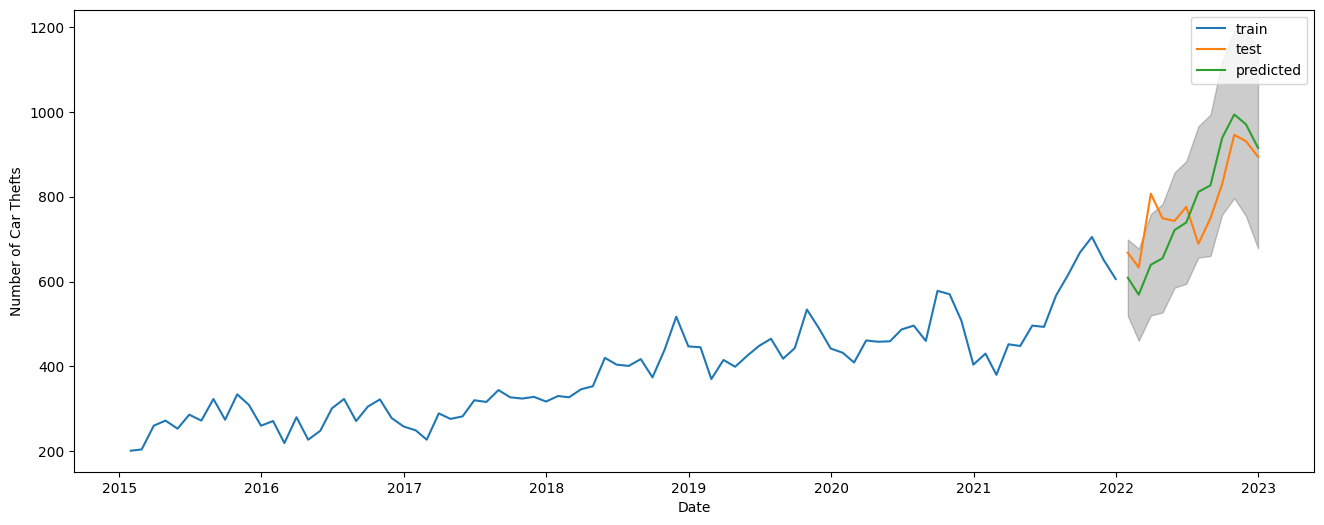

In [101]:
# Let's use this model to predict the test set
arima_pred = arima_results.get_prediction(start=datetime(2022, 1, 1), end=datetime(2022, 12, 1), dynamic=False)
# Get the predicted values
arima_pred_ci = arima_pred.conf_int()
# Plot the actual and predicted values
plt.figure(figsize=(16, 6))
ax = sns.lineplot(x=arima_train.index, y='counts', data=arima_train, label='train')
sns.lineplot(x=arima_test.index, y='counts', data=arima_test, label='test')
sns.lineplot(x=arima_pred_ci.index, y=arima_pred.predicted_mean, label='predicted')
ax.fill_between(arima_pred_ci.index,
                arima_pred_ci.iloc[:, 0],
                arima_pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Car Thefts')
plt.show()

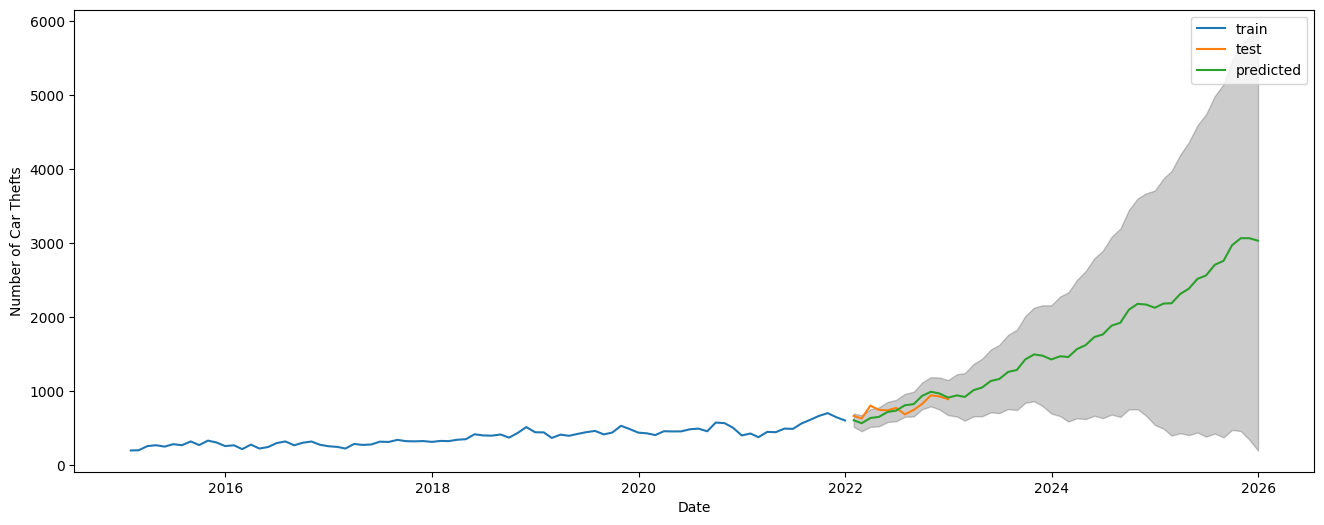

In [102]:
# This looks pretty good, let's see what the predictions look like if we push this off to 2025
arima_pred = arima_results.get_prediction(start=datetime(2022, 1, 1), end=datetime(2025, 12, 1), dynamic=False)
# Get the predicted values
arima_pred_ci = arima_pred.conf_int()
# Plot the actual and predicted values
plt.figure(figsize=(16, 6))
ax = sns.lineplot(x=arima_train.index, y='counts', data=arima_train, label='train')
sns.lineplot(x=arima_test.index, y='counts', data=arima_test, label='test')
sns.lineplot(x=arima_pred_ci.index, y=arima_pred.predicted_mean, label='predicted')
ax.fill_between(arima_pred_ci.index,
                arima_pred_ci.iloc[:, 0],
                arima_pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Car Thefts')
plt.show()

Text(0, 0.5, 'Density')

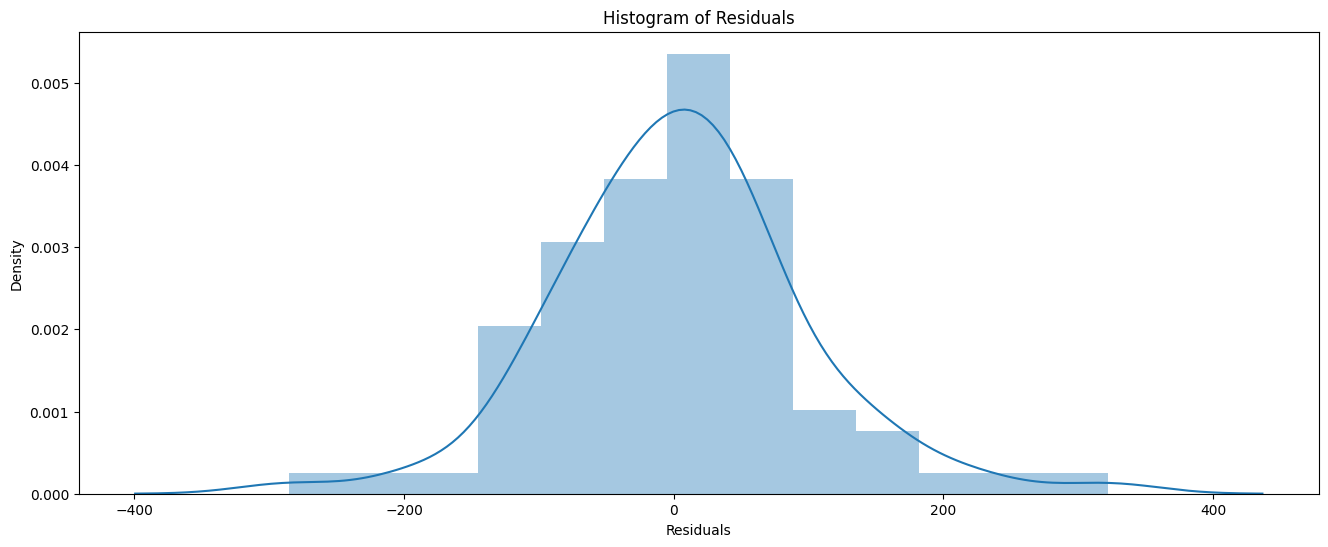

In [109]:
# Plot a histogram of the residuals
plt.figure(figsize=(16, 6))
sns.distplot(arima_results.resid)
# Labels
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')

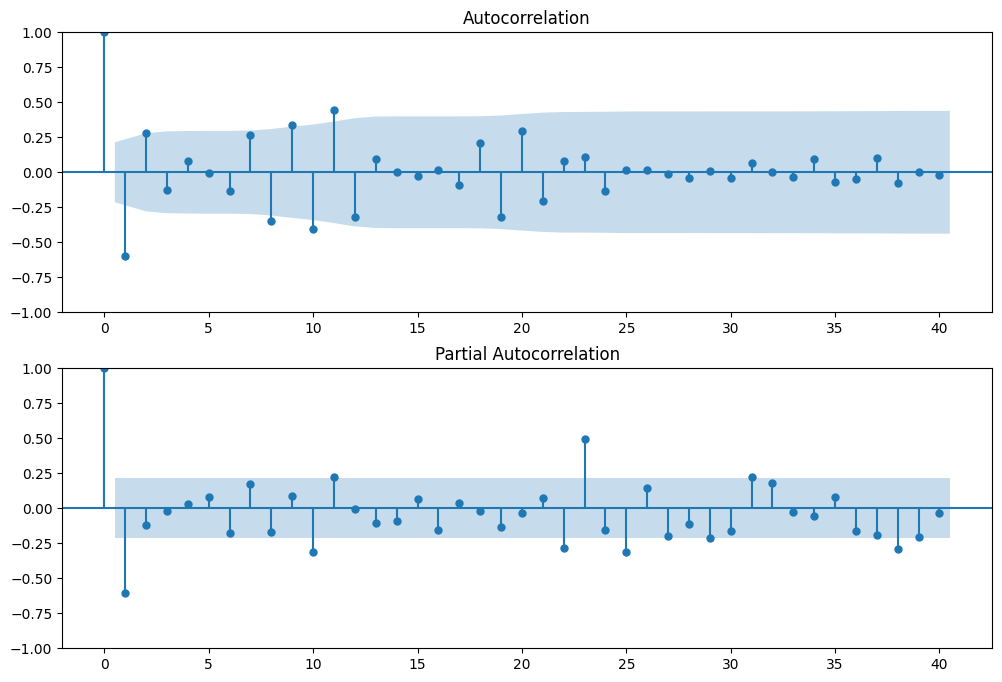

In [110]:
# Look at the correlation and partial correlation of the residuals
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_results.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_results.resid, lags=40, ax=ax2)
